# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize predictors](#Summarize-predictors)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted distances](#Summarize-observed-and-predicted-distances)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [71]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import sys

%matplotlib inline

In [72]:
sys.path.insert(0, "../src")

In [73]:
from fit_model import DistanceExponentialGrowthModel

In [74]:
sns.set_style("white")
plt.style.use("huddlej")

In [75]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [76]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [77]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4, markersize=15):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=markersize)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [78]:
"""
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]
"""

predictor_names_order = [
    "naive",
    "fitness",
    "ep_x",
    "ne_star",
    "lbi",
    "delta_frequency",
    "ep_x-ne_star",
    "lbi-ep_x-ne_star"
]

minimal_predictor_names_order = [
    "naive",
    "ep_x",
    "ne_star",
    "lbi",
    "lbi-ep_x-ne_star"
]

In [79]:
data_root = "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/5_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/simulations/100/2000-10-01--2100-10-01/"
#data_root = "../results/builds/simulations/20/2000-10-01--2100-10-01/"
#data_root = "../results/builds/h3n2/30_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/simulated/simulated_sample_0/"

## Load data
[back to top](#Summarize-models)

In [80]:
tip_attributes_df = pd.read_table(data_root + "tip_attributes_with_weighted_distances.tsv", parse_dates=["timepoint"])

In [53]:
observed_weighted_distances = tip_attributes_df.loc[:, ["timepoint", "strain", "frequency", "weighted_distance_to_future"]].copy()

In [54]:
observed_weighted_distances["y"] = observed_weighted_distances["weighted_distance_to_future"]

In [13]:
model_jsons = glob.glob(data_root + "models_by_distances/*.json")

In [14]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [15]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [16]:
models_by_predictors["lbi"]["l1_lambda"]

0.01

In [17]:
models_by_predictors["lbi"]["training_window"]

6

In [18]:
models_by_predictors["lbi"]["pseudocount"]

In [19]:
type(models_by_predictors["lbi"])

dict

In [20]:
sorted(models_by_predictors.keys())

['delta_frequency',
 'ep_x',
 'ep_x-ne_star',
 'fitness',
 'lbi',
 'lbi-ep_x-ne_star',
 'naive',
 'ne_star']

In [21]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'mean_stds_mean', 'mean_stds_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [22]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'mean_stds', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [23]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

824

In [24]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['y', 'y_hat'])

In [25]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[2.968829378785475]

In [26]:
models_by_predictors["lbi"]["scores"][0]["mean_stds"]

[0.04752344185618685]

In [27]:
len(models_by_predictors["lbi"]["scores"])

23

Build data frames for plotting from the model scores.

In [28]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
mean_stds_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": pd.to_datetime(scores["validation_timepoint"]),
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient, mean_std in zip(model["predictors"], scores["coefficients"], scores["mean_stds"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": pd.to_datetime(scores["validation_timepoint"])
            })
            
            mean_stds_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "mean_std": mean_std,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        #X = pd.DataFrame(scores["validation_data"]["X"])
        #X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])
        y["future_timepoint"] = pd.to_datetime(y["future_timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["y"] = y_hat["y"] + 2.97
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        #training_X = pd.DataFrame(scores["training_data"]["X"])
        #training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["y"] = training_y_hat["y"] + 2.97
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
mean_stds_by_time_df = pd.DataFrame(mean_stds_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [29]:
errors_by_time_df["validation_timepoint"].head()

0   2018-10-01
1   2019-04-01
2   2019-10-01
3   2020-04-01
4   2020-10-01
Name: validation_timepoint, dtype: datetime64[ns]

In [30]:
errors_by_time_df["simulation_year"] = errors_by_time_df["validation_timepoint"].dt.year - 2000

In [31]:
errors_by_time_df["simulation_month"] = errors_by_time_df["validation_timepoint"].dt.month

In [32]:
errors_by_time_df.apply(lambda row: "%s-%s" % (row["simulation_year"], row["simulation_month"]), axis=1).head()

0    18-10
1     19-4
2    19-10
3     20-4
4    20-10
dtype: object

In [33]:
training_y.head()

frequency future_timepoint          strain  timepoint  \
0   0.000001       2023-10-01   sample_2292_1 2022-10-01   
1   0.000001       2023-10-01  sample_2292_10 2022-10-01   
2   0.000001       2023-10-01   sample_2292_2 2022-10-01   
3   0.000001       2023-10-01   sample_2292_5 2022-10-01   
4   0.000001       2023-10-01   sample_2292_6 2022-10-01   

   weighted_distance_to_future  weighted_distance_to_present          y  
0                    18.678042                     16.874920  18.678042  
1                    14.269411                     12.555988  14.269411  
2                    43.127686                     41.363000  43.127686  
3                    15.894315                     13.712898  15.894315  
4                    24.560242                     22.333370  24.560242

In [34]:
y_hat.head()

fitness  frequency  projected_frequency          strain  timepoint  \
0      0.0   0.000001         9.999930e-07  sample_2892_10 2029-10-01   
1      0.0   0.000001         9.999930e-07   sample_2892_2 2029-10-01   
2      0.0   0.000001         9.999930e-07   sample_2892_5 2029-10-01   
3      0.0   0.000004         3.999972e-06   sample_2896_2 2029-10-01   
4      0.0   0.000004         3.999972e-06   sample_2896_5 2029-10-01   

   weighted_distance_to_future  weighted_distance_to_present          y  
0                    40.428249                     34.740679  37.710436  
1                    21.347476                     18.205285  21.175158  
2                    22.055573                     18.259754  21.229626  
3                    24.469220                     20.441599  23.411456  
4                    21.809587                     20.648221  23.618076

In [35]:
frequency_df.head()

Empty DataFrame
Columns: [fitness, frequency, projected_frequency, strain, timepoint, weighted_distance_to_future_hat, weighted_distance_to_present, y_hat, weighted_distance_to_future, y, residual, validation_timepoint, predictors]
Index: []

In [36]:
residual_df.head()

Empty DataFrame
Columns: [fitness, frequency, projected_frequency, strain, timepoint, weighted_distance_to_future_hat, weighted_distance_to_present, y_hat, weighted_distance_to_future, y, residual, validation_timepoint, predictors]
Index: []

In [37]:
residual_df.shape

(0, 13)

In [38]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0    fitness         -0.148548           101           2018-10-01   
1    fitness         -0.194744           102           2019-04-01   
2    fitness         -0.072634            99           2019-10-01   
3    fitness         -0.191325           100           2020-04-01   
4    fitness         -0.196980           102           2020-10-01   

   simulation_year  simulation_month  
0               18                10  
1               19                 4  
2               19                10  
3               20                 4  
4               20                10

In [39]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std        predictors
1      -0.124267      0.176031               lbi
2      -0.118425      0.205848  lbi-ep_x-ne_star
0      -0.061598      0.145619           fitness
5      -0.055234      0.166227   delta_frequency
3      -0.013792      0.191311           ne_star
4       0.017010      0.250403      ep_x-ne_star
7       0.081110      0.128736             naive
6       0.107405      0.214827              ep_x

## Summarize frequencies

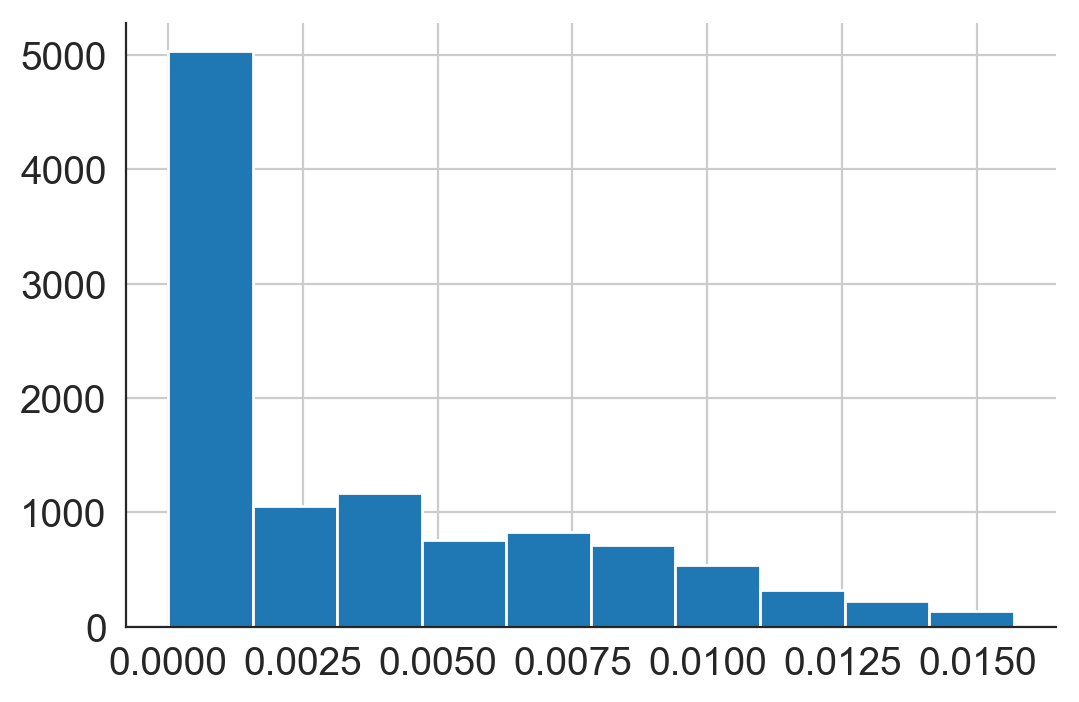

In [81]:
tip_attributes_df["diffusion_frequency"].hist()

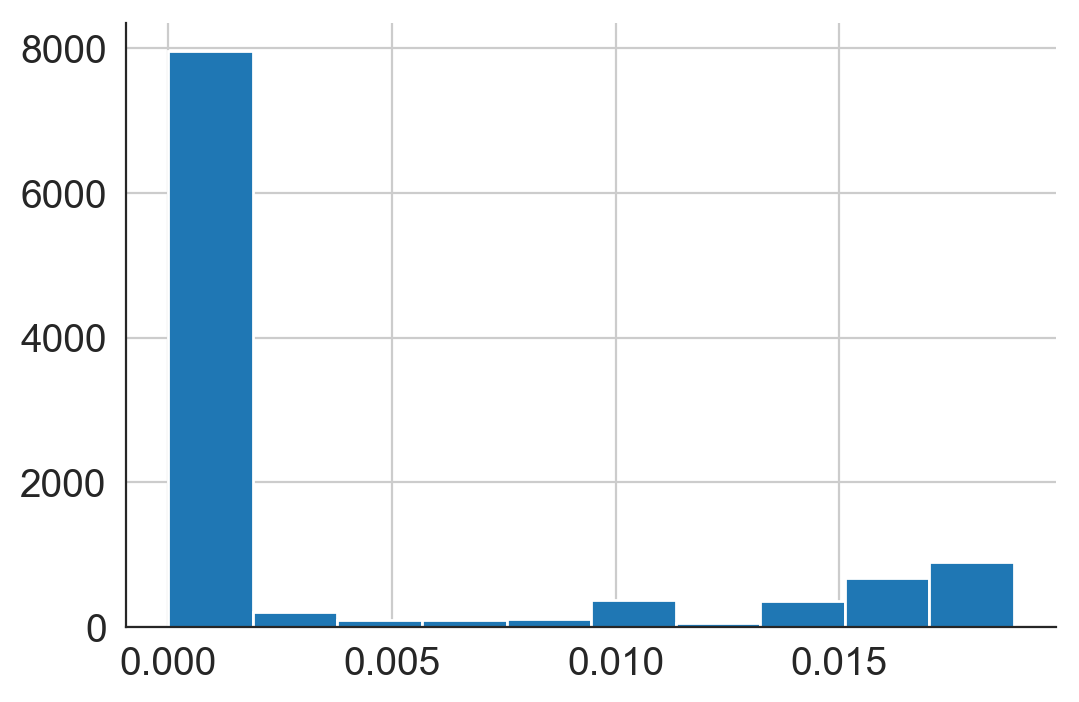

In [82]:
tip_attributes_df["kde_frequency"].hist()

In [83]:
tip_attributes_df.query("timepoint == '2020-10-01'")["diffusion_frequency"].value_counts().head()

0.001233    16
0.008453    14
0.004593    14
0.010219    14
0.003063    13
Name: diffusion_frequency, dtype: int64

In [84]:
(tip_attributes_df.query("timepoint == '2020-10-01'")["diffusion_frequency"] < 1e-5).sum()

0

In [85]:
tip_attributes_df.query("timepoint == '2020-10-01'")["diffusion_frequency"].shape

(356,)

In [86]:
tip_attributes_df["diffusion_frequency"].value_counts().head()

0.000012    220
0.000011    183
0.000014    170
0.000010    168
0.000013    157
Name: diffusion_frequency, dtype: int64

In [87]:
tip_attributes_df.query("kde_frequency > 0.0").shape

(3642, 36)

In [88]:
tip_attributes_df.query("kde_frequency > 0.0").shape

(3642, 36)

In [89]:
tip_attributes_df.query("kde_frequency > 0.0")["kde_frequency"].value_counts().head()

0.000011    98
0.000023    54
0.000053    52
0.000024    43
0.000103    23
Name: kde_frequency, dtype: int64

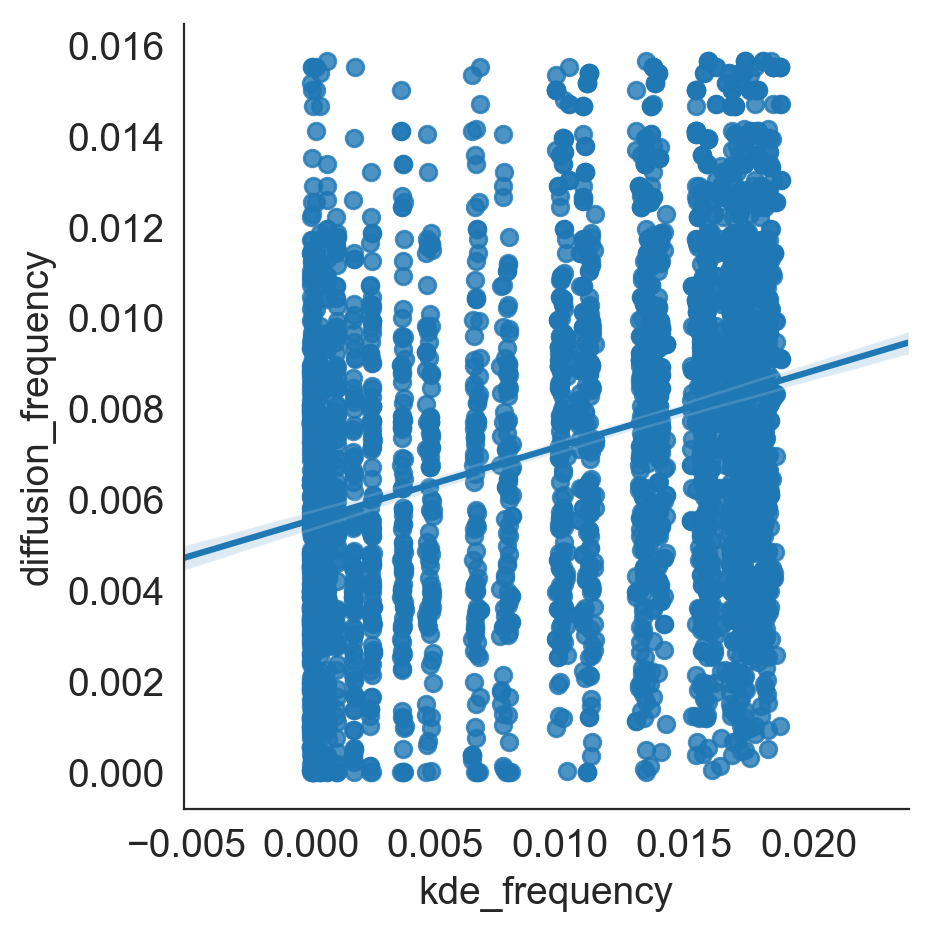

In [90]:
sns.lmplot(
    "kde_frequency",
    "diffusion_frequency",
    tip_attributes_df.query("kde_frequency > 0.0")
)

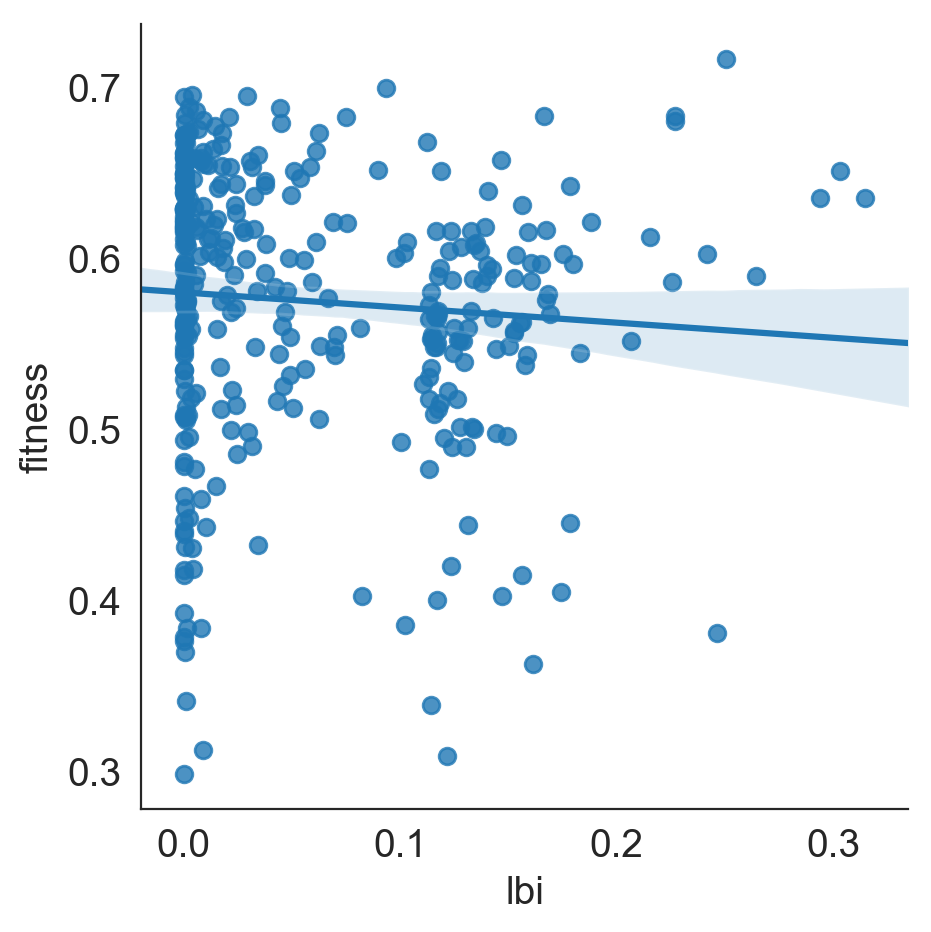

In [91]:
sns.lmplot(
    "lbi",
    "fitness",
    tip_attributes_df.query("timepoint == '2020-10-01'")
)

In [96]:
max_fitness_per_timepoint = tip_attributes_df.groupby("timepoint")["fitness"].max().reset_index().rename(columns={"fitness": "max_fitness"})

In [102]:
annotated_tip_attributes_df = tip_attributes_df.merge(
    max_fitness_per_timepoint,
    on=["timepoint"]
)

In [103]:
annotated_tip_attributes_df["normalized_fitness"] = annotated_tip_attributes_df["fitness"] / annotated_tip_attributes_df["max_fitness"]

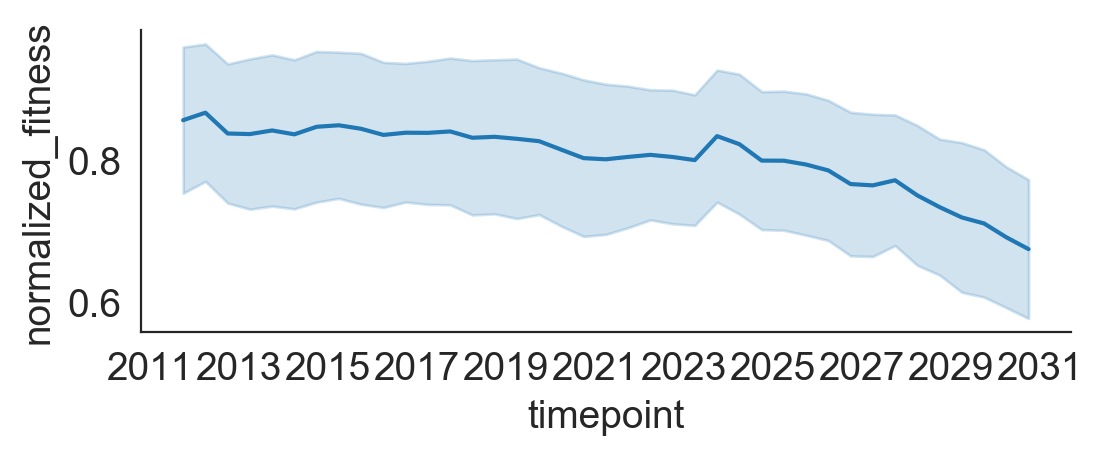

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.lineplot(
    x="timepoint",
    y="normalized_fitness",
    data=annotated_tip_attributes_df,
    ci="sd",
    ax=ax
)

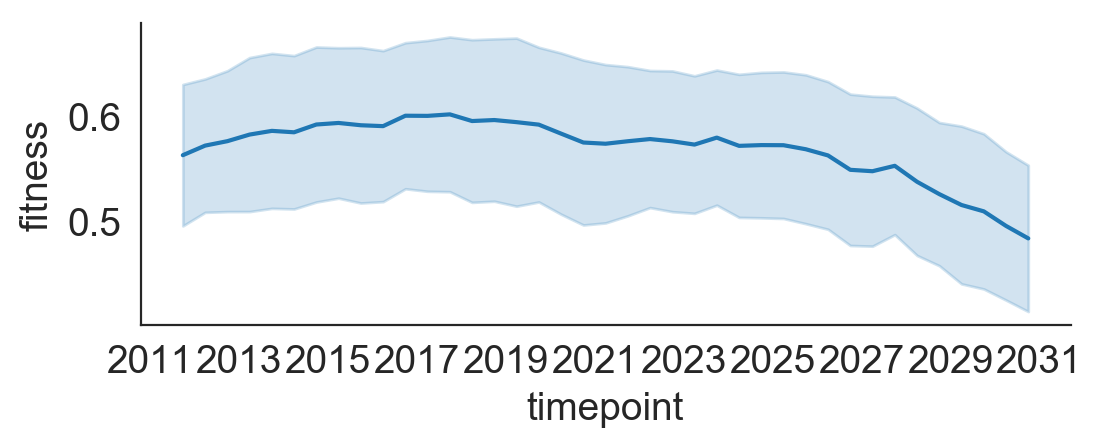

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.lineplot(
    x="timepoint",
    y="fitness",
    data=annotated_tip_attributes_df,
    ci="sd",
    ax=ax
)

In [117]:
annotated_tip_attributes_df.groupby("timepoint").aggregate({"fitness": ["mean", "std"], "normalized_fitness": ["mean", "std"]})

fitness           normalized_fitness          
                mean       std               mean       std
timepoint                                                  
2011-10-01  0.563230  0.067375           0.856111  0.102410
2012-04-01  0.572362  0.063567           0.866639  0.096251
2012-10-01  0.576601  0.067132           0.837461  0.097504
2013-04-01  0.582879  0.073367           0.836647  0.105309
2013-10-01  0.586409  0.073836           0.841715  0.105982
2014-04-01  0.585057  0.073064           0.836273  0.104437
2014-10-01  0.592467  0.073841           0.846866  0.105547
2015-04-01  0.593949  0.071674           0.848984  0.102450
2015-10-01  0.591765  0.074096           0.844066  0.105687
2016-04-01  0.590918  0.071939           0.835483  0.101712
2016-10-01  0.600847  0.069602           0.838567  0.097140
2017-04-01  0.600702  0.071866           0.838365  0.100299
2017-10-01  0.602134  0.073723           0.840364  0.102891
2018-04-01  0.595779  0.077495           0.831494  0.108155
2018-10-01  0.596732  0.077358           0.832824  0.107963
2019-04-01  0.594721  0.080083           0.830018  0.111767
2019-10-01  0.592351  0.073695           0.826709  0.102852
2020-04-01  0.583781  0.076835           0.814749  0.107234
2020-10-01  0.575308  0.078579           0.802924  0.109668
2021-04-01  0.574152  0.075429           0.801310  0.105272
2021-10-01  0.576530  0.071053           0.804629  0.099164
2022-04-01  0.578607  0.065323           0.807528  0.091168
2022-10-01  0.576470  0.067075           0.804546  0.093613
2023-04-01  0.573342  0.065514           0.800181  0.091435
2023-10-01  0.579977  0.064379           0.833801  0.092554
2024-04-01  0.572125  0.068177           0.822512  0.098014
2024-10-01  0.572846  0.069304           0.799488  0.096723
2025-04-01  0.572741  0.069820           0.799342  0.097444
2025-10-01  0.568890  0.070941           0.793967  0.099008
2026-04-01  0.562999  0.070360           0.785745  0.098197
2026-10-01  0.549294  0.072107           0.766618  0.100636
2027-04-01  0.547961  0.071416           0.764758  0.099671
2027-10-01  0.553108  0.065577           0.771941  0.091522
2028-04-01  0.537900  0.070209           0.750716  0.097986
2028-10-01  0.526113  0.068248           0.734265  0.095249
2029-04-01  0.515761  0.075140           0.719817  0.104869
2029-10-01  0.509709  0.073957           0.711372  0.103218
2030-04-01  0.495866  0.070691           0.692051  0.098660
2030-10-01  0.483939  0.069696           0.675406  0.097271

## Summarize predictors
[back to top](#Summarize-models)

In [40]:
individual_predictor_names_order = [
    predictor
    for predictor in predictor_names_order
    if not "-" in predictor and predictor != "naive"
]

In [41]:
individual_predictor_names_order

['fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [42]:
long_predictors_df = tip_attributes_df.melt(
    id_vars=["strain", "timepoint"],
    value_vars=individual_predictor_names_order,
    var_name="predictor",
    value_name="predictor_value"
)

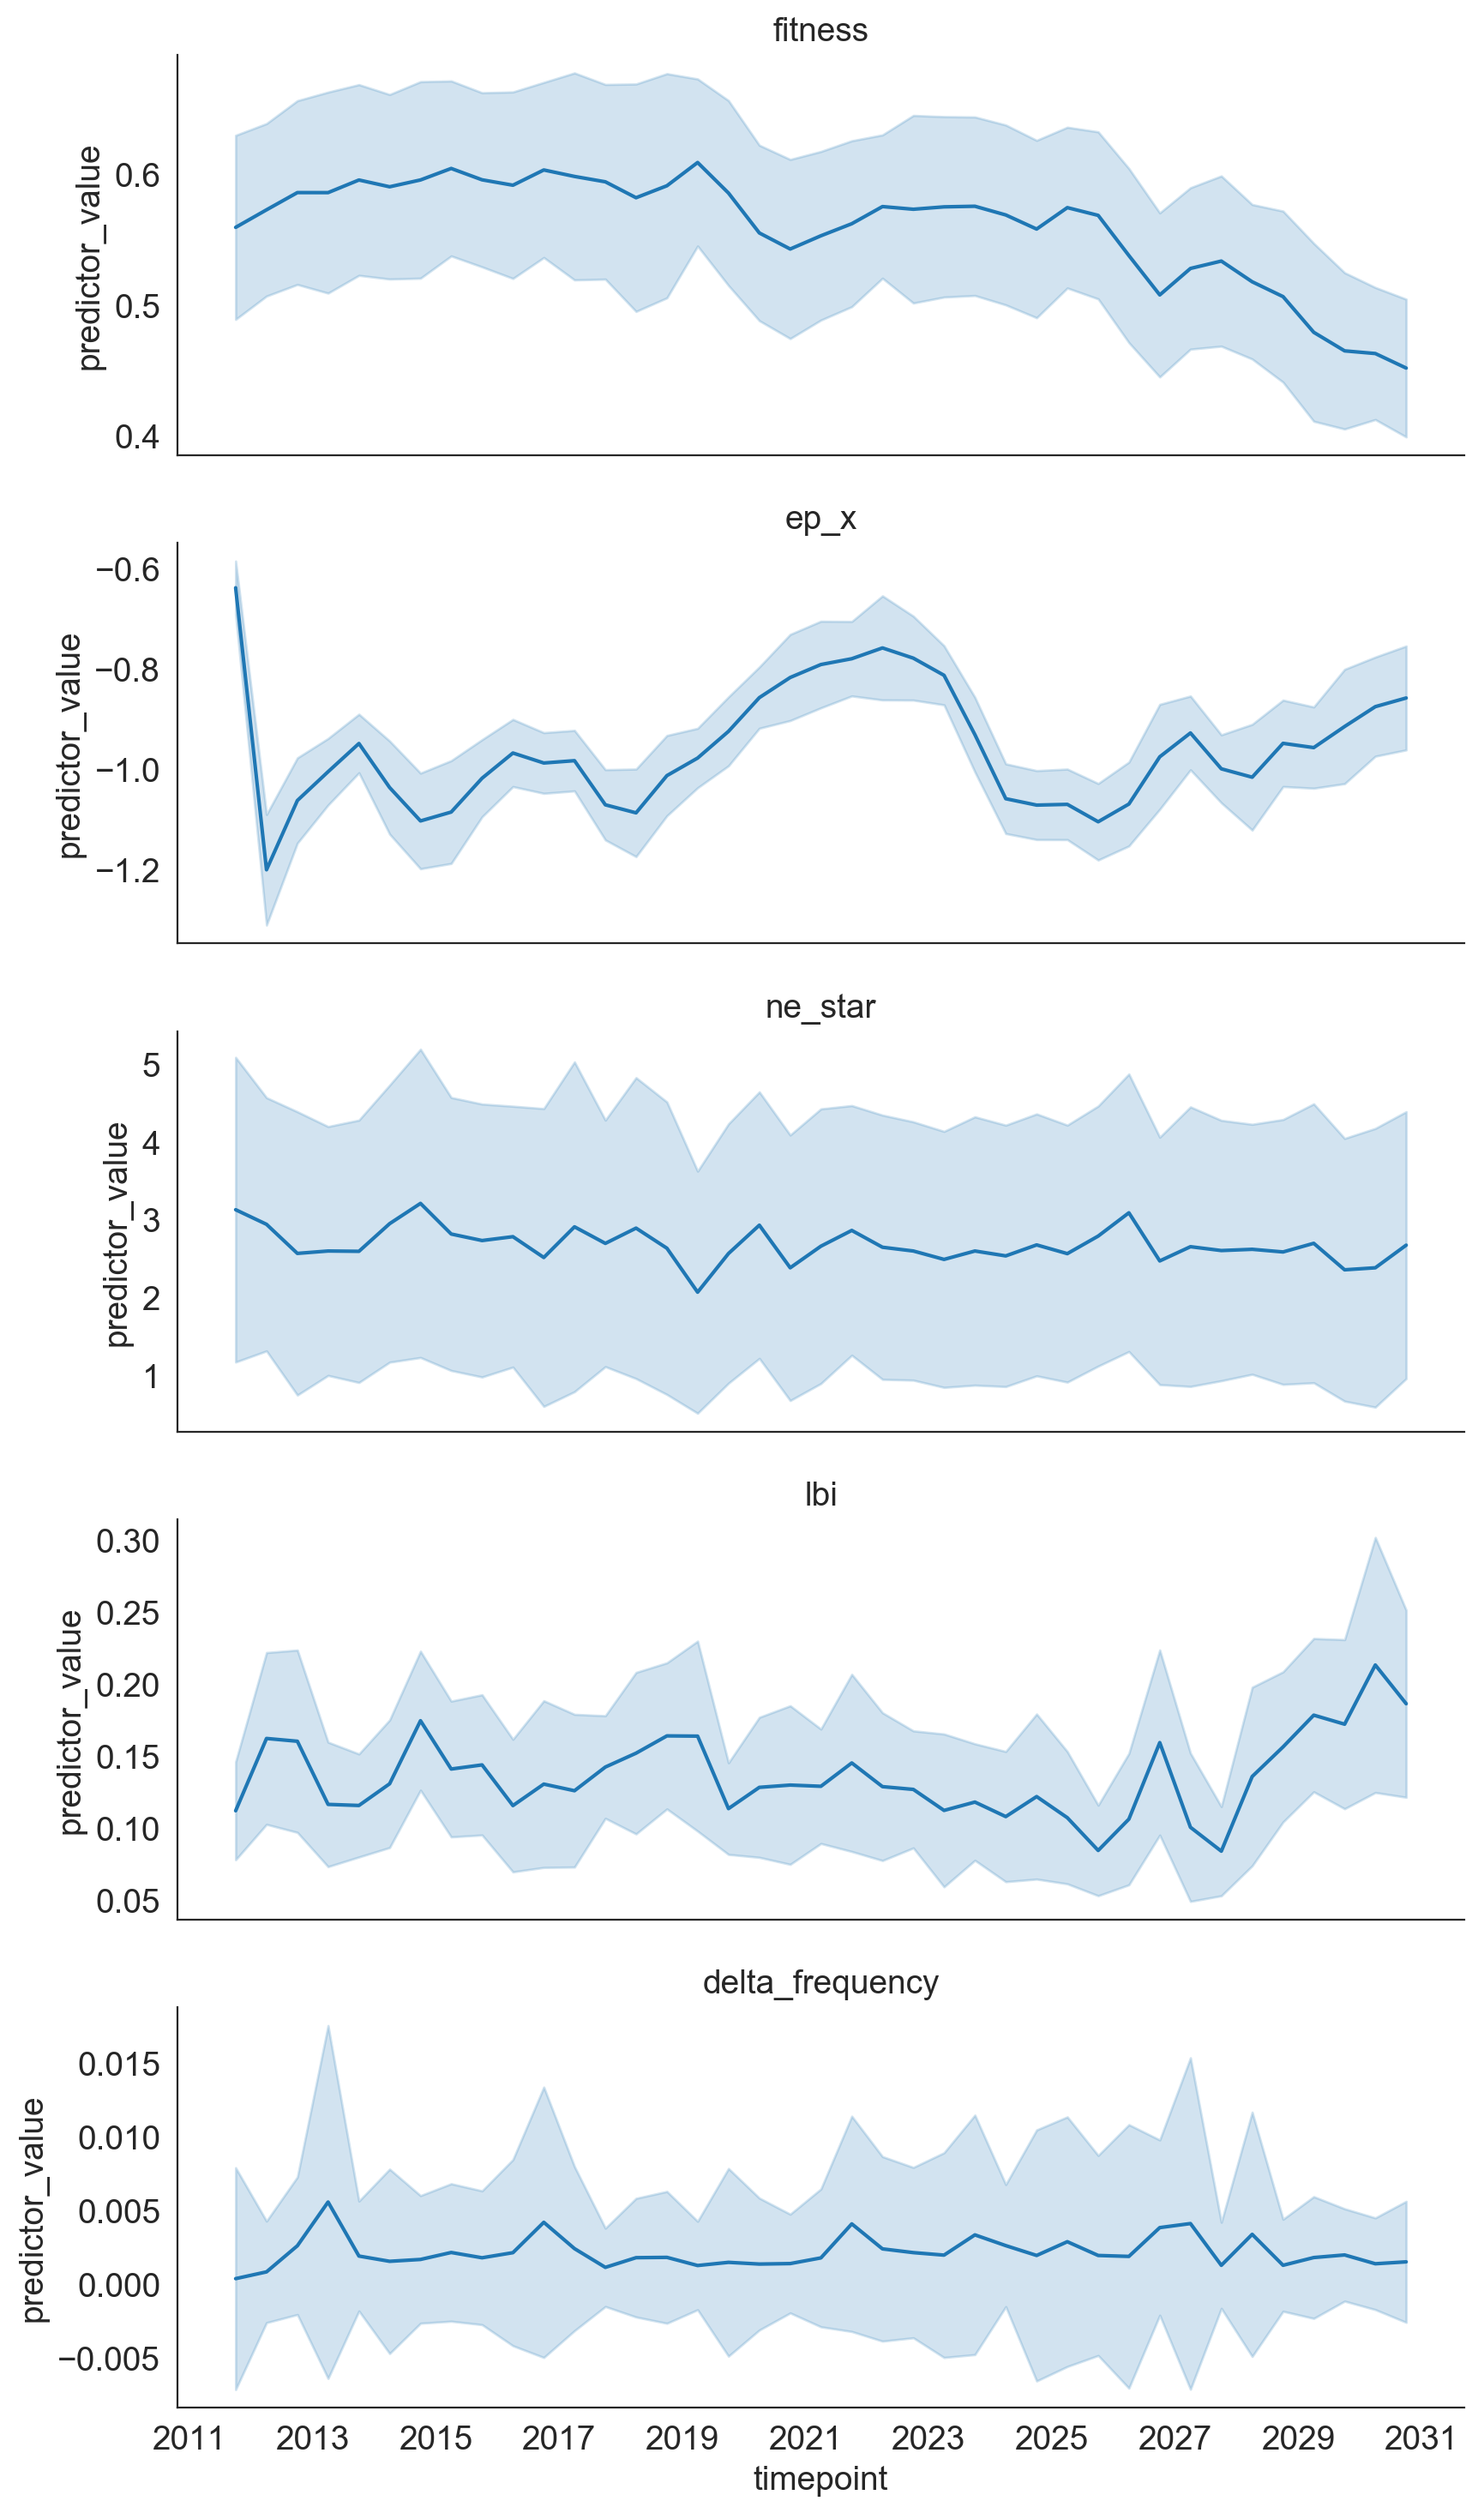

In [43]:
g = sns.FacetGrid(long_predictors_df, row="predictor", aspect=3, sharey=False)
g.map(sns.lineplot, "timepoint", "predictor_value", ci="sd")
g.set_titles("{row_name}")

plt.savefig("../manuscript/figures/predictors_by_timepoint.png")

In [44]:
mean_stds_by_time_df.head()

mean_std predictor predictors validation_timepoint
0  0.071270   fitness    fitness           2018-10-01
1  0.072545   fitness    fitness           2019-04-01
2  0.074063   fitness    fitness           2019-10-01
3  0.073573   fitness    fitness           2020-04-01
4  0.073102   fitness    fitness           2020-10-01

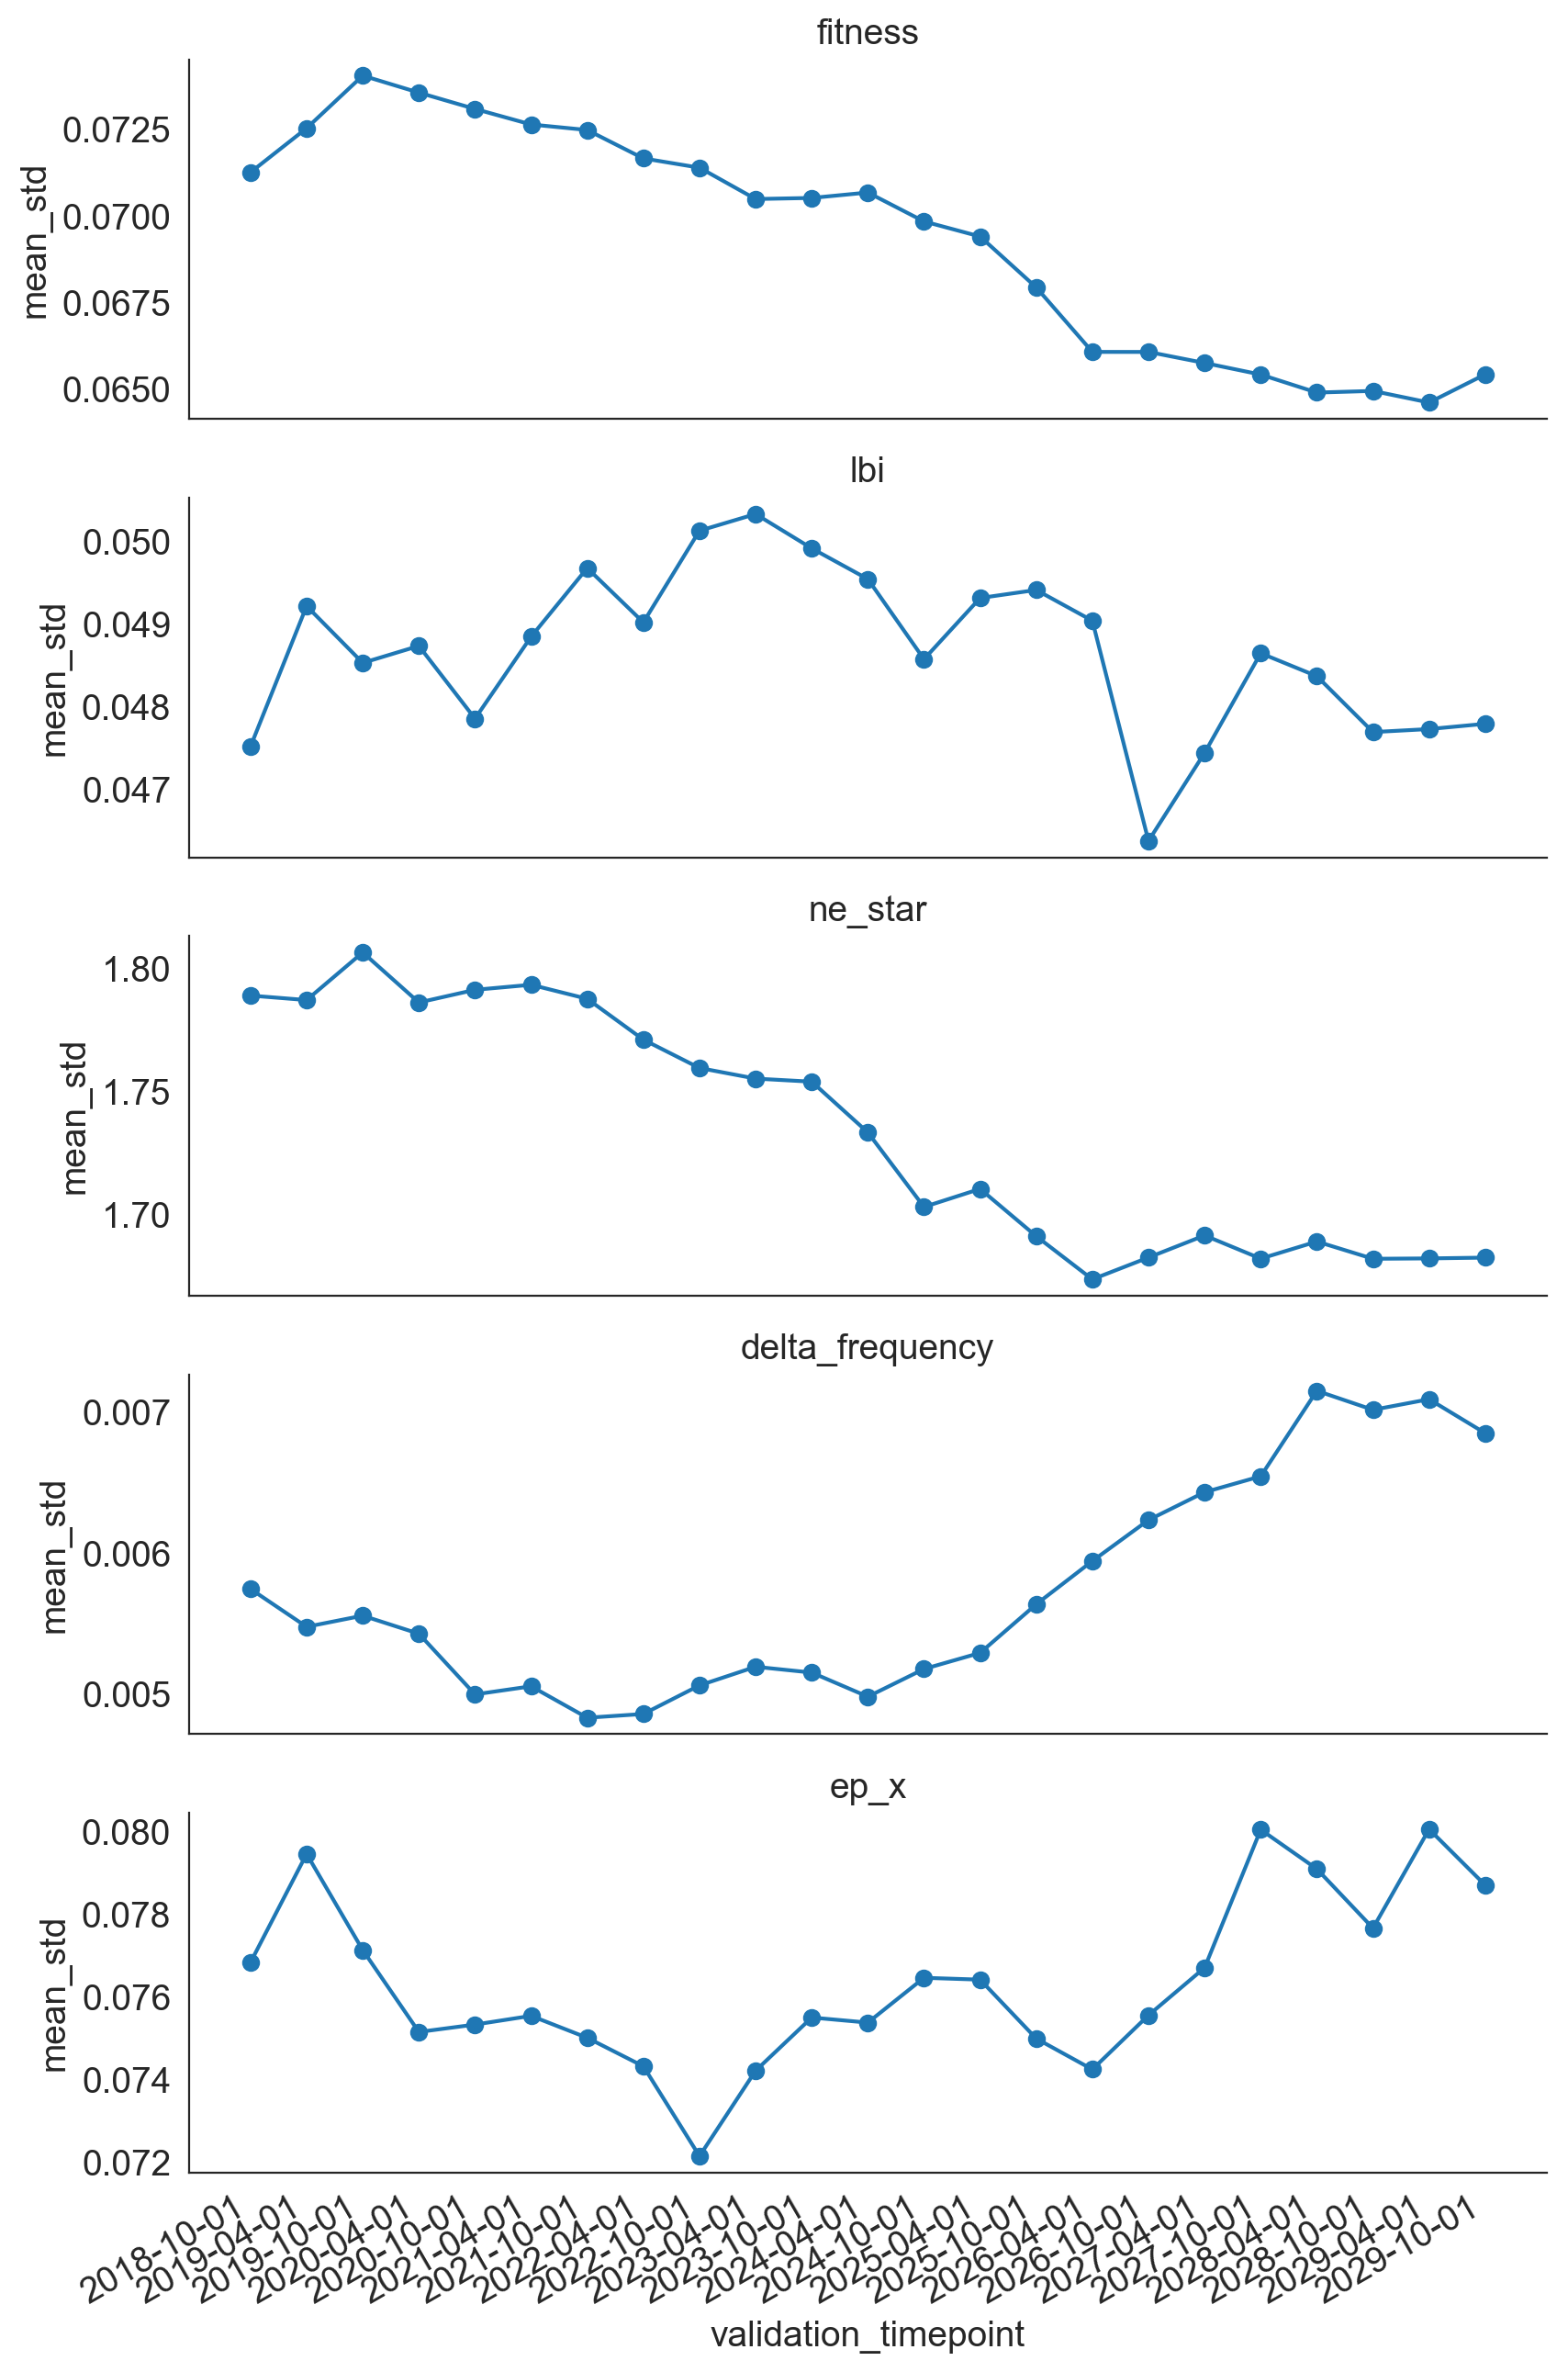

In [45]:
g = sns.FacetGrid(
    mean_stds_by_time_df[mean_stds_by_time_df["predictors"].isin(individual_predictor_names_order)],
    row="predictor",
    aspect=3,
    sharey=False
)
g.map(plt.plot, "validation_timepoint", "mean_std", marker="o")
g.set_titles("{row_name}")

plt.gcf().autofmt_xdate()

In [46]:
min_max_mean_std = mean_stds_by_time_df.groupby("predictors")["mean_std"].aggregate(["min", "max"]).reset_index()

In [47]:
min_max_mean_std["delta"] = min_max_mean_std["max"] - min_max_mean_std["min"]

In [48]:
min_max_mean_std.sort_values("delta")

predictors       min       max     delta
6             naive  0.000000  0.000000  0.000000
0   delta_frequency  0.004835  0.007155  0.002319
4               lbi  0.046384  0.050331  0.003947
1              ep_x  0.072165  0.080073  0.007908
3           fitness  0.064622  0.074063  0.009441
7           ne_star  1.673616  1.806710  0.133094
2      ep_x-ne_star  0.072165  1.806710  1.734545
5  lbi-ep_x-ne_star  0.046384  1.806710  1.760326

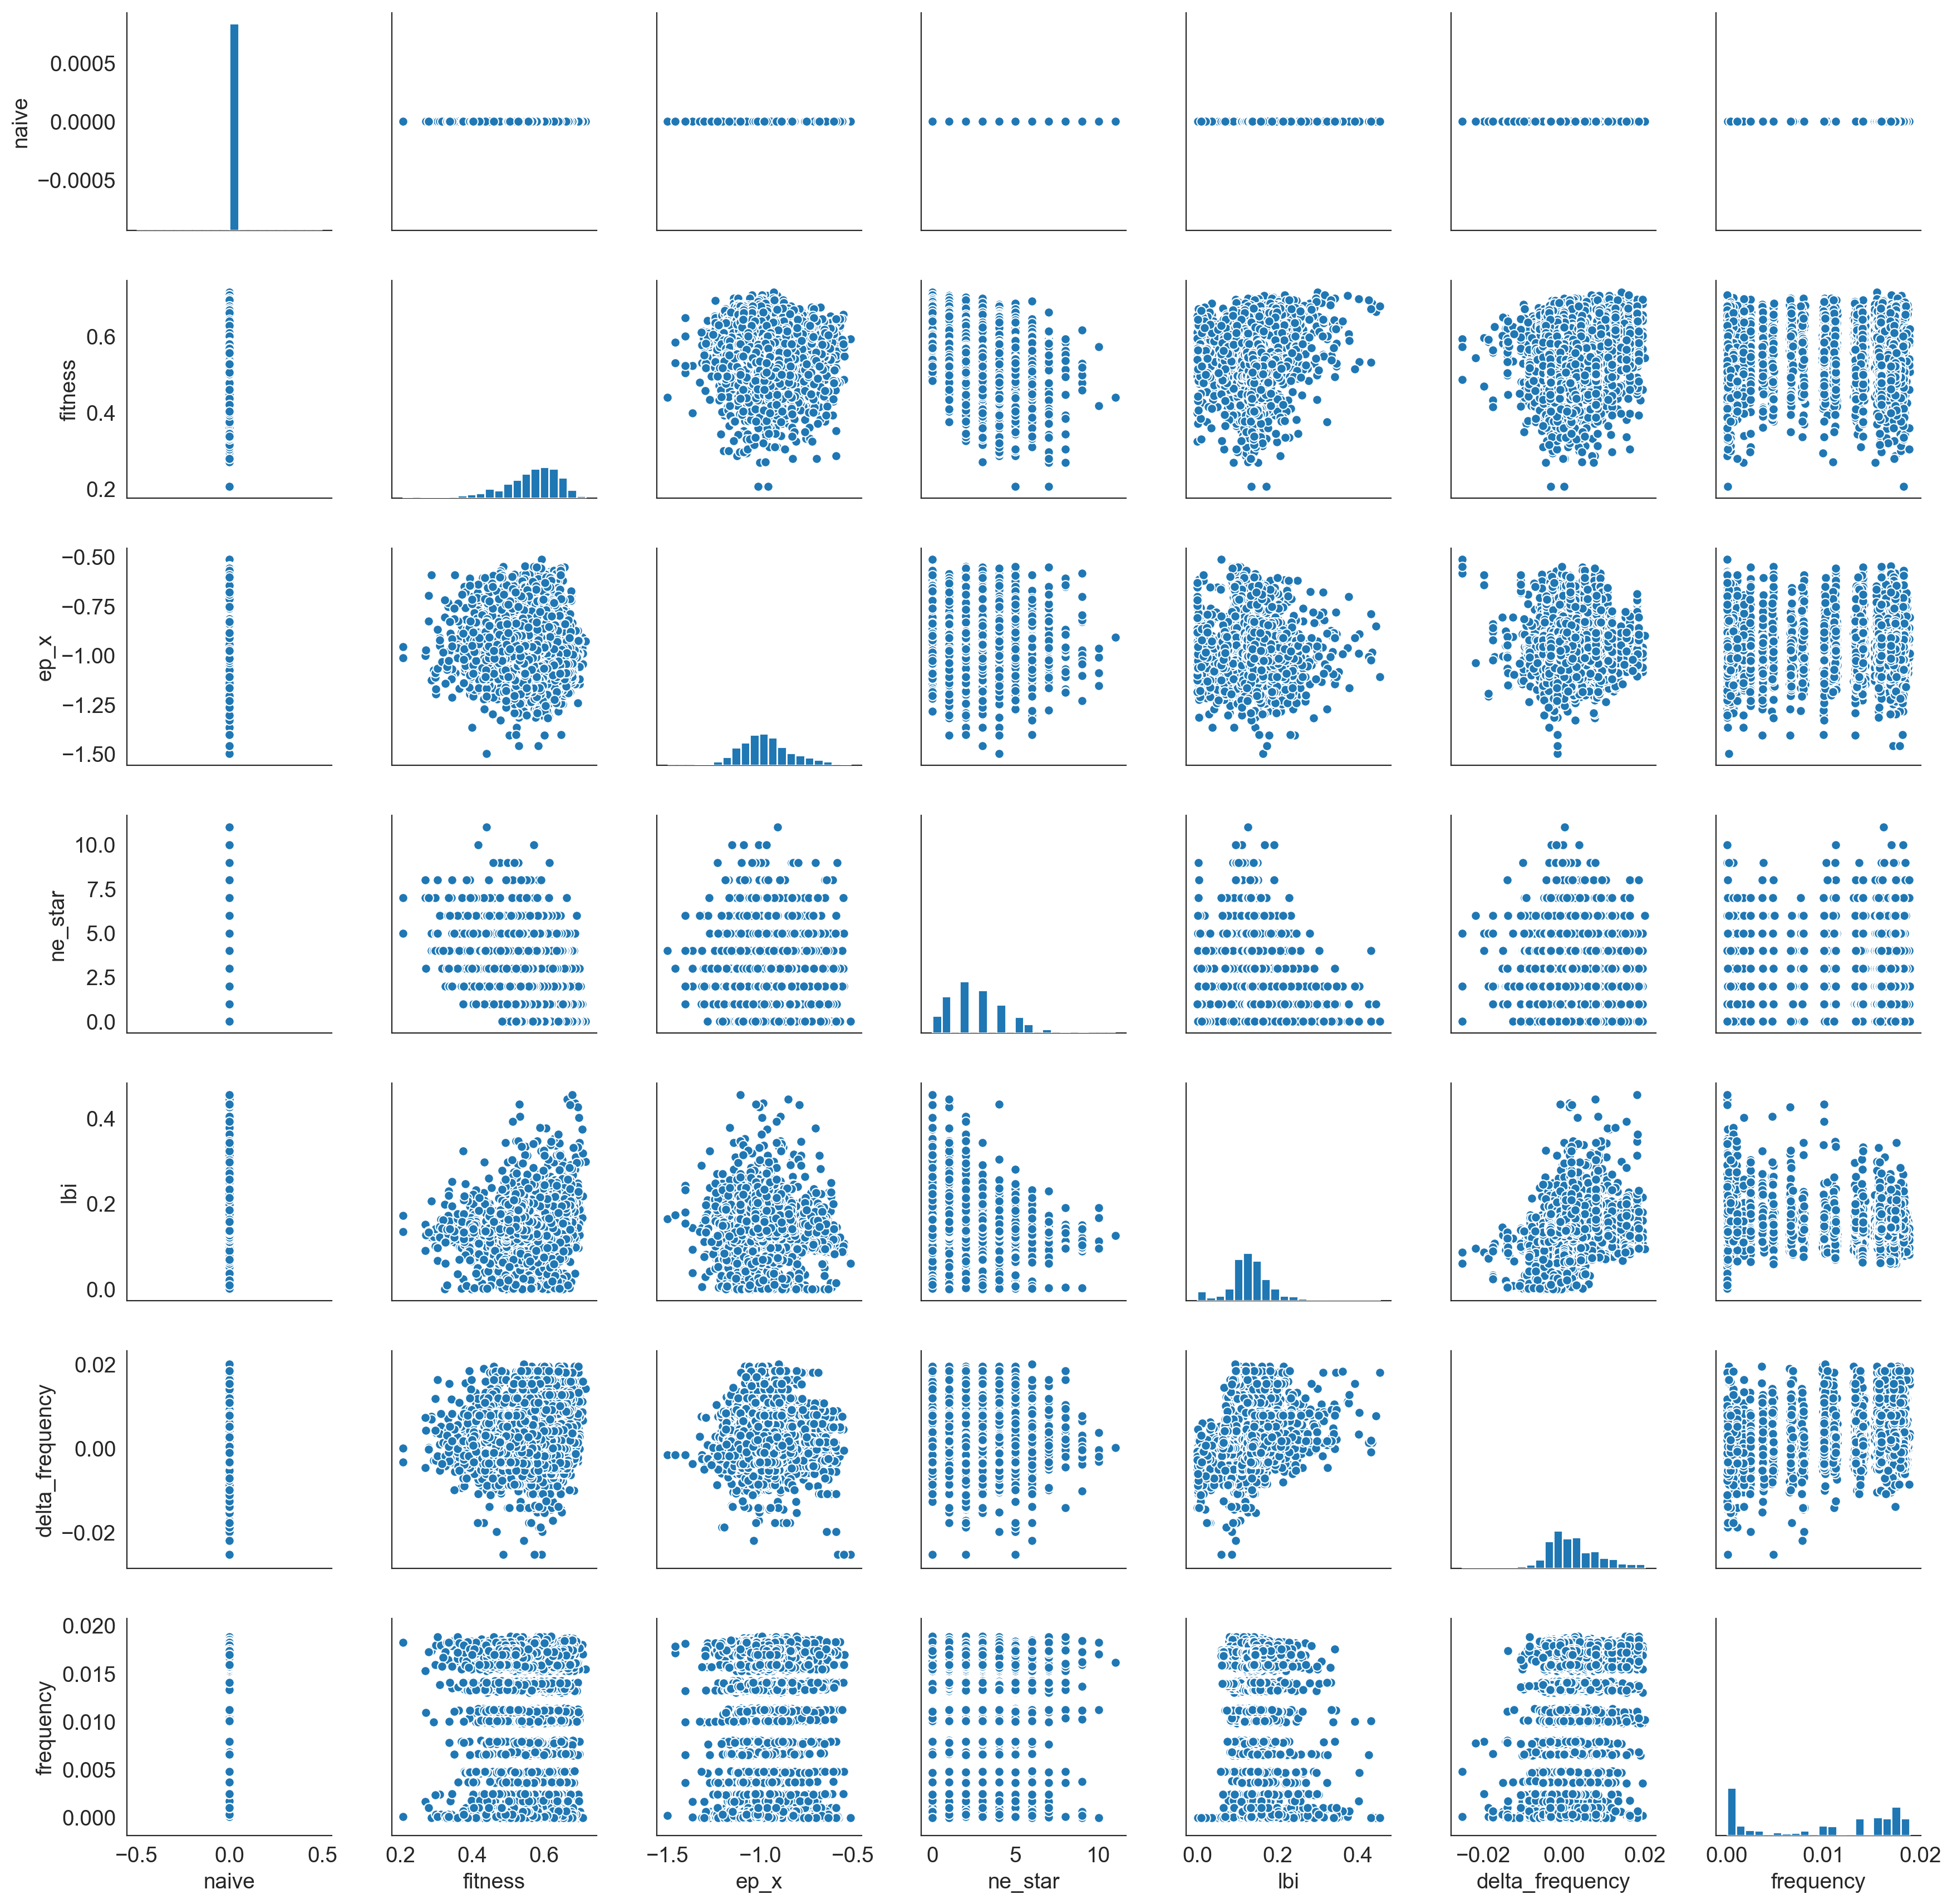

In [49]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df.dropna(), vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

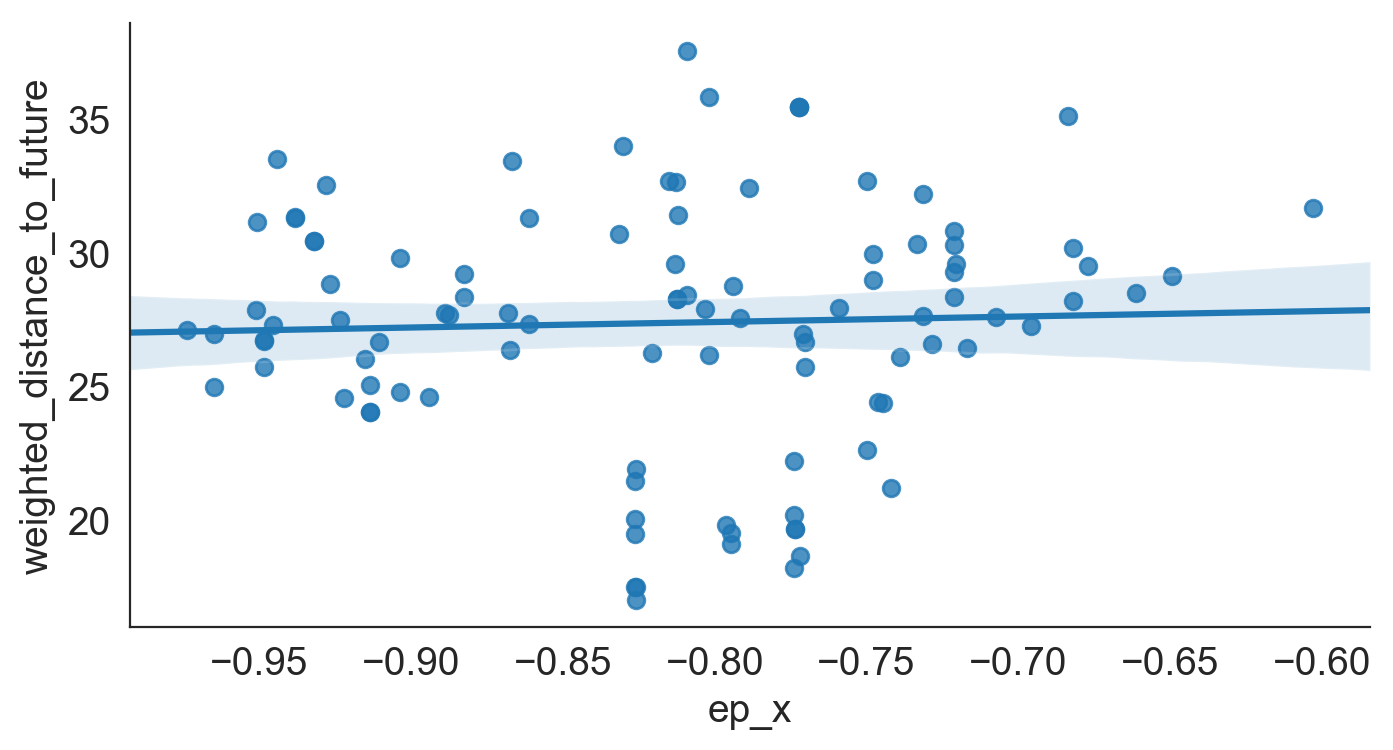

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.regplot(
    "ep_x",
    "weighted_distance_to_future",
    tip_attributes_df.loc[tip_attributes_df["timepoint"] == "2020-10-01"],
    ax=ax
)

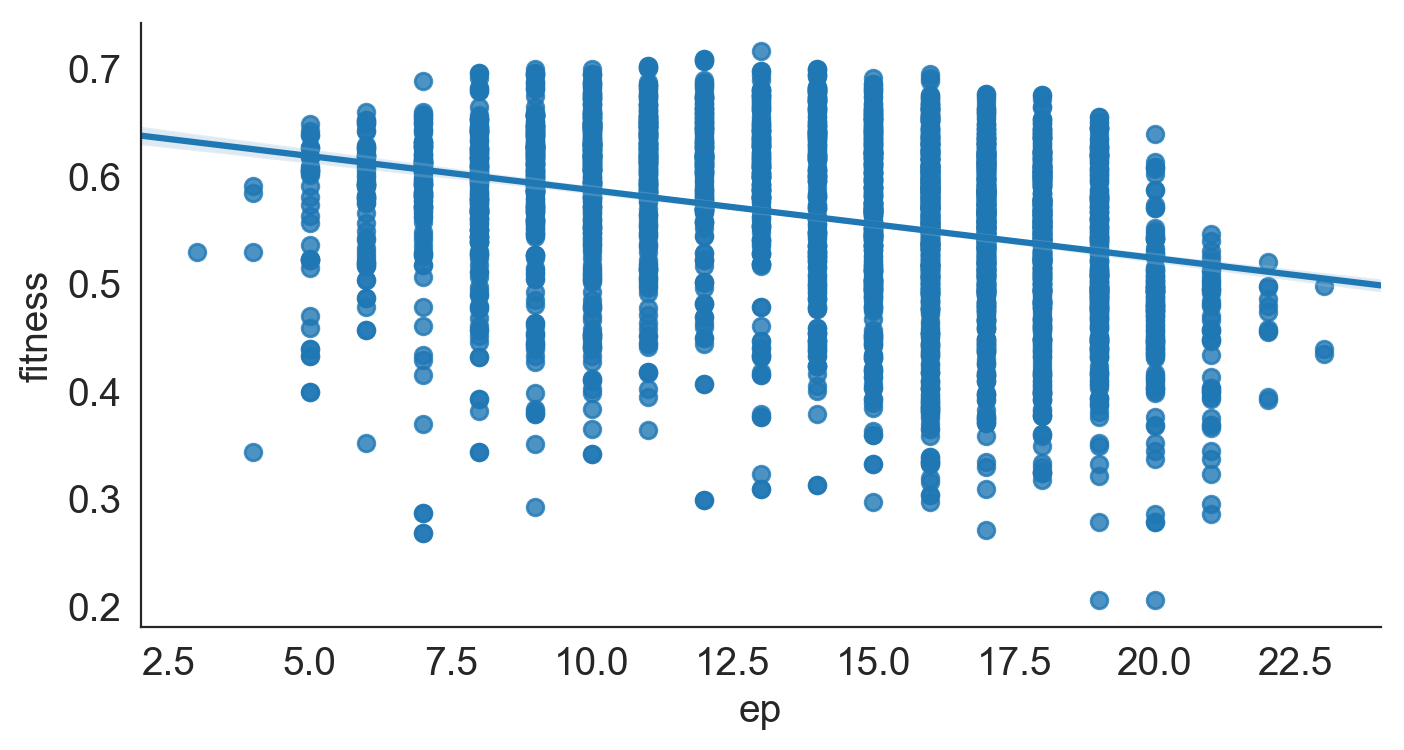

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.regplot(
    "ep",
    "fitness",
    tip_attributes_df,
    ax=ax
)

In [52]:
"""sns.lmplot(
    "ep_x",
    "weighted_distance_to_future",
    tip_attributes_df,
    col="timepoint",
    col_wrap=4,
    sharex=False,
    sharey=False
)"""

'sns.lmplot(\n    "ep_x",\n    "weighted_distance_to_future",\n    tip_attributes_df,\n    col="timepoint",\n    col_wrap=4,\n    sharex=False,\n    sharey=False\n)'

## Summarize model residuals
[back to top](#Summarize-models)

In [53]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [54]:
residuals_by_timepoint.head()

predictors  timepoint    residual
0  delta_frequency 2011-10-01  -73.814208
1  delta_frequency 2012-04-01 -378.314987
2  delta_frequency 2012-10-01   56.984596
3  delta_frequency 2013-04-01  352.048293
4  delta_frequency 2013-10-01  393.815881

In [55]:
max_lags = 18

### Residuals by predictor

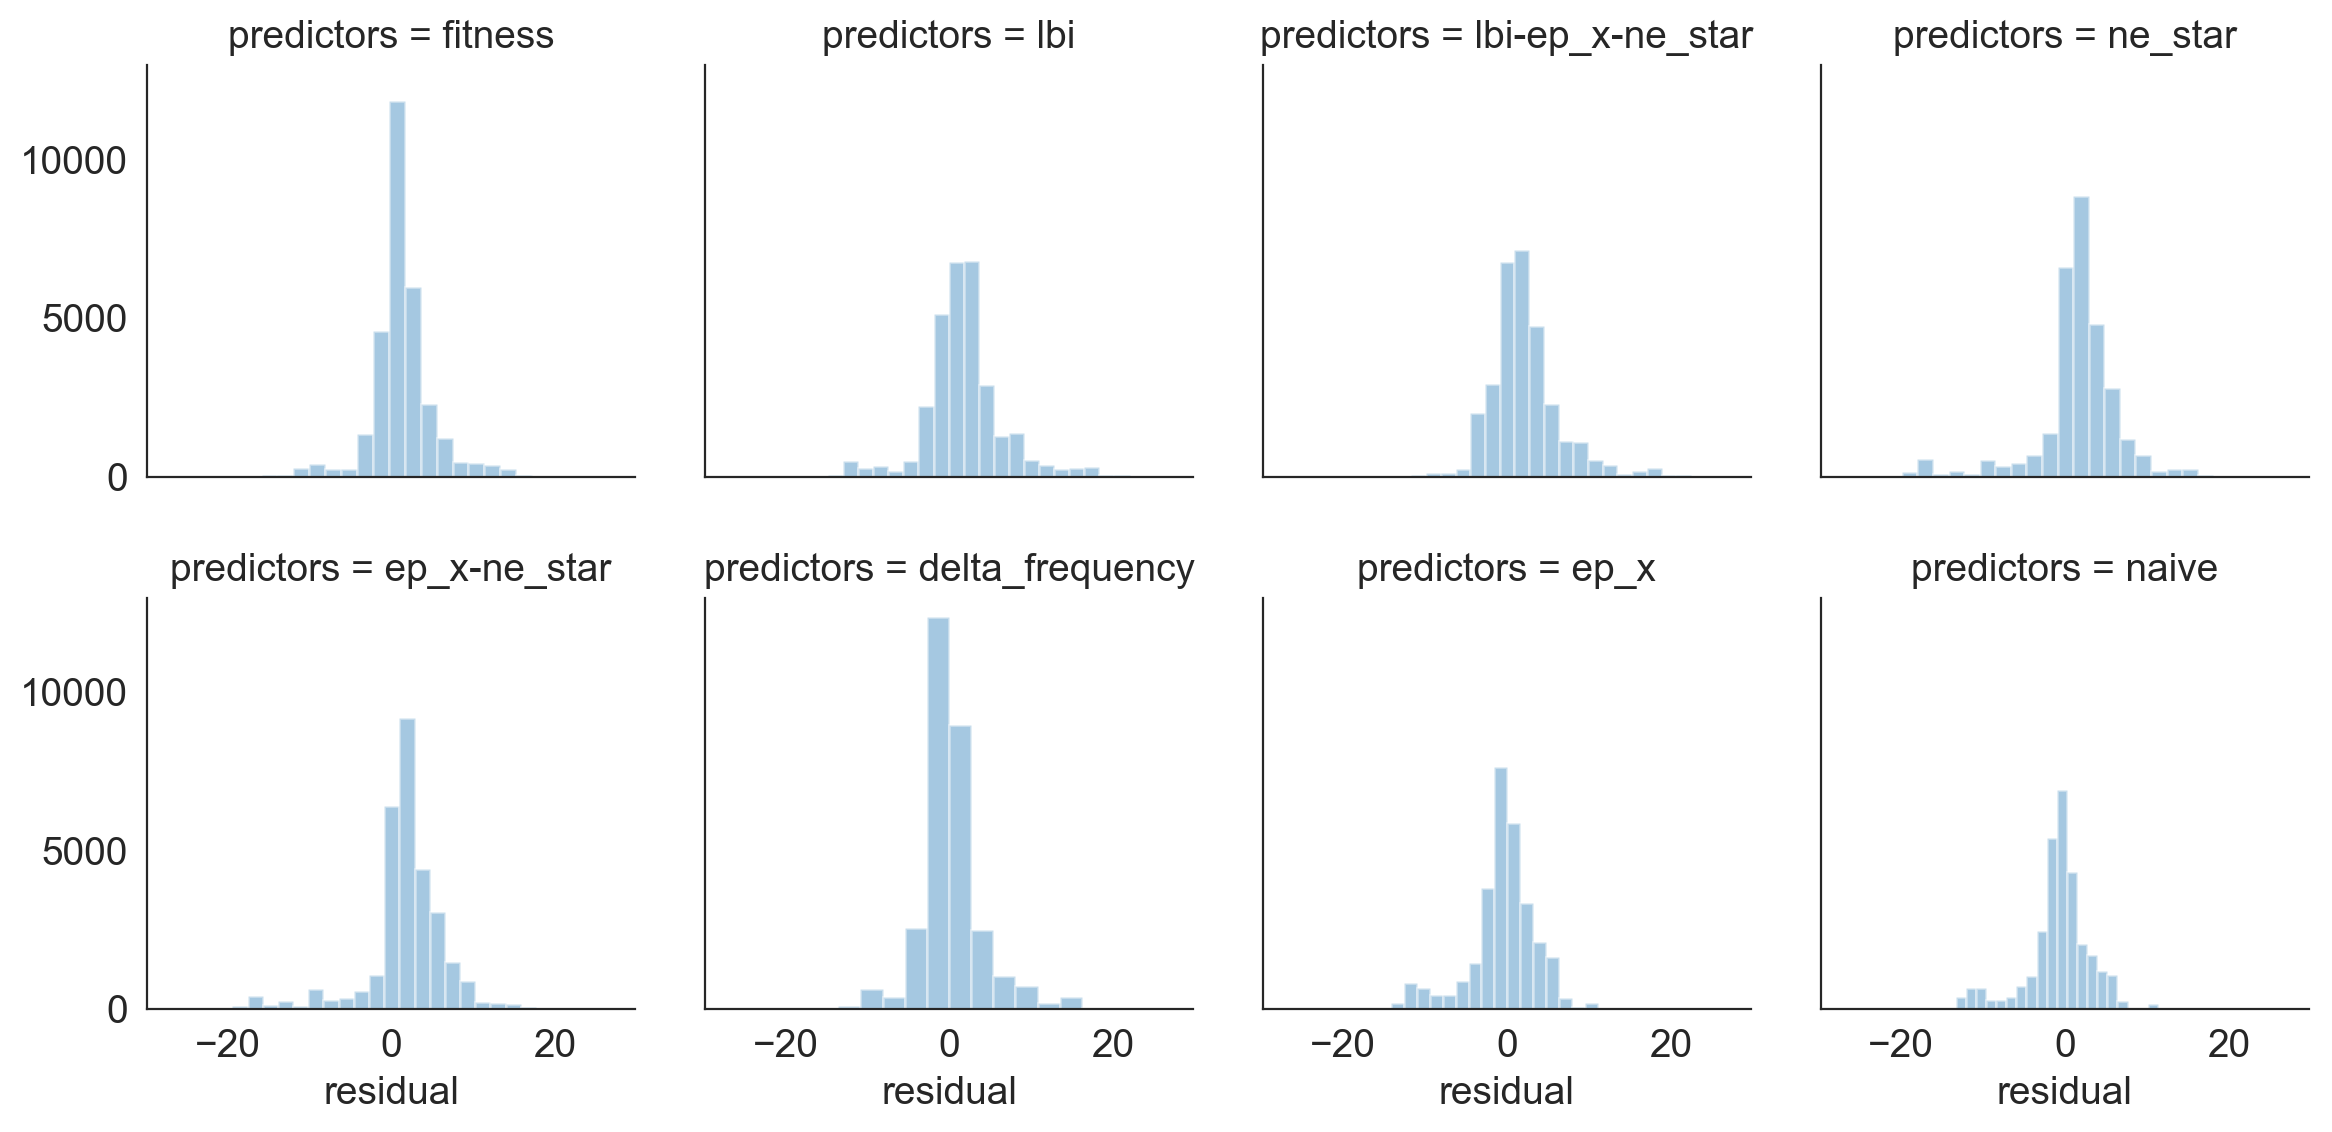

In [56]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [57]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive              -0.562112
ep_x               -0.271189
delta_frequency    -0.199273
fitness             0.960160
lbi                 1.535366
lbi-ep_x-ne_star    1.623507
ne_star             1.713690
ep_x-ne_star        1.779026
Name: residual, dtype: float64

In [58]:
residual_df.groupby("predictors")["residual"].count()

predictors
delta_frequency     30175
ep_x                30175
ep_x-ne_star        30175
fitness             30175
lbi                 30175
lbi-ep_x-ne_star    30175
naive               30175
ne_star             30175
Name: residual, dtype: int64

In [59]:
(residual_df["residual"] < -0.01).sum()

89925

### Residuals by timepoint

In [60]:
residuals_by_timepoint.head()

predictors  timepoint    residual
0  delta_frequency 2011-10-01  -73.814208
1  delta_frequency 2012-04-01 -378.314987
2  delta_frequency 2012-10-01   56.984596
3  delta_frequency 2013-04-01  352.048293
4  delta_frequency 2013-10-01  393.815881

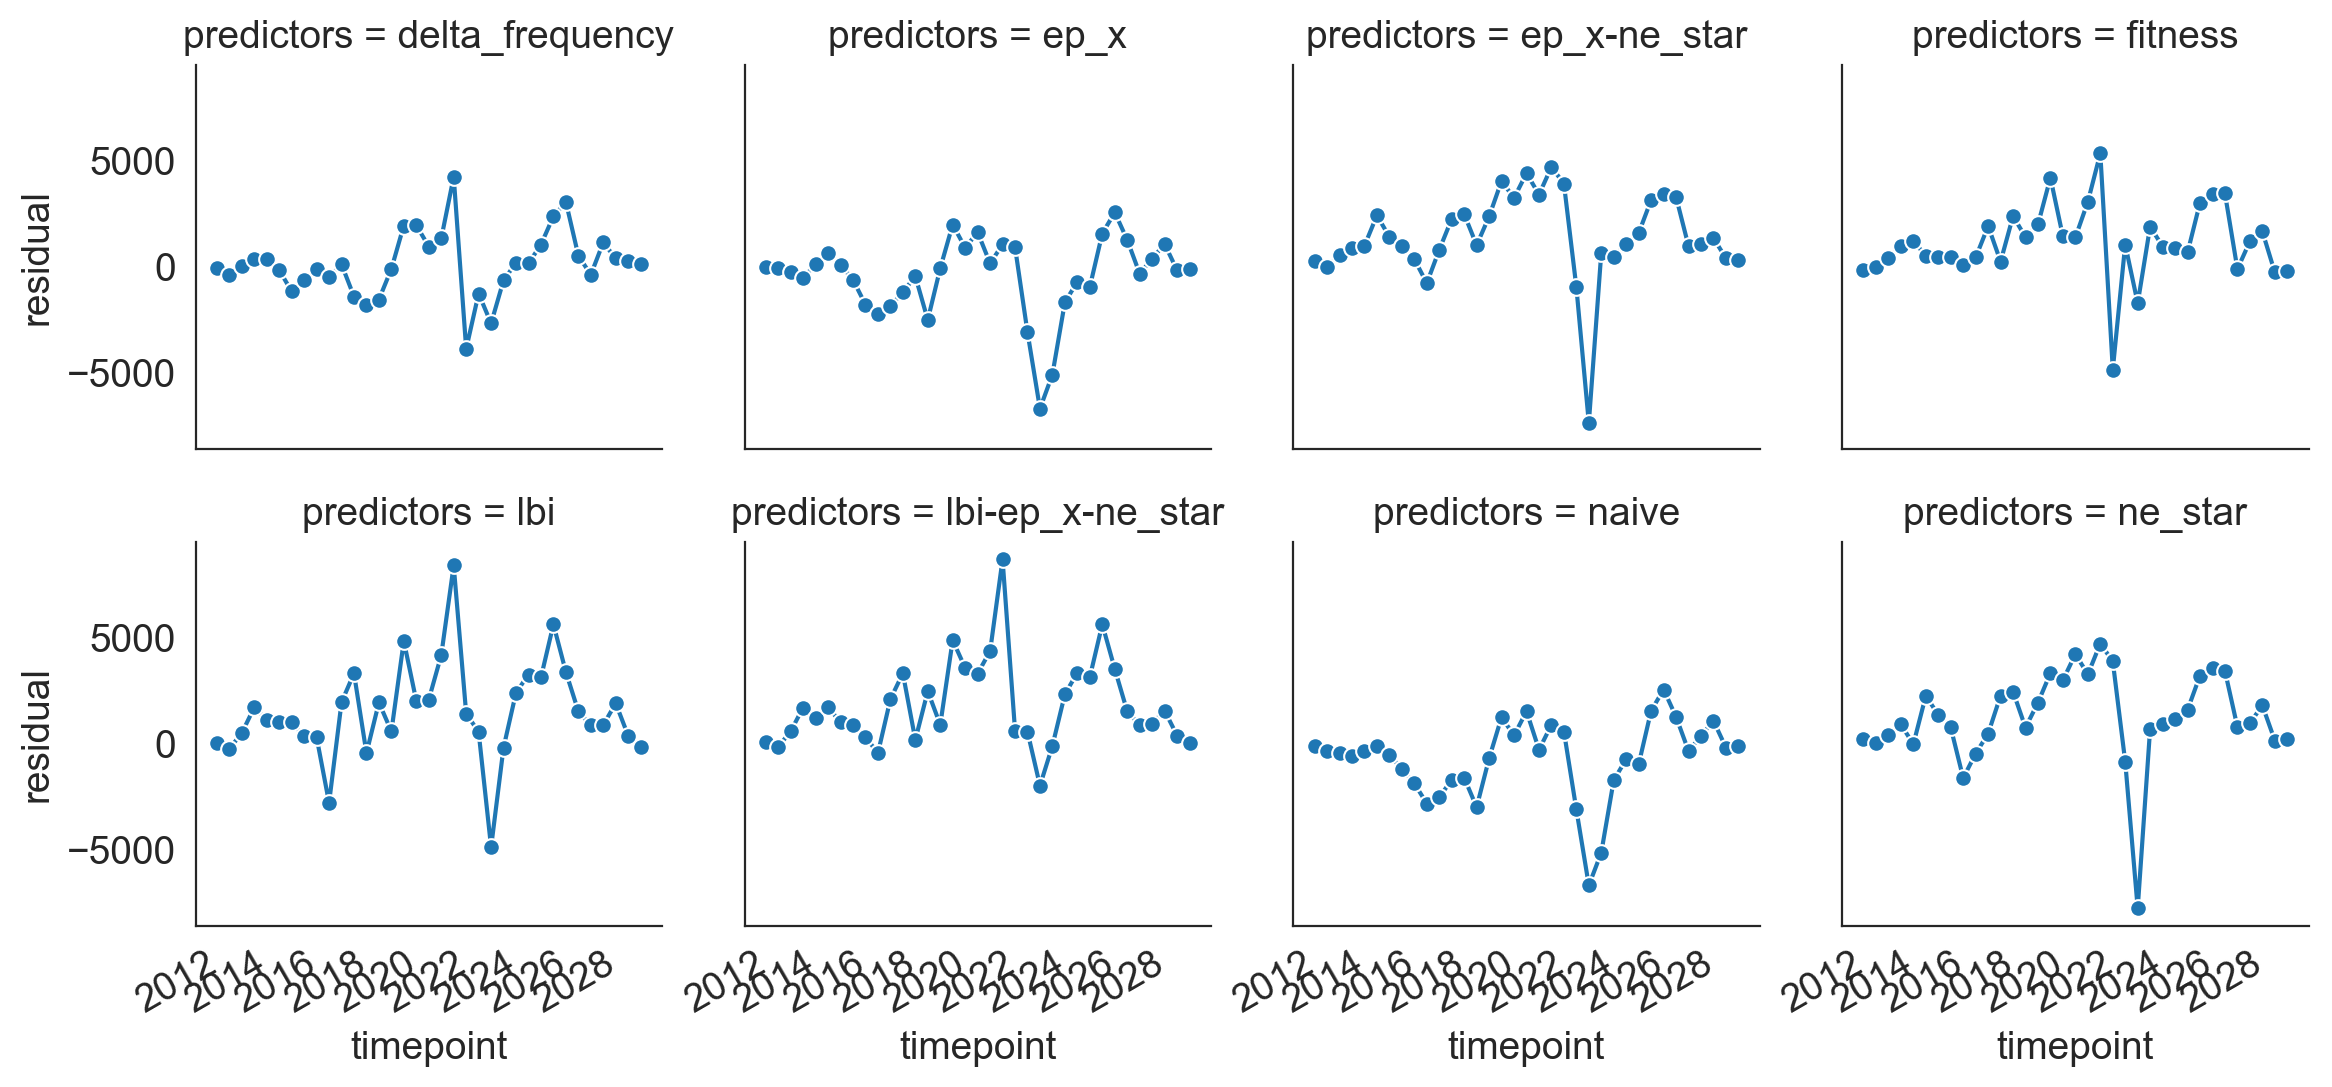

In [61]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [62]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([ 162.74405916,  104.68447046,  956.83664717, 2301.47406056,
       1467.79894408, 1131.51779416, 1558.64729258, 1536.53704769,
       2184.90850669,   32.04169932, 4499.78063415, 5029.87481849,
       1166.93223328, 4952.14390433, 1274.1884683 , 3604.39483173,
       1635.43962407,  550.87180411, 4478.91047086, 7537.95826476,
        847.49192802, 3668.37339129, 1803.12514421, 4963.61692707,
       4137.95467429, 3995.83528552, 4100.81443144, 4082.02638776,
        825.80745129,  262.15629025, 1210.49369978,  522.66031548,
        828.06655792,  560.43980199,   50.01350192])

### Autocorrelation of residuals

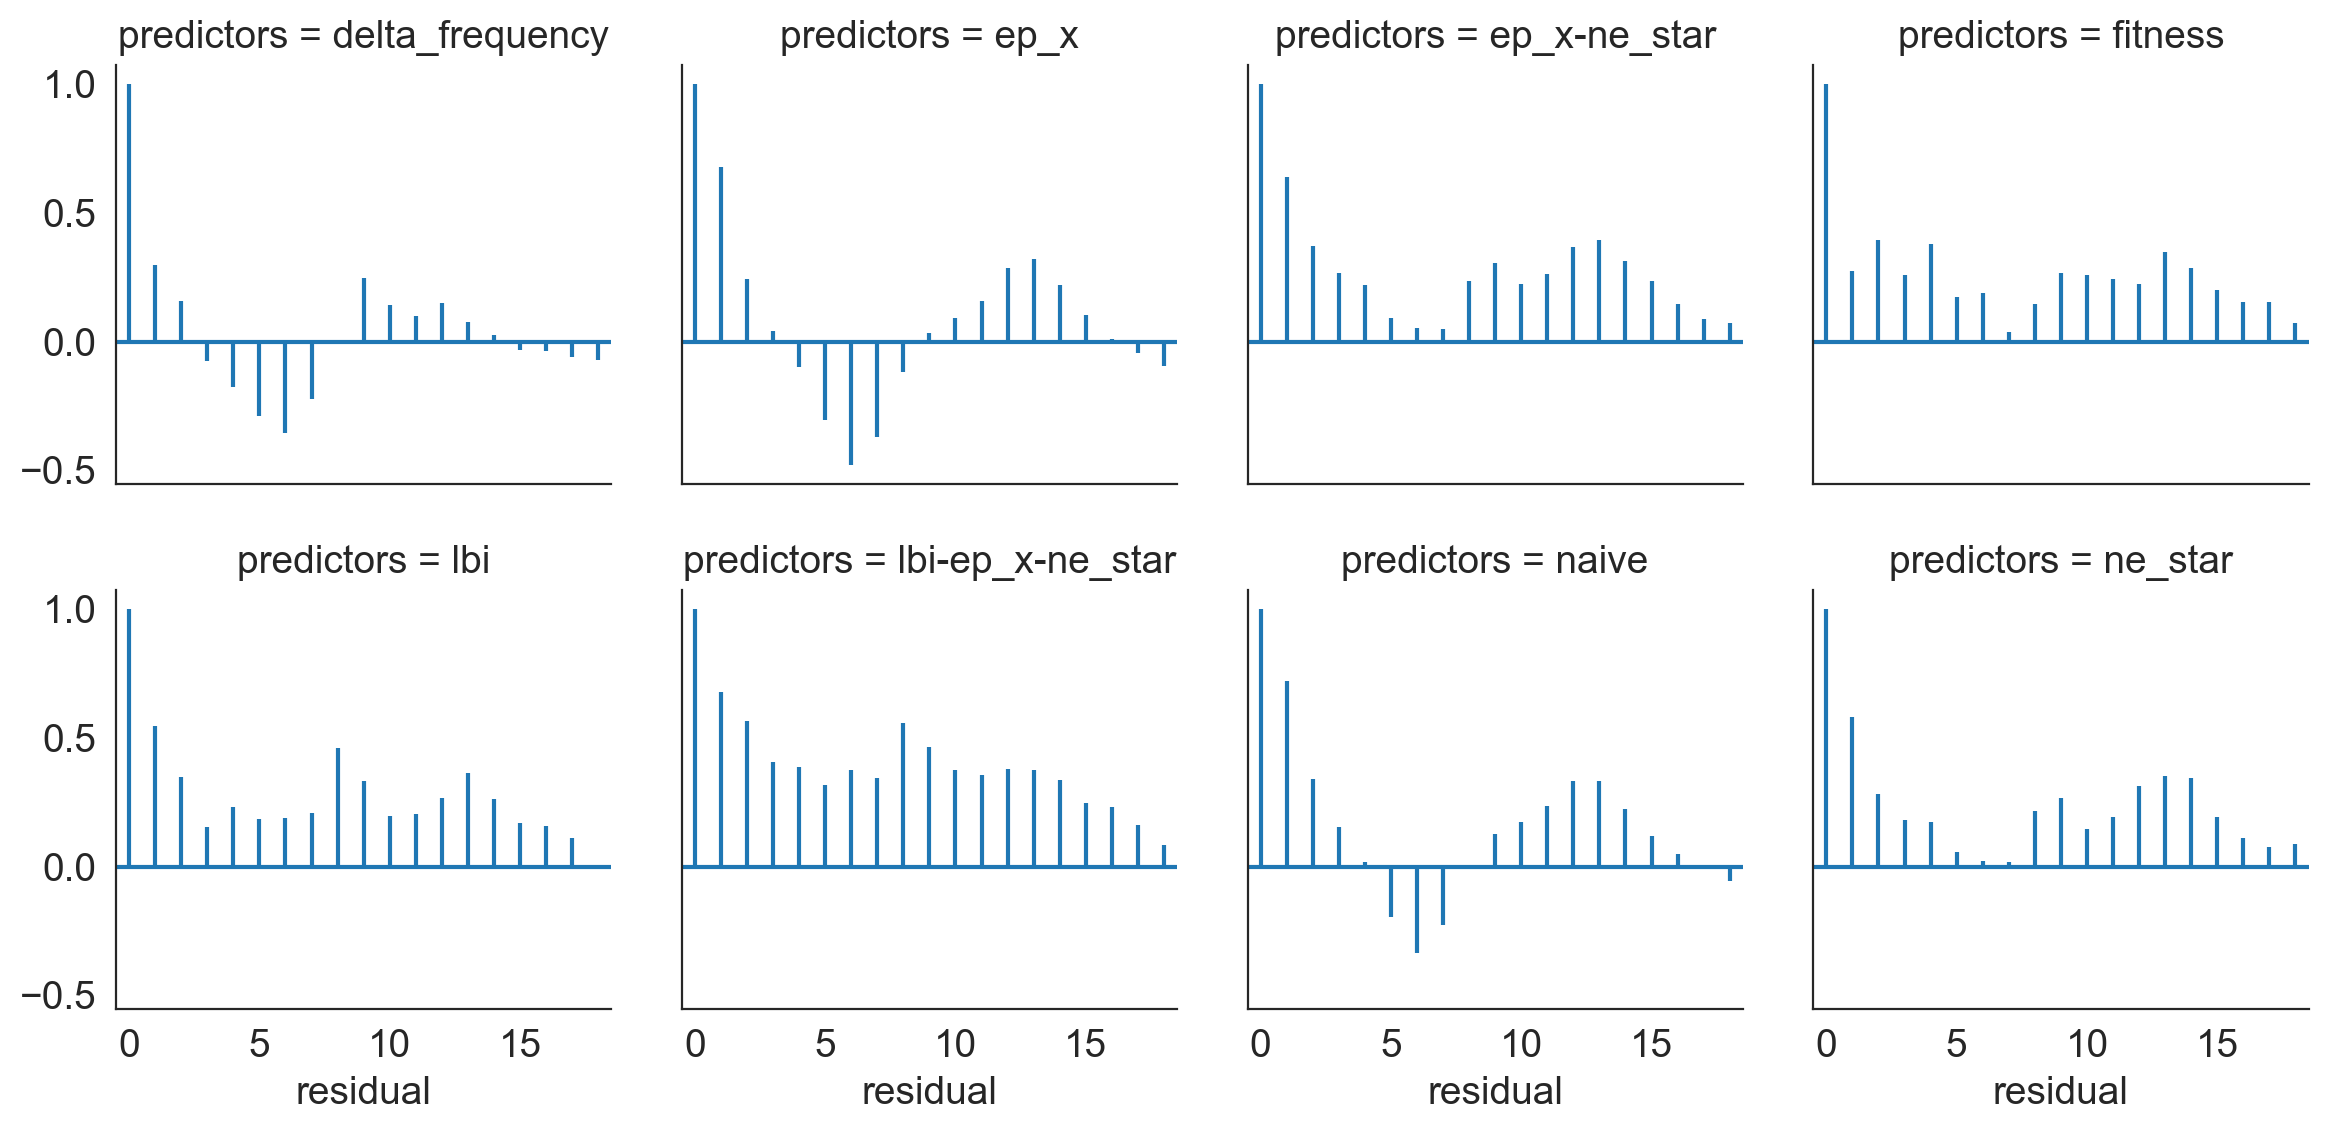

In [63]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted distances
[back to top](#Summarize-models)

$$
d_{i}(x(t)) = \sum_{j}x_{j}d_{ij}
$$

$$
u = t + \Delta{t}
$$

$$
\hat{x}_{i}(t, u) = x_{i}(t)e^{(f_{i}(t)(u - t))}
$$

$$
y = d_{i}(x(u))
$$

$$
\hat{y} = d_{i}(\hat{x}(t, u))
$$

$$
D(x(t), x(u)) = \sum_{i}x_{i}d_{i}(u)
$$

$$
D(\hat{x}(t, u), x(u)) = \sum_{i}x_{i}e^{(f_{i}(t)(u - t))}d_{i}(u)
$$

$$
L = \sum_{t}D(\hat{x}(t, u), x(u))
$$

In [64]:
frequency_df["observed_rank"] = frequency_df["y"] # / frequency_df["frequency"]
frequency_df["estimated_rank"] = frequency_df["y_hat"] # / frequency_df["frequency"]

In [65]:
regressions = []
for predictors, group_df in frequency_df.groupby(["predictors"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions.append({
        "predictors": predictors,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "r_2": r_value ** 2,
        "p_value": p_value
    })

regressions = pd.DataFrame(regressions).sort_values(by="r_2", ascending=False)

In [66]:
regressions_order = regressions["predictors"].values

In [67]:
regressions_order

array(['delta_frequency', 'naive', 'lbi', 'fitness', 'lbi-ep_x-ne_star',
       'ne_star', 'ep_x', 'ep_x-ne_star'], dtype=object)

In [68]:
max_y = max(frequency_df["y"].max() + frequency_df["y"].std(), frequency_df["y_hat"].max() + frequency_df["y_hat"].std())

In [69]:
data_to_plot = frequency_df[frequency_df["predictors"] == "lbi"]

In [70]:
minimum_observed_distance = data_to_plot.groupby("validation_timepoint")["observed_rank"].min().reset_index()

In [71]:
minimum_estimated_distance = data_to_plot.groupby("validation_timepoint")["estimated_rank"].min().reset_index()

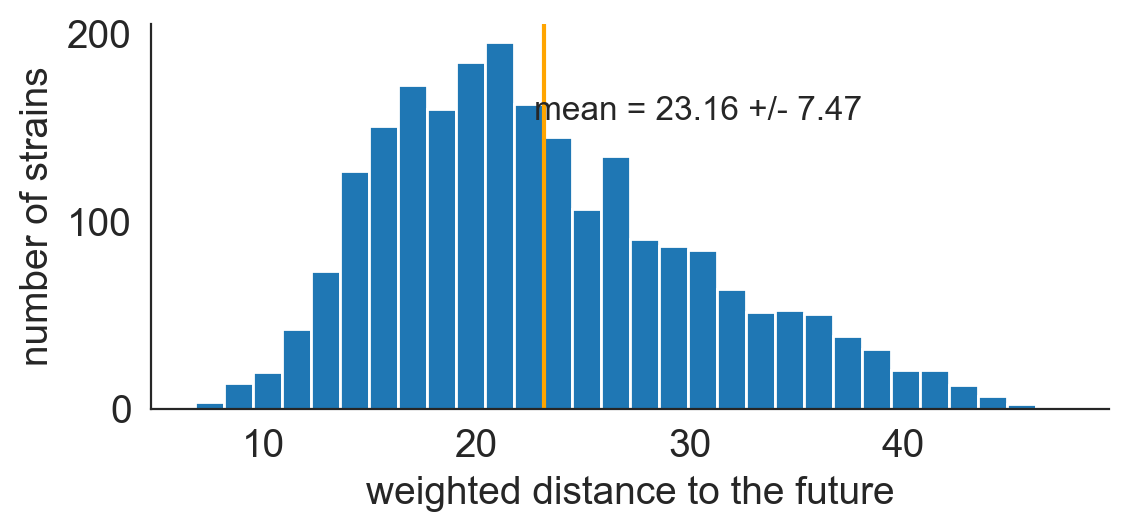

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(frequency_df[frequency_df["predictors"] == "naive"]["y"], bins=30)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of strains")

mean_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].mean()
std_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.4,
    0.75,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/weighted-distance-of-strains-between-timepoints.png")

In [73]:
best_overall_error_record = overall_errors_df.sort_values("cv_error_mean").values[0]
best_overall_error = best_overall_error_record[0]
best_overall_error_model = best_overall_error_record[-1]

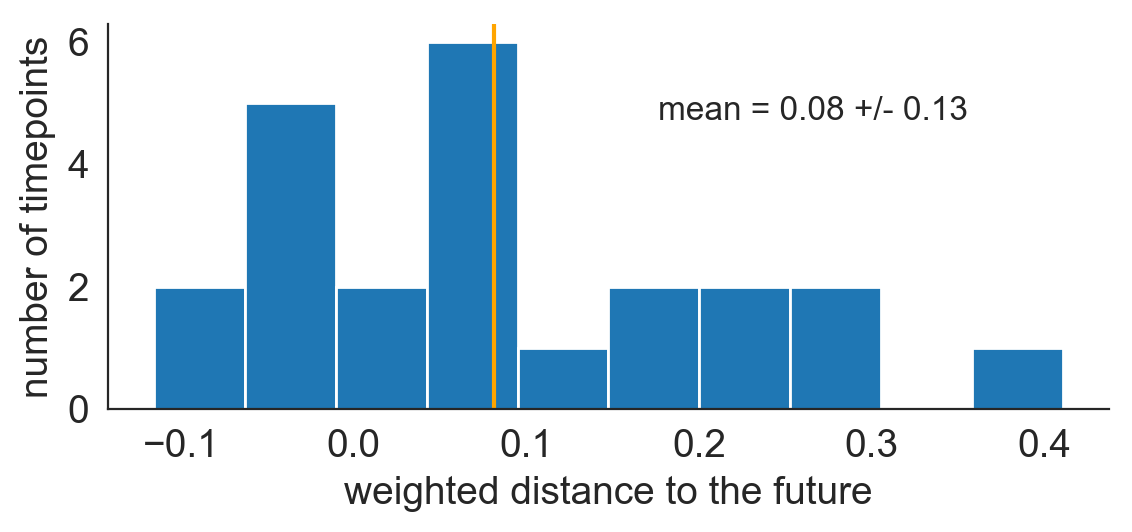

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"], bins=10)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].mean()
std_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.55,
    0.75,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

In [75]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].shape

(23,)

In [76]:
sum(errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"] <= 0.0)

9

In [77]:
sum(errors_by_time_df[errors_by_time_df["predictors"] == "lbi"]["validation_error"] <= 0.0)

18

Text(0.01,0.75,'best mean = -0.12')

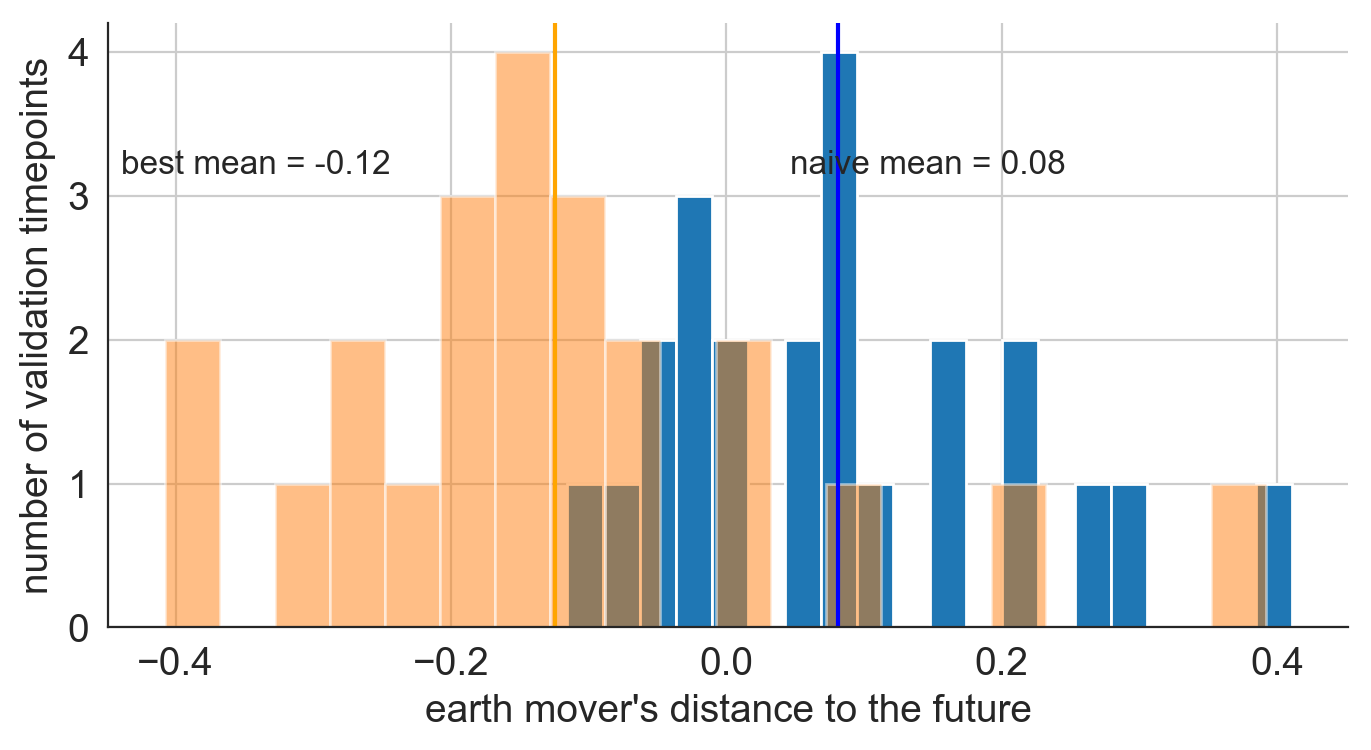

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].hist(bins=20, ax=ax)
ax.set_xlabel("earth mover's distance to the future")
ax.set_ylabel("number of validation timepoints")

mean_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].mean()
ax.axvline(
    x=mean_y,
    color="blue"
)

ax.text(
    0.55,
    0.75,
    "naive mean = %.2f" % (mean_y,),
    transform=ax.transAxes,
    fontsize=12
)

errors_by_time_df[errors_by_time_df["predictors"] == best_overall_error_model]["validation_error"].hist(
    bins=20,
    ax=ax,
    alpha=0.5
)
ax.axvline(
    x=best_overall_error,
    color="orange"
)
ax.text(
    0.01,
    0.75,
    "best mean = %.2f" % (best_overall_error,),
    transform=ax.transAxes,
    fontsize=12
)


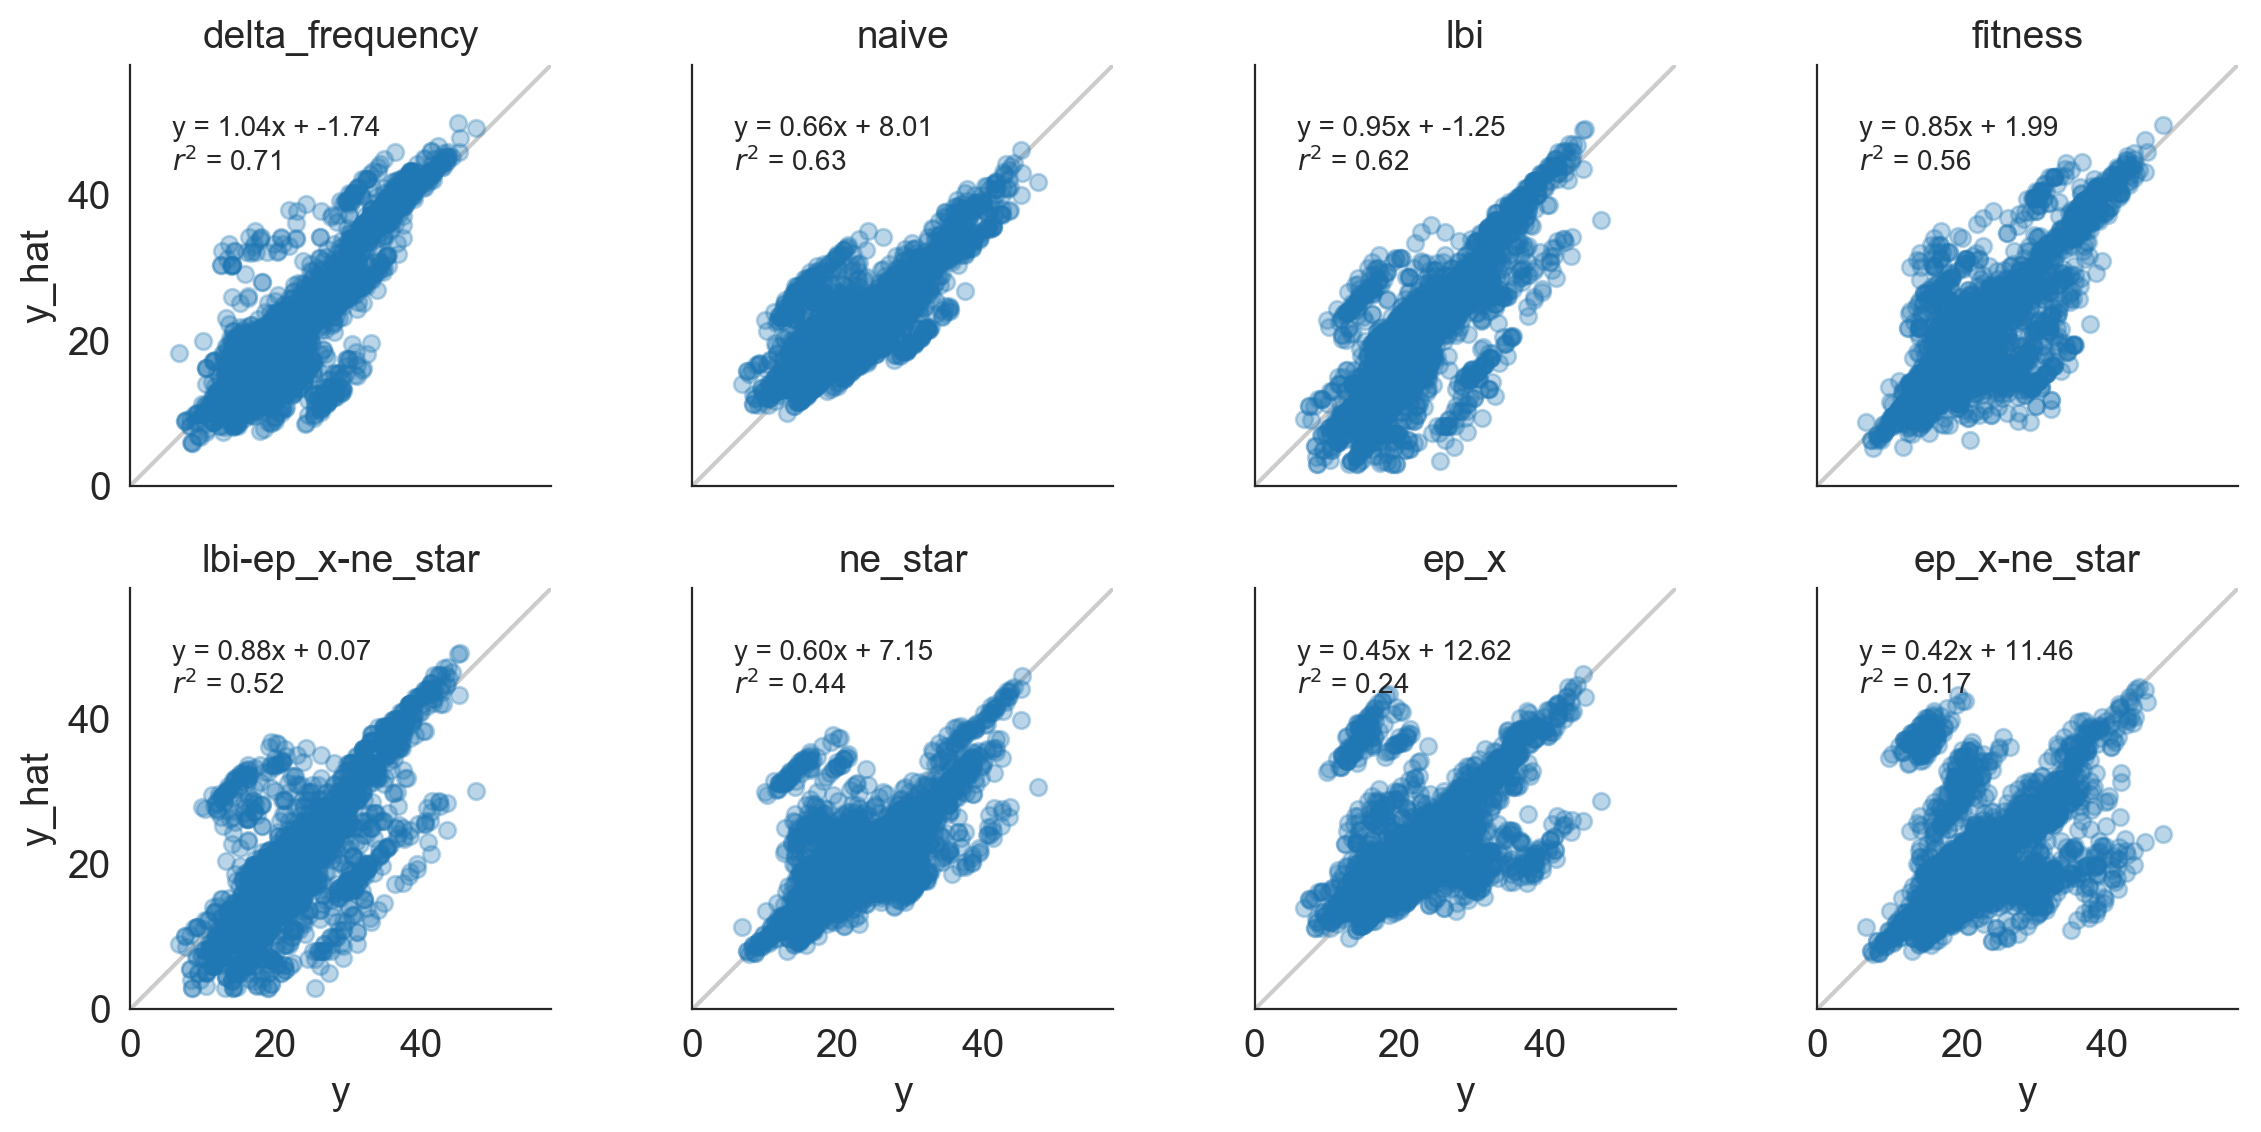

In [79]:
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4, col_order=regressions_order)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value = regressions.loc[
        regressions["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)

In [80]:
naive_y = frequency_df.loc[frequency_df["predictors"] == "naive", ["strain", "timepoint", "y_hat"]].copy()

In [81]:
naive_y.head()

strain  timepoint      y_hat
16219   sample_1792_4 2018-10-01  16.981512
16220   sample_1792_6 2018-10-01  17.881259
16221   sample_1796_1 2018-10-01  19.706829
16222  sample_1796_10 2018-10-01  20.413503
16223   sample_1796_2 2018-10-01  16.392557

In [82]:
frequency_df = frequency_df.merge(
    naive_y,
    on=["strain", "timepoint"],
    suffixes=["", "_naive"]
)

In [83]:
frequency_df["adjusted_y_hat"] = frequency_df["y_hat"] - frequency_df["y_hat_naive"]

In [84]:
frequency_df.shape

(18536, 17)

In [85]:
regressions_adjusted = []
for predictors, group_df in frequency_df.groupby(["predictors"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["adjusted_y_hat"]
    )
    
    regressions_adjusted.append({
        "predictors": predictors,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "r_2": r_value ** 2,
        "p_value": p_value
    })

regressions_adjusted = pd.DataFrame(regressions_adjusted).sort_values(by="r_2", ascending=False)

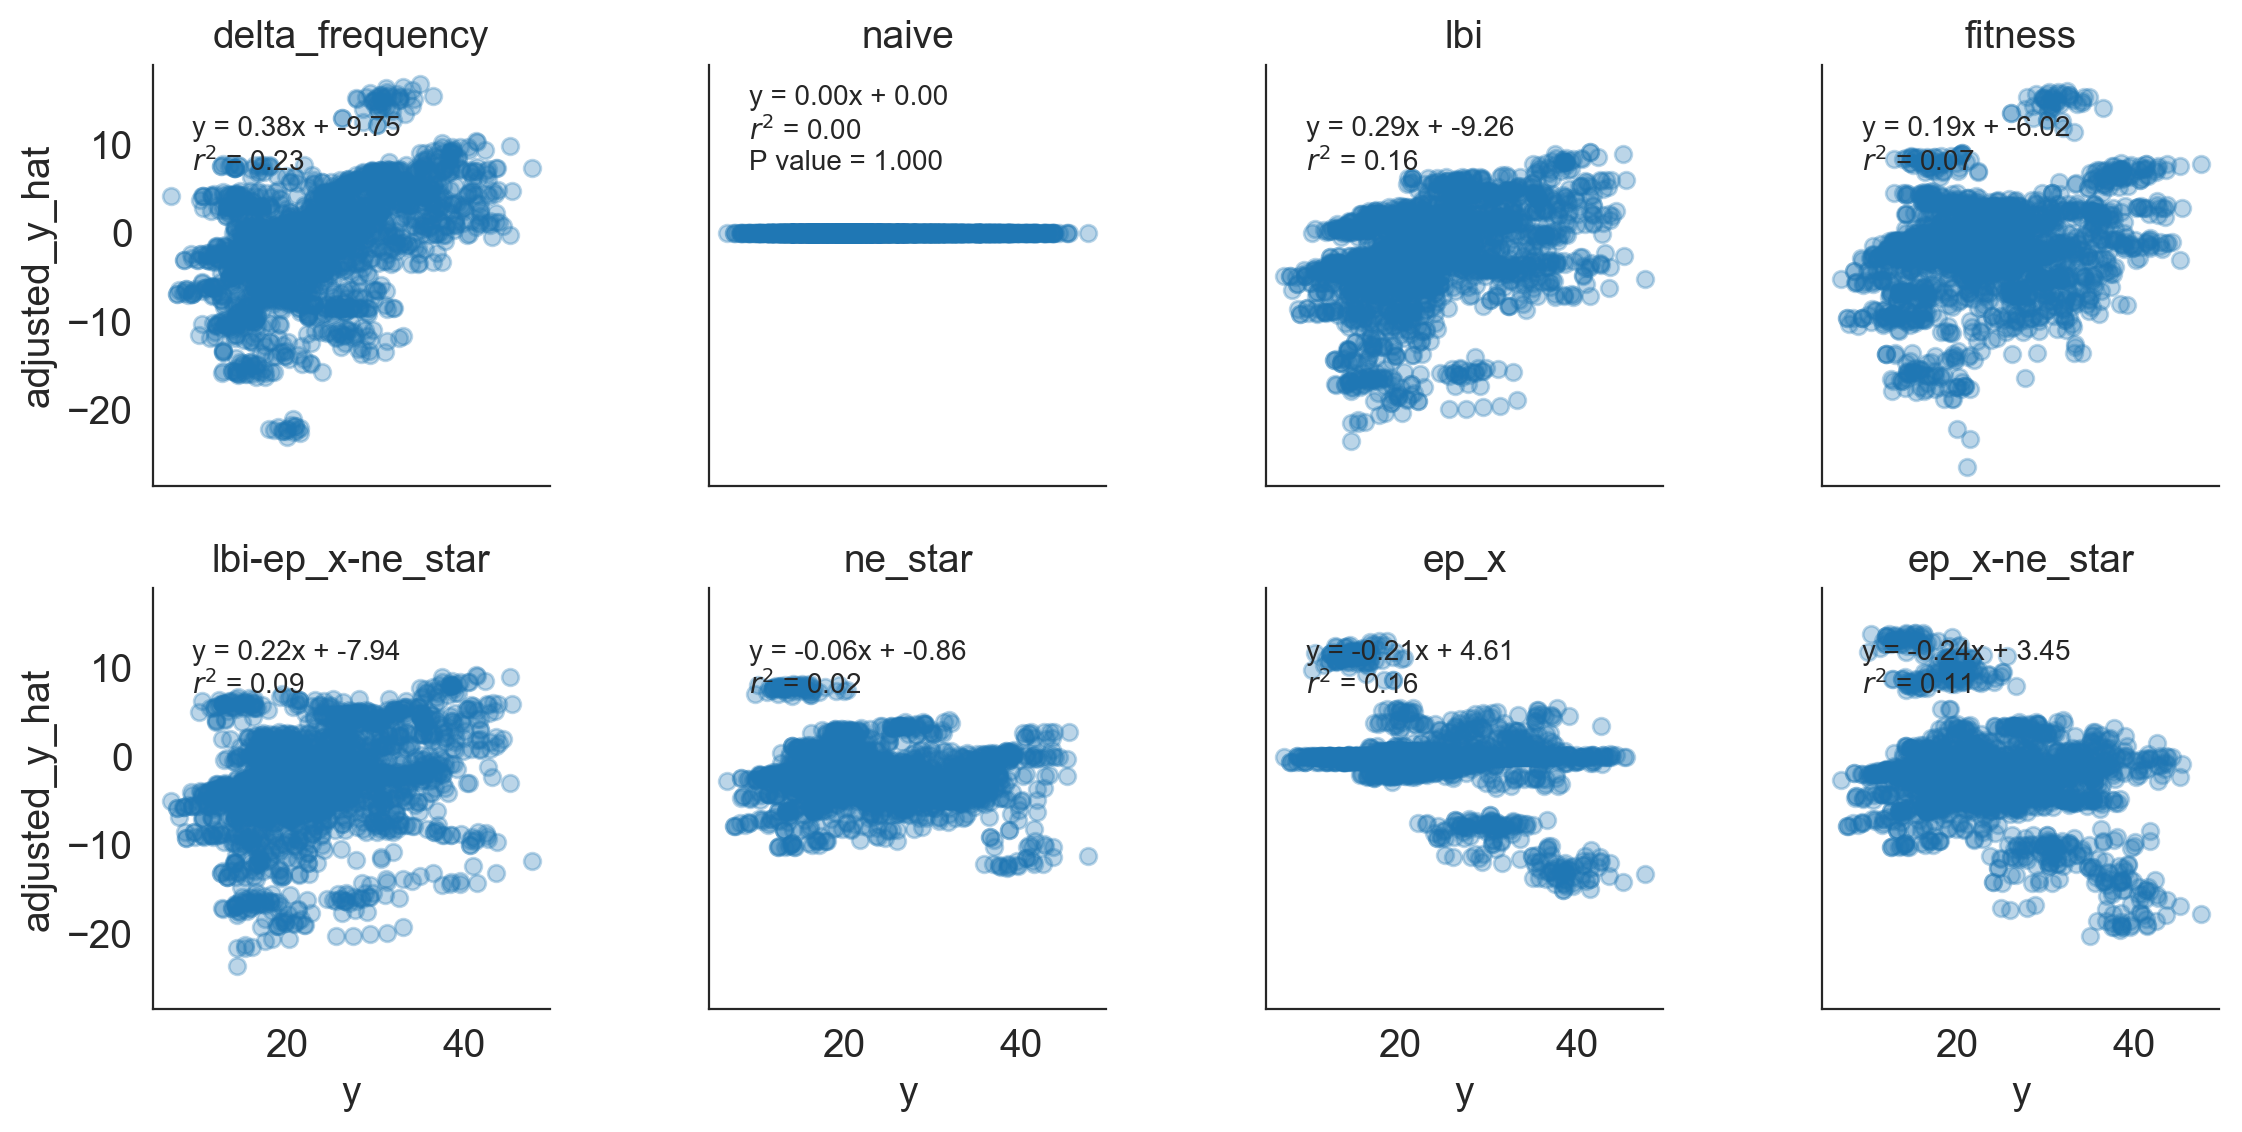

In [86]:
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4, col_order=regressions_order)
g.map(plt.plot, "y", "adjusted_y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value = regressions_adjusted.loc[
        regressions_adjusted["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    #ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    #ax.set_xlim(0, 10)
    #ax.set_ylim(0, )

In [87]:
best_models = list(regressions_order[:3])

In [88]:
if not "naive" in best_models:
    best_models.append("naive")

In [89]:
best_models

['delta_frequency', 'naive', 'lbi']

In [90]:
frequency_df["year_month"] = frequency_df["validation_timepoint"].dt.strftime("%Y-%m")
frequency_df["year"] = frequency_df["validation_timepoint"].dt.strftime("%Y")

In [91]:
"""x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(minimal_predictor_names_order + ["fitness"])], row="predictors", col="year_month", height=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{row_name}, {col_name}")

regressions_by_time = []
for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": facet_df["predictors"].unique()[0],
        "timepoint": facet_df["timepoint"].unique()[0],
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=12
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)
    
plt.tight_layout()
plt.savefig("correlation_by_timepoint.pdf")"""

'x = y = np.linspace(0, max_y, 10)\n\ng = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(minimal_predictor_names_order + ["fitness"])], row="predictors", col="year_month", height=4)\ng.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)\ng.set_titles("{row_name}, {col_name}")\n\nregressions_by_time = []\nfor ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):\n    slope, intercept, r_value, p_value, std_err = linregress(\n        facet_df["y"],\n        facet_df["y_hat"]\n    )\n    \n    regressions_by_time.append({\n        "predictors": facet_df["predictors"].unique()[0],\n        "timepoint": facet_df["timepoint"].unique()[0],\n        "slope": slope,\n        "intercept": intercept,\n        "r_value": r_value,\n        "p_value": p_value\n    })\n    \n    if p_value > 0.001:\n        p_value = "\nP value = %.3f" % p_value\n    else:\n        p_value = ""\n    \n    ax.plot(x, y, color="#cccccc", zorder=-10)\n    \n    ax.text(\n        0.1,\n 

In [92]:
regressions_by_time = []
for (predictors, timepoint), group_df in frequency_df.groupby(["predictors", "timepoint"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": predictors,
        "timepoint": timepoint,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })

regressions_by_time = pd.DataFrame(regressions_by_time)

In [93]:
regressions_by_time.head()

intercept       p_value       predictors   r_value     slope  timepoint
0   1.455183  4.029140e-26  delta_frequency  0.823580  0.899812 2018-10-01
1  -4.146214  1.234033e-36  delta_frequency  0.893956  1.125740 2019-04-01
2  -9.105575  2.022674e-10  delta_frequency  0.585080  1.324367 2019-10-01
3 -10.111757  2.854825e-20  delta_frequency  0.762912  1.355859 2020-04-01
4 -13.941718  2.050084e-41  delta_frequency  0.915839  1.473110 2020-10-01

In [94]:
naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] == "naive"]
non_naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] != "naive"]

## Summarize model forecasting error
[back to top](#Summarize-models)

### Earth mover's distances

Training and validation errors are reported as [earth mover's distances](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). These values minimize the distance between observed and projected frequencies of tips at each timepoint with Hamming distance between amino acid sequences providing the ground distance between each pair of tips in respective timepoints.

In [95]:
distance_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [96]:
distance_df

predictors       sum      mean    median
0               lbi -2.858134 -0.124267 -0.146819
1  lbi-ep_x-ne_star -2.723785 -0.118425 -0.158980
2           fitness -1.416754 -0.061598 -0.072634
3   delta_frequency -1.270382 -0.055234 -0.109724
4           ne_star -0.317226 -0.013792 -0.050427
5      ep_x-ne_star  0.391226  0.017010 -0.042050
6             naive  1.865533  0.081110  0.073000
7              ep_x  2.470314  0.107405  0.065262

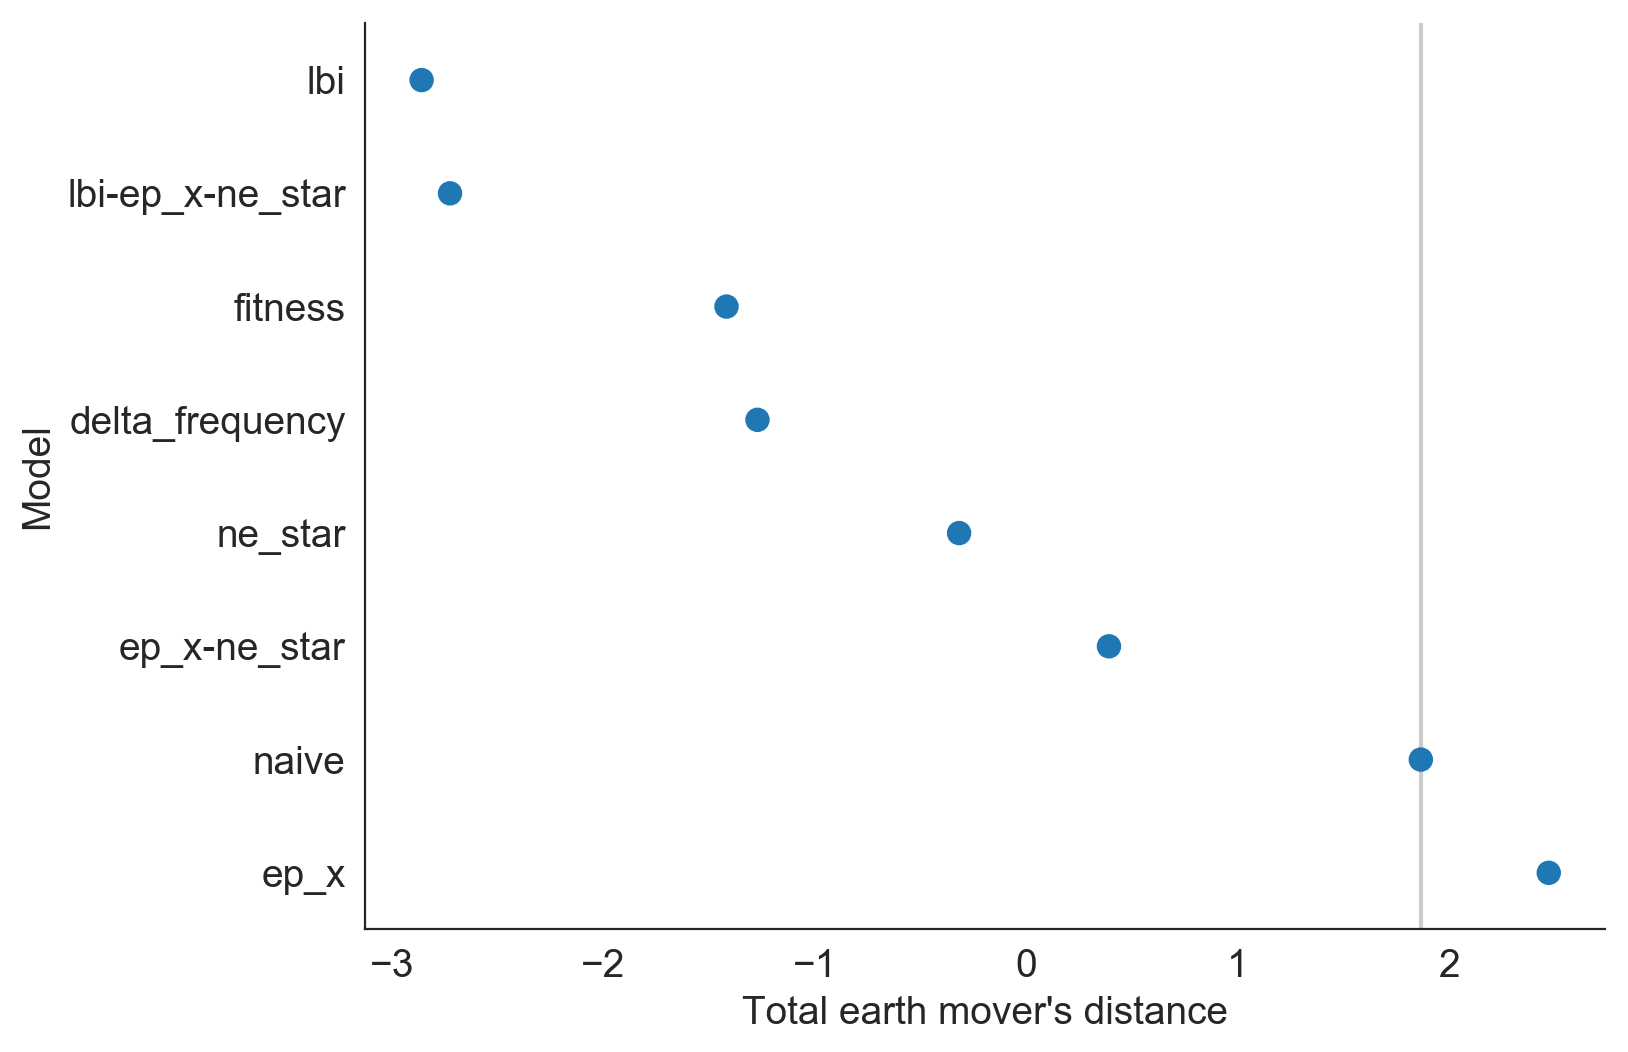

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="sum",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Total earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0],
    color="#cccccc",
    zorder=-10
)

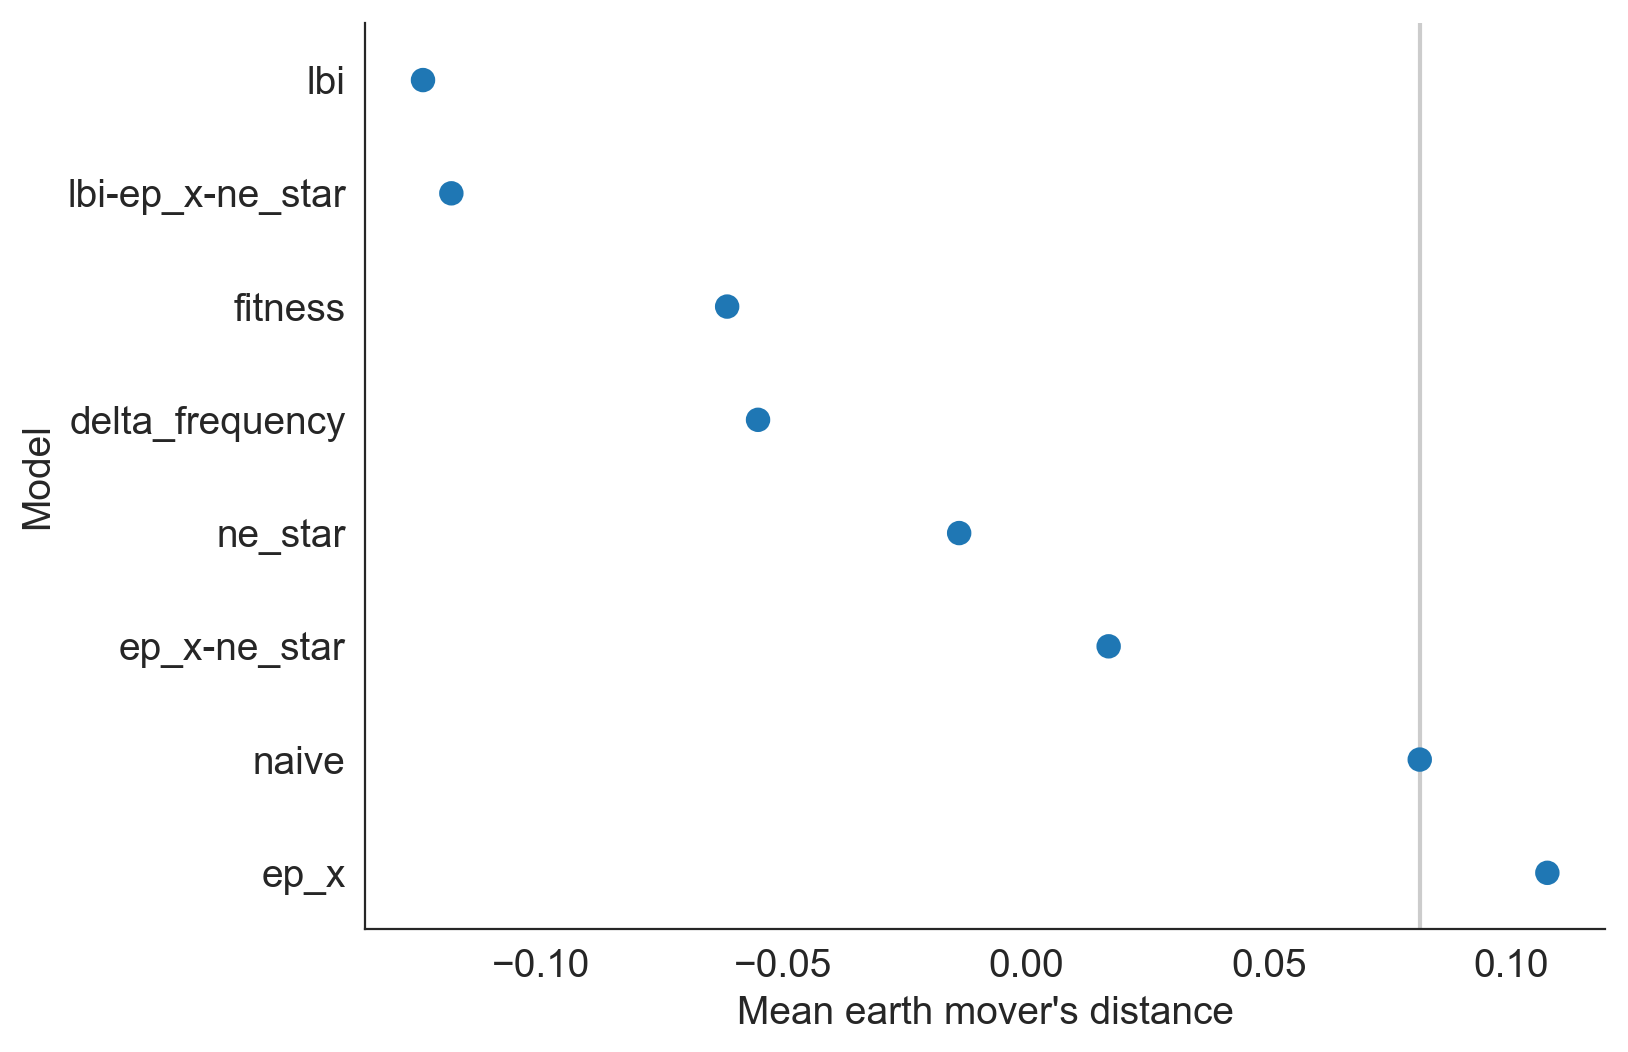

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Mean earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

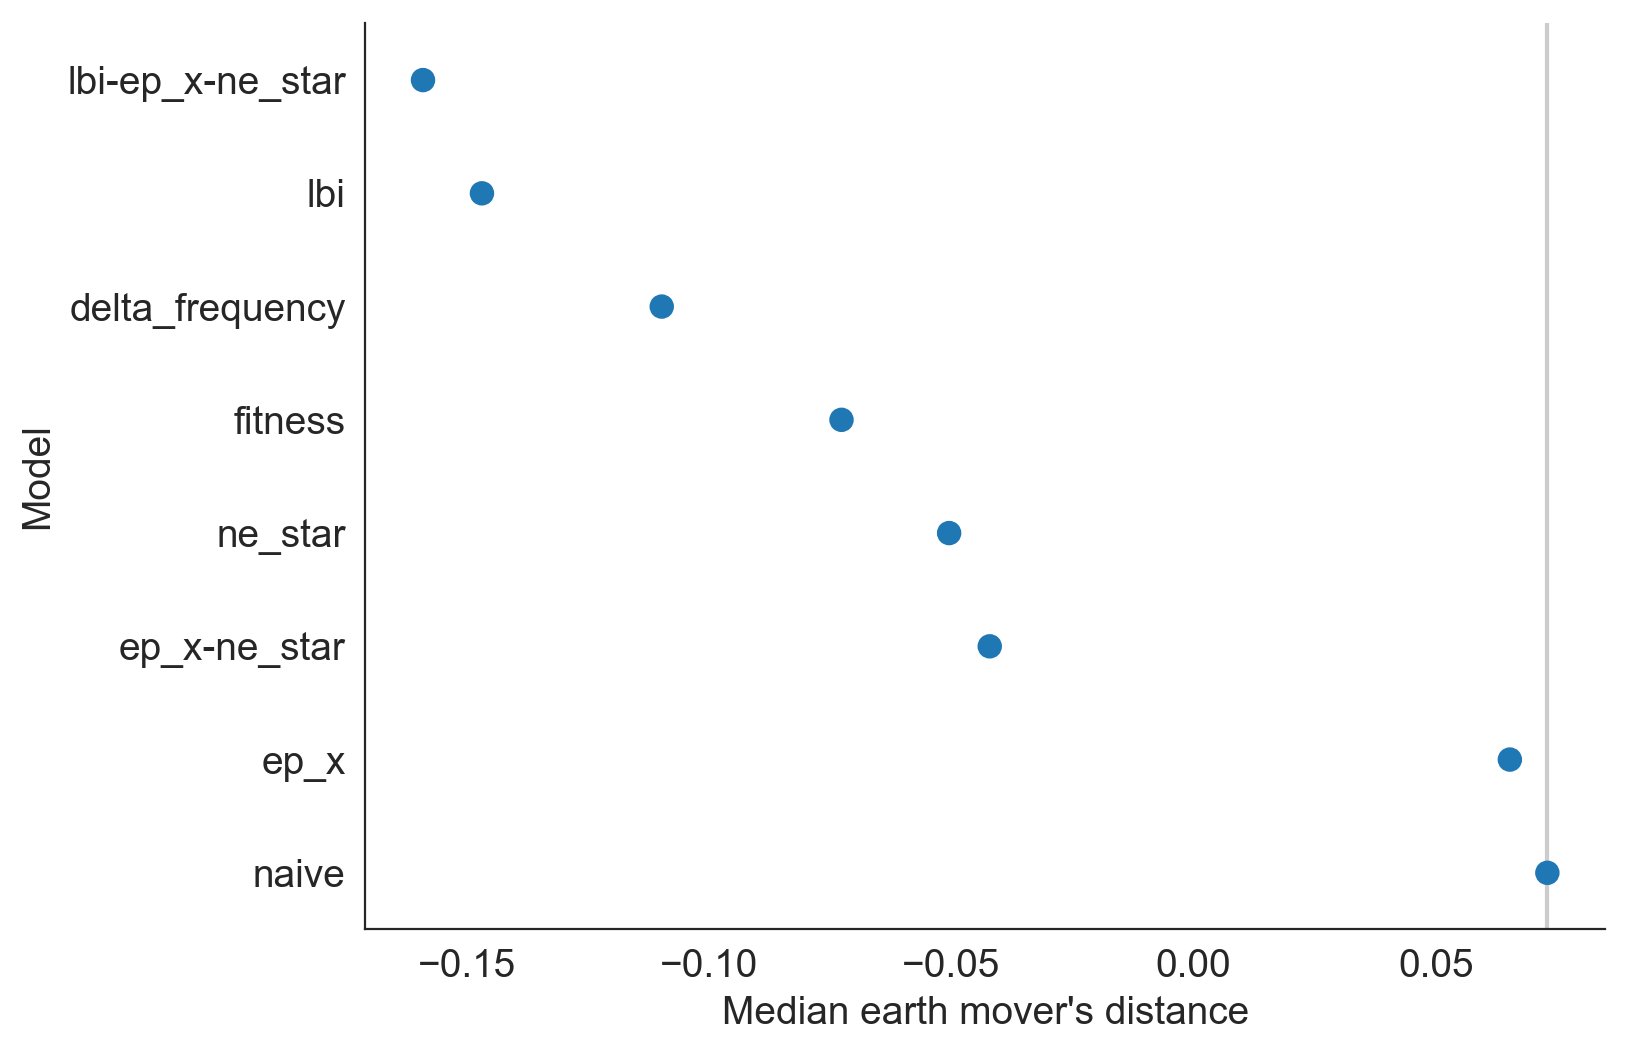

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Median earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

In [100]:
predictor_type_order = predictor_names_order
predictor_names = predictor_names_order

In [101]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [102]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [105]:
median_error = errors_by_time_df.groupby("predictors")["validation_error"].median().reset_index().sort_values(by="validation_error")
median_error_order = median_error["predictors"].values

In [106]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

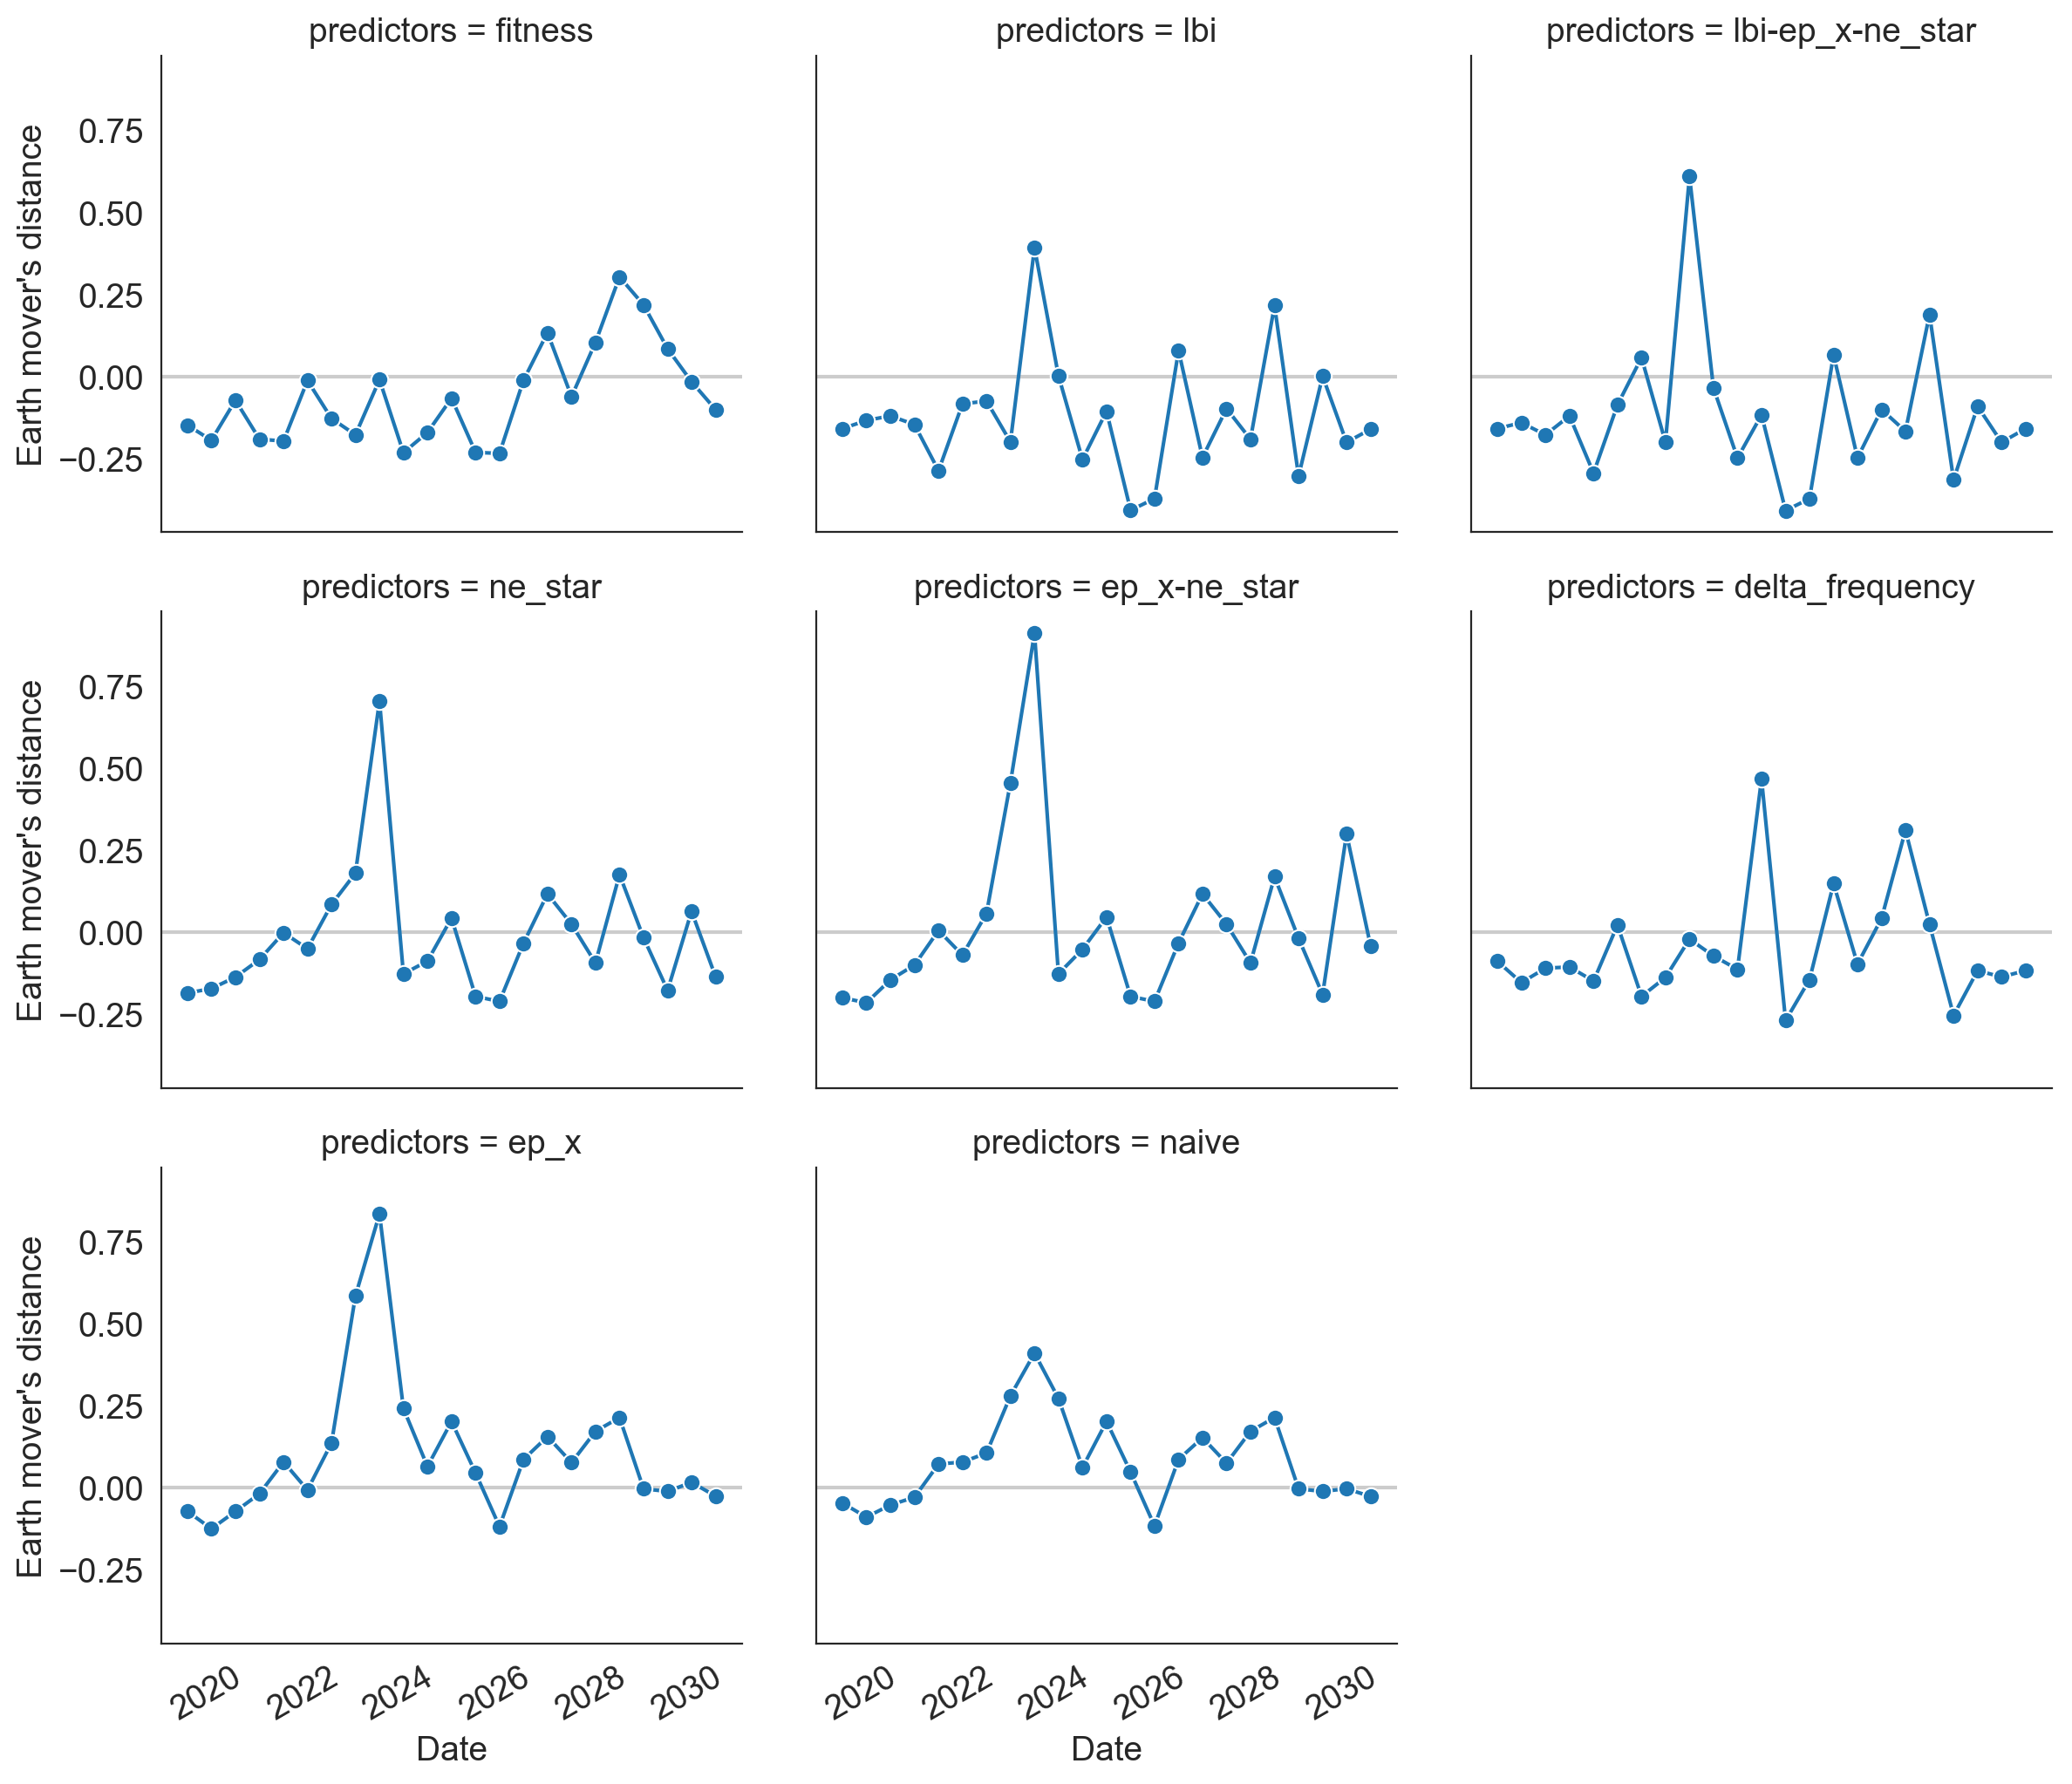

In [107]:
g = facet_time_plot(
    errors_by_time_df,
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    col_wrap=3,
    markersize=7
)

### Adjusted earth mover's distance (relative to naive model)

In [108]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    #adjusted_error = ((errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error) / naive_error) * 100
    adjusted_error = (errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error)
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = adjusted_error

In [109]:
naive_error

array([-0.04619616, -0.08897398, -0.05200914, -0.02845289,  0.0730003 ,
        0.07865127,  0.10645082,  0.28069385,  0.41088886,  0.27302107,
        0.06213482,  0.20267818,  0.04859819, -0.11559938,  0.08698623,
        0.15305275,  0.07549942,  0.17245407,  0.21450932, -0.0026428 ,
       -0.0106832 , -0.00238582, -0.02614297])

In [110]:
median_adjusted_error = errors_by_time_df.groupby("predictors")["adjusted_error"].median().reset_index().sort_values(by="adjusted_error")
median_adjusted_error_order = median_adjusted_error["predictors"].values

In [111]:
min_error = errors_by_time_df["adjusted_error"].min()

In [112]:
max_error = errors_by_time_df["adjusted_error"].max()

In [113]:
median_adjusted_error_order

array(['lbi', 'lbi-ep_x-ne_star', 'delta_frequency', 'fitness', 'ne_star',
       'ep_x-ne_star', 'naive', 'ep_x'], dtype=object)

In [114]:
median_adjusted_error.head()

predictors  adjusted_error
4               lbi       -0.181343
5  lbi-ep_x-ne_star       -0.176407
0   delta_frequency       -0.106303
3           fitness       -0.105770
7           ne_star       -0.095455

In [115]:
minimal_median_adjusted_error_order = [
    predictor for predictor in median_adjusted_error_order
    if predictor in minimal_predictor_names_order
]

Text(0,0.5,'Model')

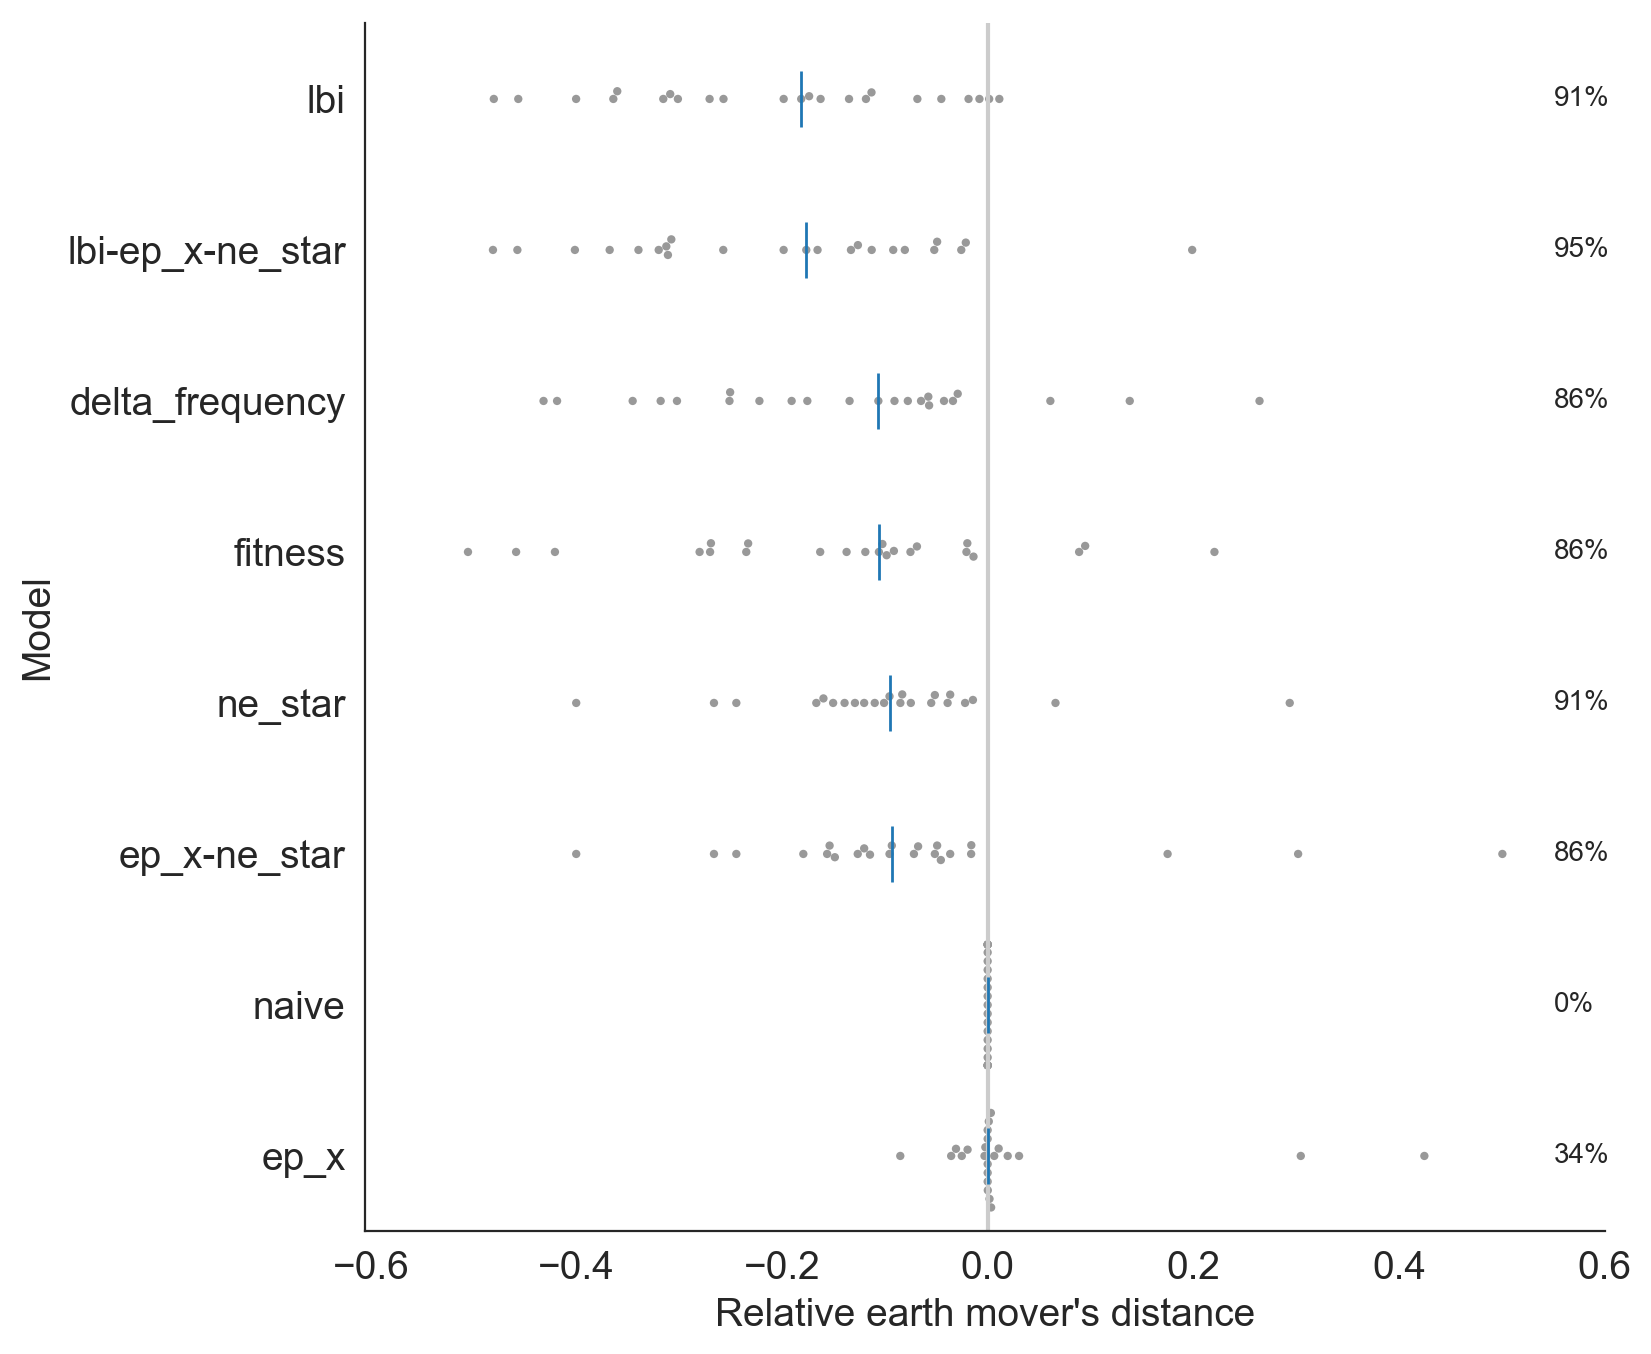

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlim(min_error - 0.1, max_error + 0.1)

ax = sns.swarmplot(
    x="adjusted_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_adjusted_error_order,
    color="#999999",
    zorder=-10,
    size=3
)

ax.plot(
    median_adjusted_error["adjusted_error"],
    median_adjusted_error_order,
    marker="|",
    markersize=20,
    linestyle=""
)


#ax.text(0.5, 0, "test")
for i, predictor in enumerate(median_adjusted_error_order):
    predictor_errors = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"]
    
    ax.text(
        max_error + 0.05,
        i,
        "%i%%" % (((predictor_errors < 0).sum() / float(predictor_errors.shape[0])) * 100),
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=10
    )

ax.axvline(x=0, color="#cccccc", zorder=-10)

ax.set_xlabel("Relative earth mover's distance")
ax.set_ylabel("Model")

In [117]:
errors_by_time_df.groupby("predictors")["adjusted_error"].aggregate(["mean", "std"])

mean       std
predictors                          
delta_frequency  -0.136344  0.170452
ep_x              0.026295  0.110627
ep_x-ne_star     -0.064100  0.184753
fitness          -0.142708  0.176310
lbi              -0.205377  0.150362
lbi-ep_x-ne_star -0.199536  0.165031
naive             0.000000  0.000000
ne_star          -0.094903  0.128069

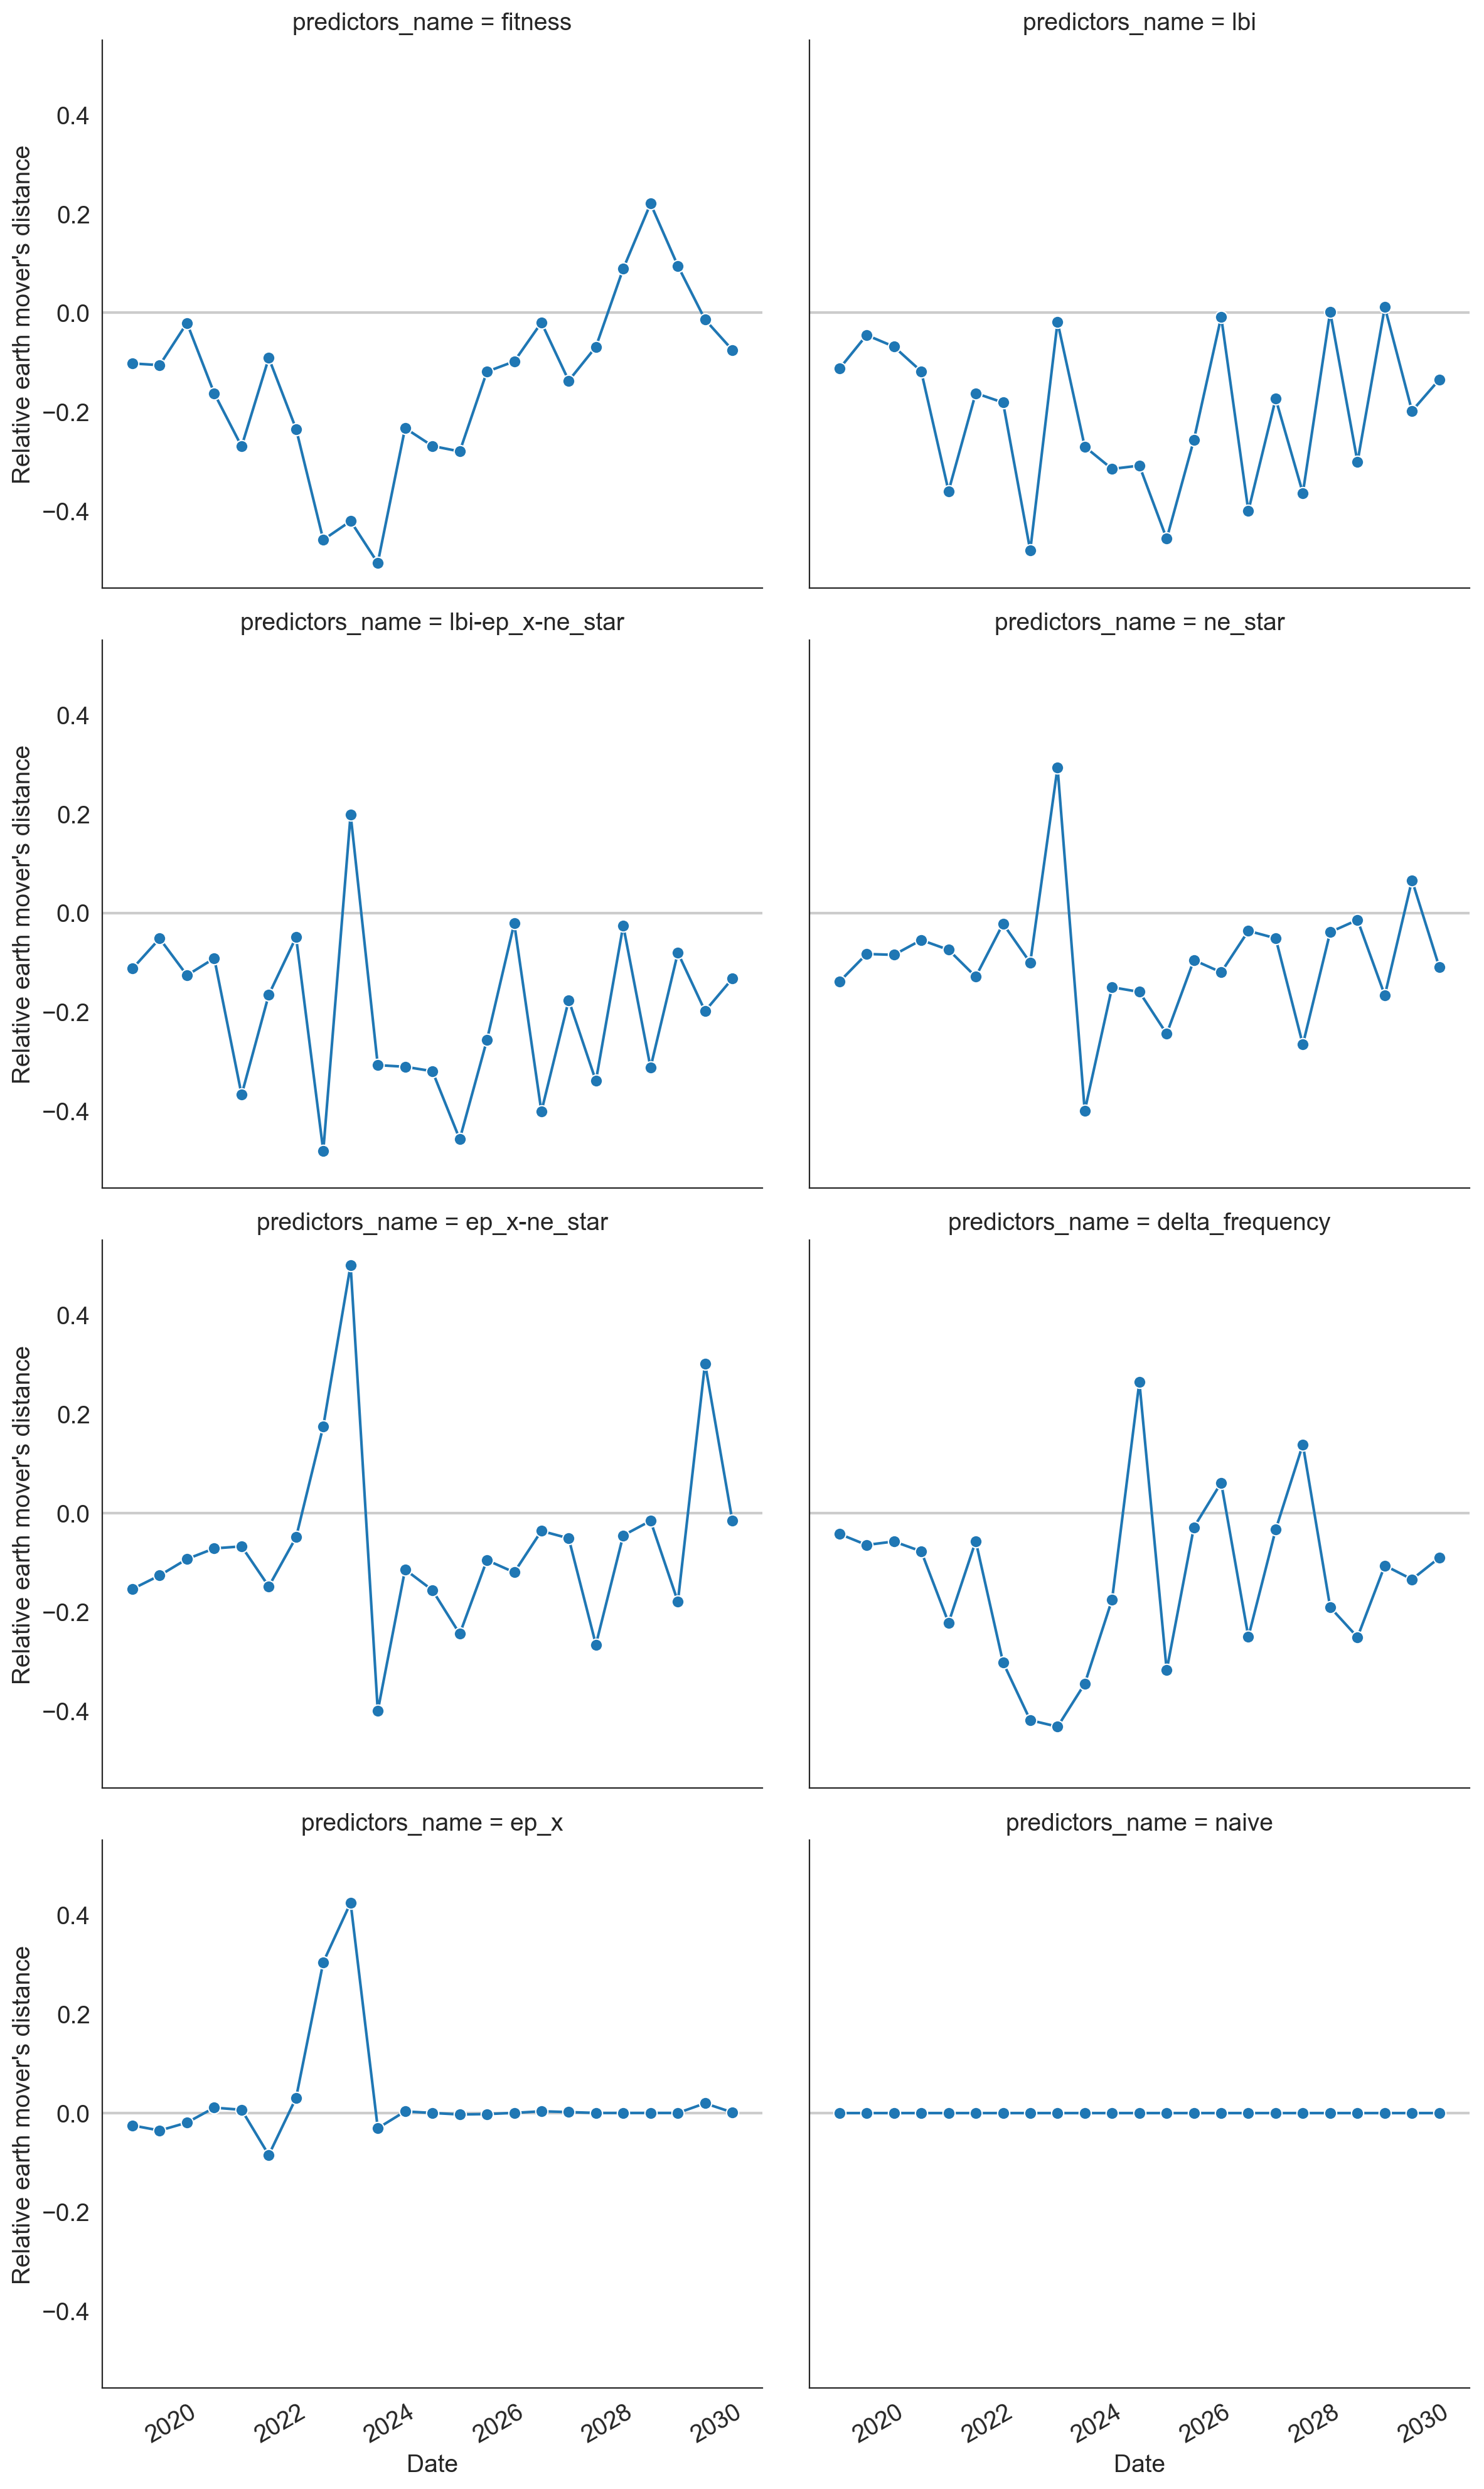

In [118]:
g = facet_time_plot(
    errors_by_time_df,
    "adjusted_error",
    "Relative earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1,
    col_wrap=2,
    markersize=7
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)

In [119]:
errors_and_coefficients_by_time = coefficients_by_time_df.merge(
    errors_by_time_df,
    on=["predictors", "validation_timepoint"]
)

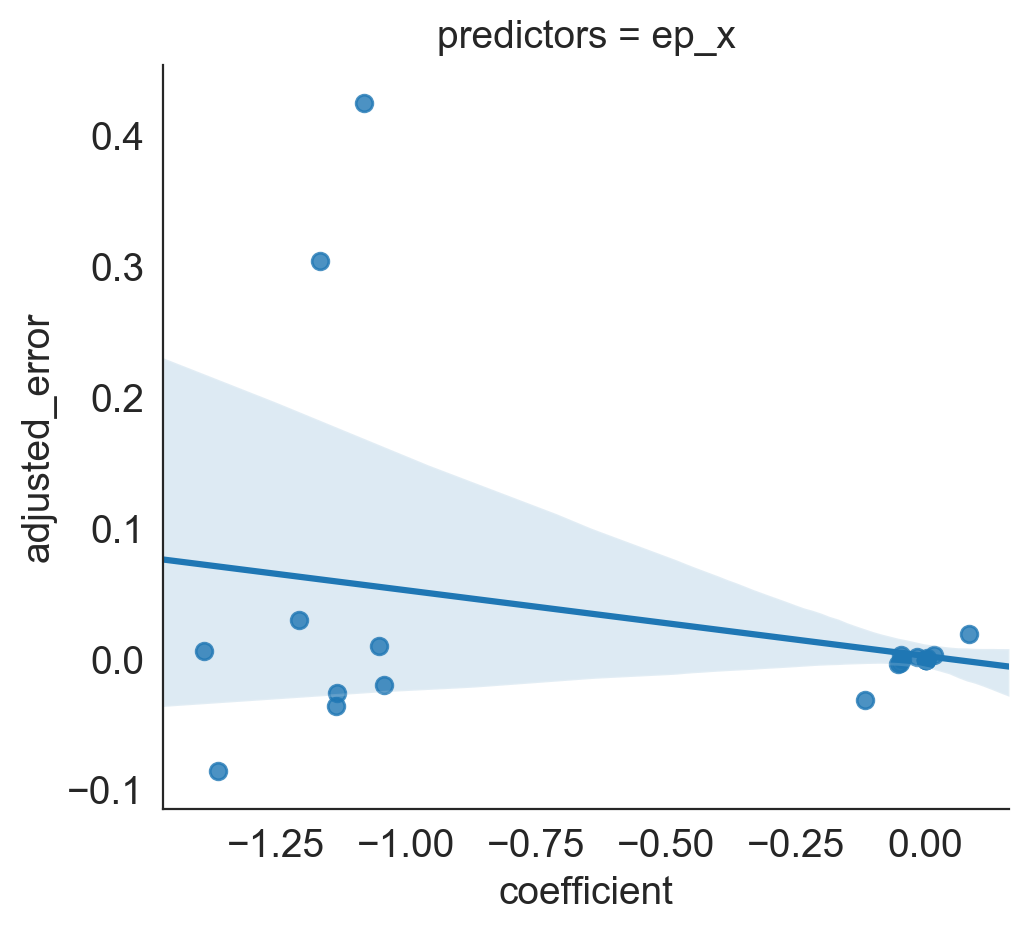

In [120]:
sns.lmplot(
    "coefficient",
    "adjusted_error",
    errors_and_coefficients_by_time,
    col="predictors",
    col_wrap=2,
    sharex=False,
    sharey=False,
    col_order=["ep_x"]
)

## Summarize model coefficients

In [121]:
overall_coefficients_df

mean        predictor        predictors       std
0   6.892781          fitness           fitness  0.907833
1   2.760398              lbi               lbi  0.227260
2   2.916303              lbi  lbi-ep_x-ne_star  0.523387
3   0.201243             ep_x  lbi-ep_x-ne_star  0.878561
4  -0.736884          ne_star  lbi-ep_x-ne_star  0.543161
5  -3.224234          ne_star           ne_star  0.639193
6  -0.257779             ep_x      ep_x-ne_star  0.524582
7  -3.179627          ne_star      ep_x-ne_star  0.613196
8   2.414506  delta_frequency   delta_frequency  1.256914
9  -0.469329             ep_x              ep_x  0.571191
10  0.000000            naive             naive  0.000000

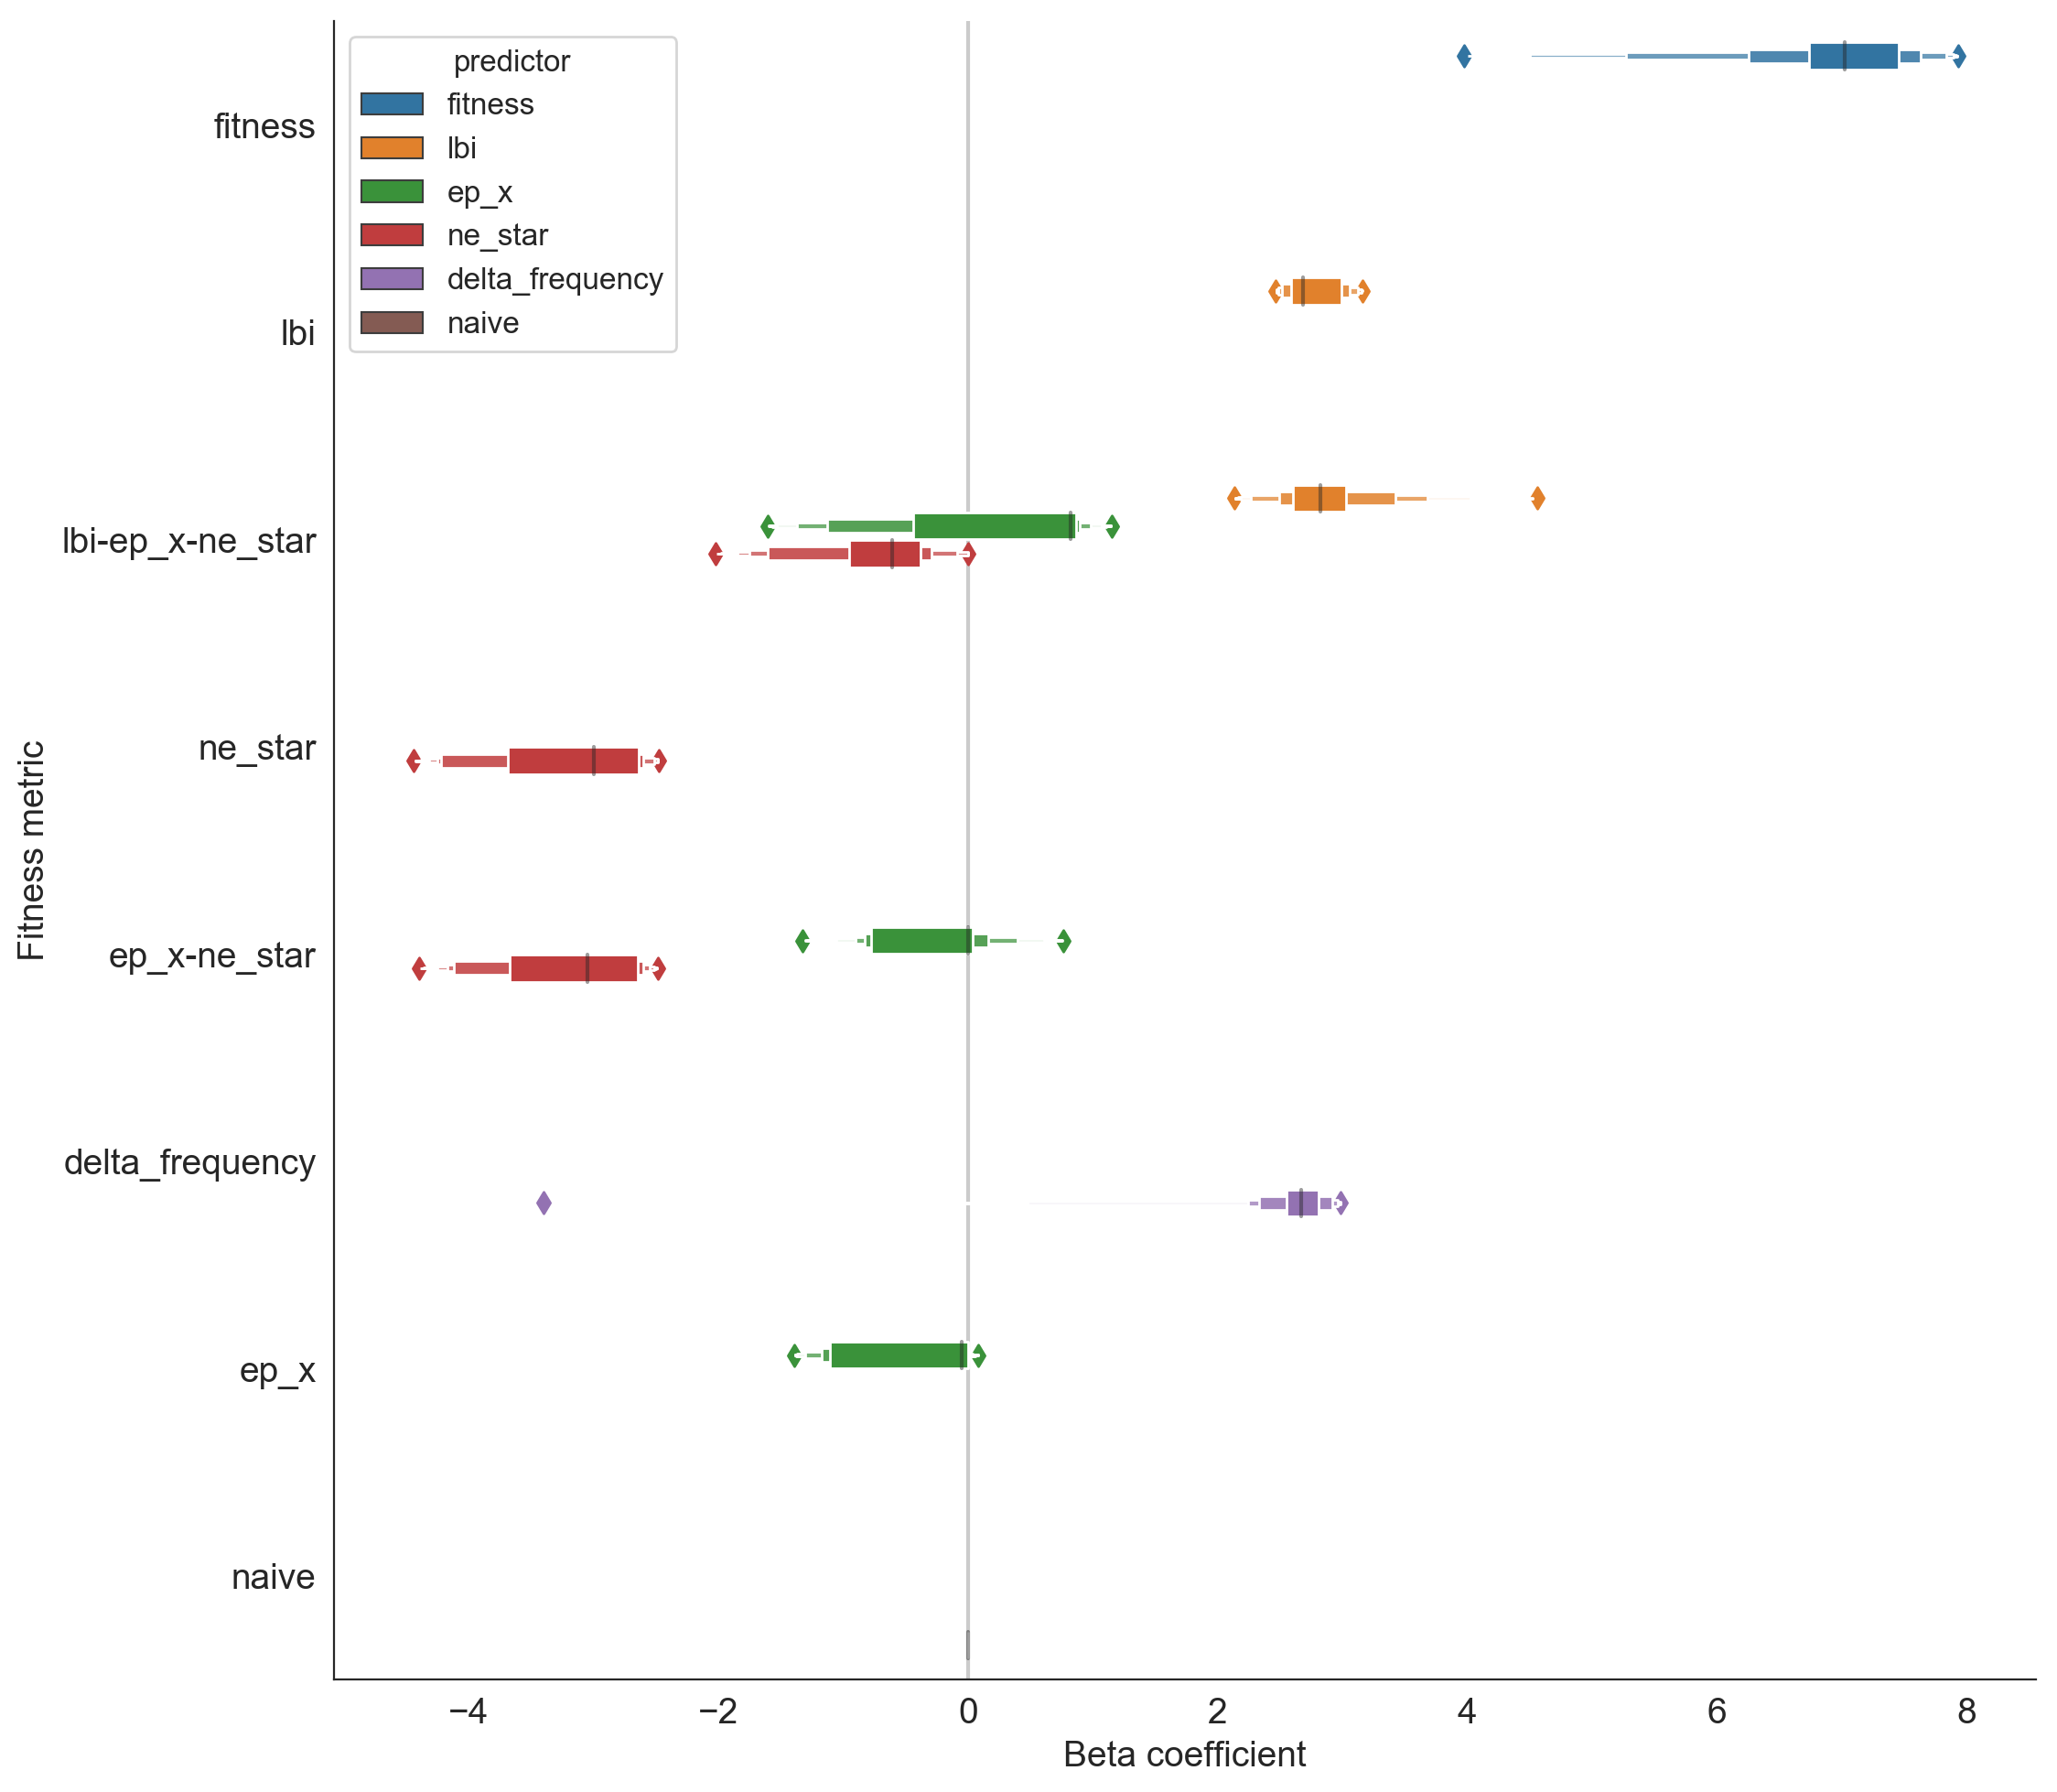

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

#ax.set_xlim(-20, 20)
sns.boxenplot(
    y="predictors",
    x="coefficient",
    hue="predictor",
    data=coefficients_by_time_df,
    ax=ax
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [123]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [124]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [125]:
coefficients_by_time_df["predictors_name"].unique().shape

(8,)

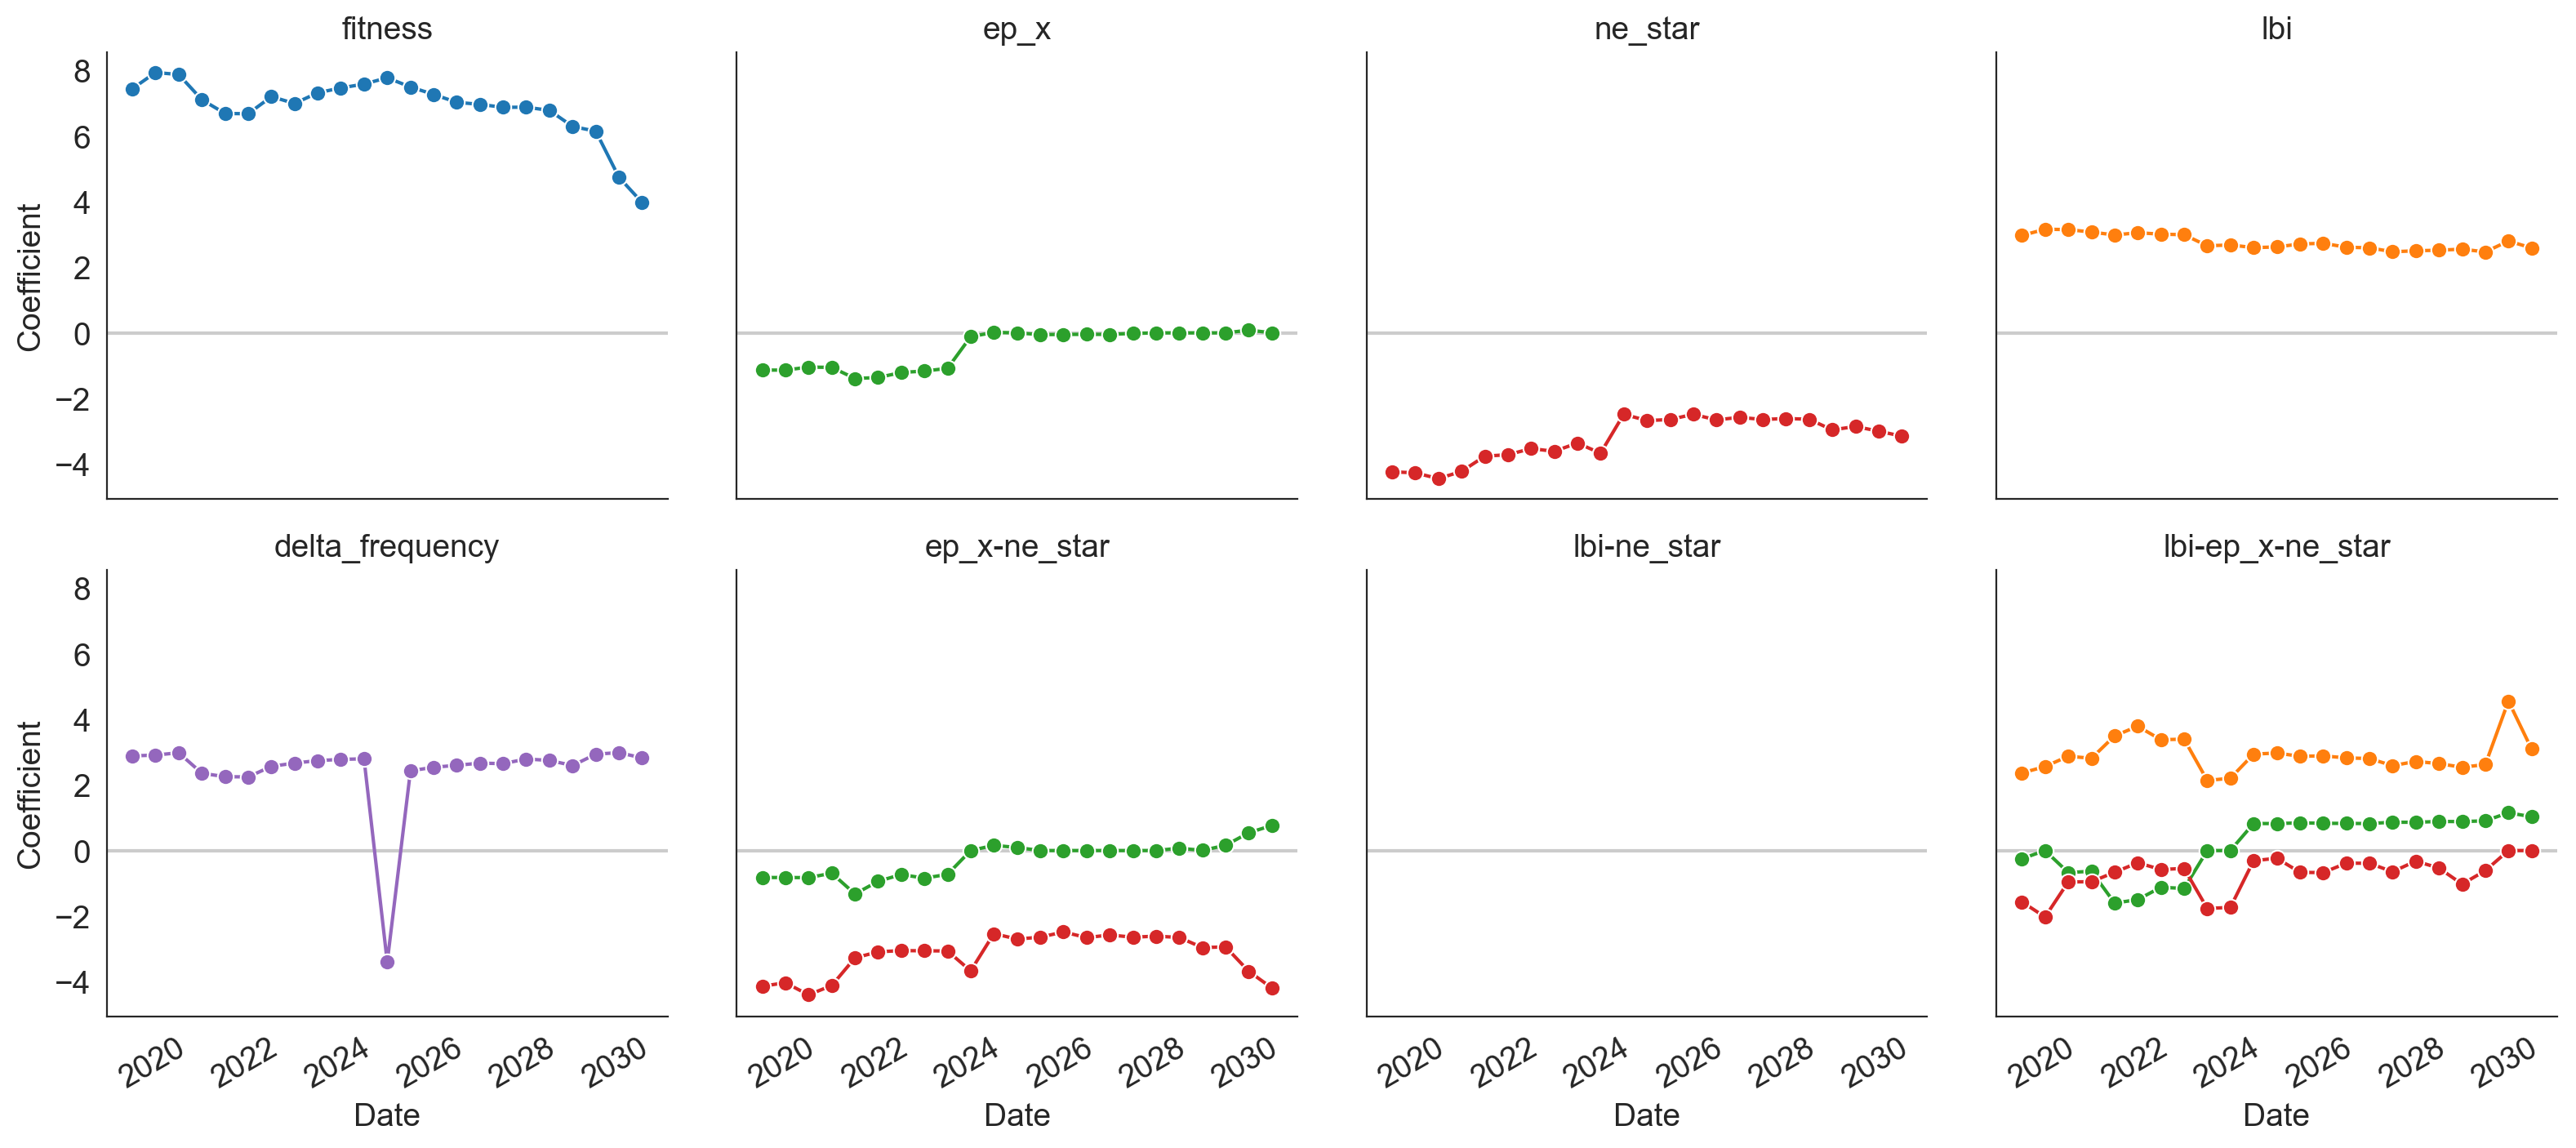

In [126]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor",
    markersize=7
)
g.set_titles("{col_name}")

#for ax in g.axes.flatten():
#    ax.set_ylim(-11, 11)

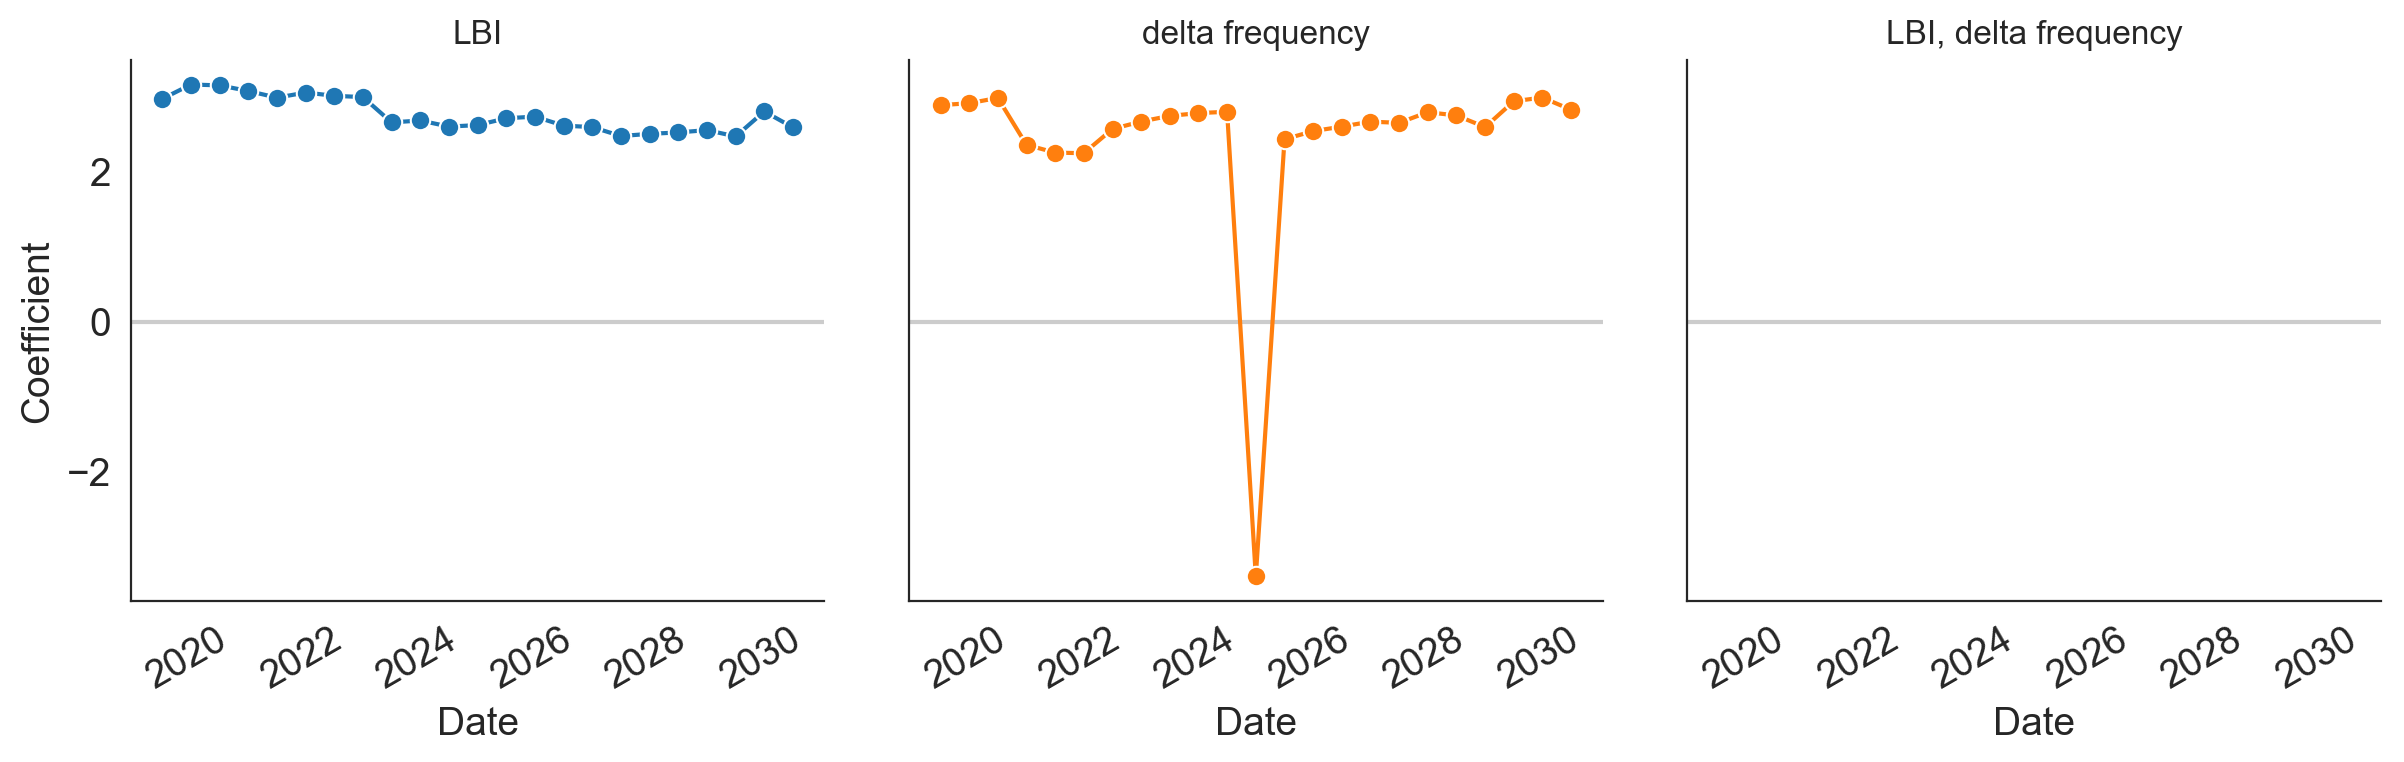

In [127]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order,
    markersize=7
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    #ax.set_ylim(-2., 2.)

## Summary statistics for models

In [128]:
errors_by_time_df.groupby("predictors")["adjusted_error"].aggregate(["mean", "std"])

mean       std
predictors                          
delta_frequency  -0.136344  0.170452
ep_x              0.026295  0.110627
ep_x-ne_star     -0.064100  0.184753
fitness          -0.142708  0.176310
lbi              -0.205377  0.150362
lbi-ep_x-ne_star -0.199536  0.165031
naive             0.000000  0.000000
ne_star          -0.094903  0.128069

In [129]:
overall_coefficients_df

mean        predictor        predictors       std
0   6.892781          fitness           fitness  0.907833
1   2.760398              lbi               lbi  0.227260
2   2.916303              lbi  lbi-ep_x-ne_star  0.523387
3   0.201243             ep_x  lbi-ep_x-ne_star  0.878561
4  -0.736884          ne_star  lbi-ep_x-ne_star  0.543161
5  -3.224234          ne_star           ne_star  0.639193
6  -0.257779             ep_x      ep_x-ne_star  0.524582
7  -3.179627          ne_star      ep_x-ne_star  0.613196
8   2.414506  delta_frequency   delta_frequency  1.256914
9  -0.469329             ep_x              ep_x  0.571191
10  0.000000            naive             naive  0.000000

### Figure 2: Summary of models for simulated populations

In [130]:
nrows = len(individual_predictor_names_order)
ncols = 2

color_by_predictor = {
    'fitness': '#000000',
    'ep_x': '#4575b4',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "fitness": "true fitness",
    "ep_x": "cross-immunity",
    "ne_star": "non-epitope mutations",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

In [131]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0    fitness         -0.148548           101           2018-10-01   
1    fitness         -0.194744           102           2019-04-01   
2    fitness         -0.072634            99           2019-10-01   
3    fitness         -0.191325           100           2020-04-01   
4    fitness         -0.196980           102           2020-10-01   

   simulation_year  simulation_month predictors_name  adjusted_error  
0               18                10         fitness       -0.102352  
1               19                 4         fitness       -0.105770  
2               19                10         fitness       -0.020625  
3               20                 4         fitness       -0.162872  
4               20                10         fitness       -0.269980

In [132]:
min_error = errors_by_time_df["adjusted_error"].min()
max_error = errors_by_time_df["adjusted_error"].max()

min_normal_error = errors_by_time_df["validation_error"].min()
max_normal_error = errors_by_time_df["validation_error"].max()

min_coefficient = coefficients_by_time_df["coefficient"].min()
max_coefficient = coefficients_by_time_df["coefficient"].max()

min_date = errors_by_time_df["validation_timepoint"].min() - np.timedelta64(6, 'M')
max_date = errors_by_time_df["validation_timepoint"].max() + np.timedelta64(6, 'M')

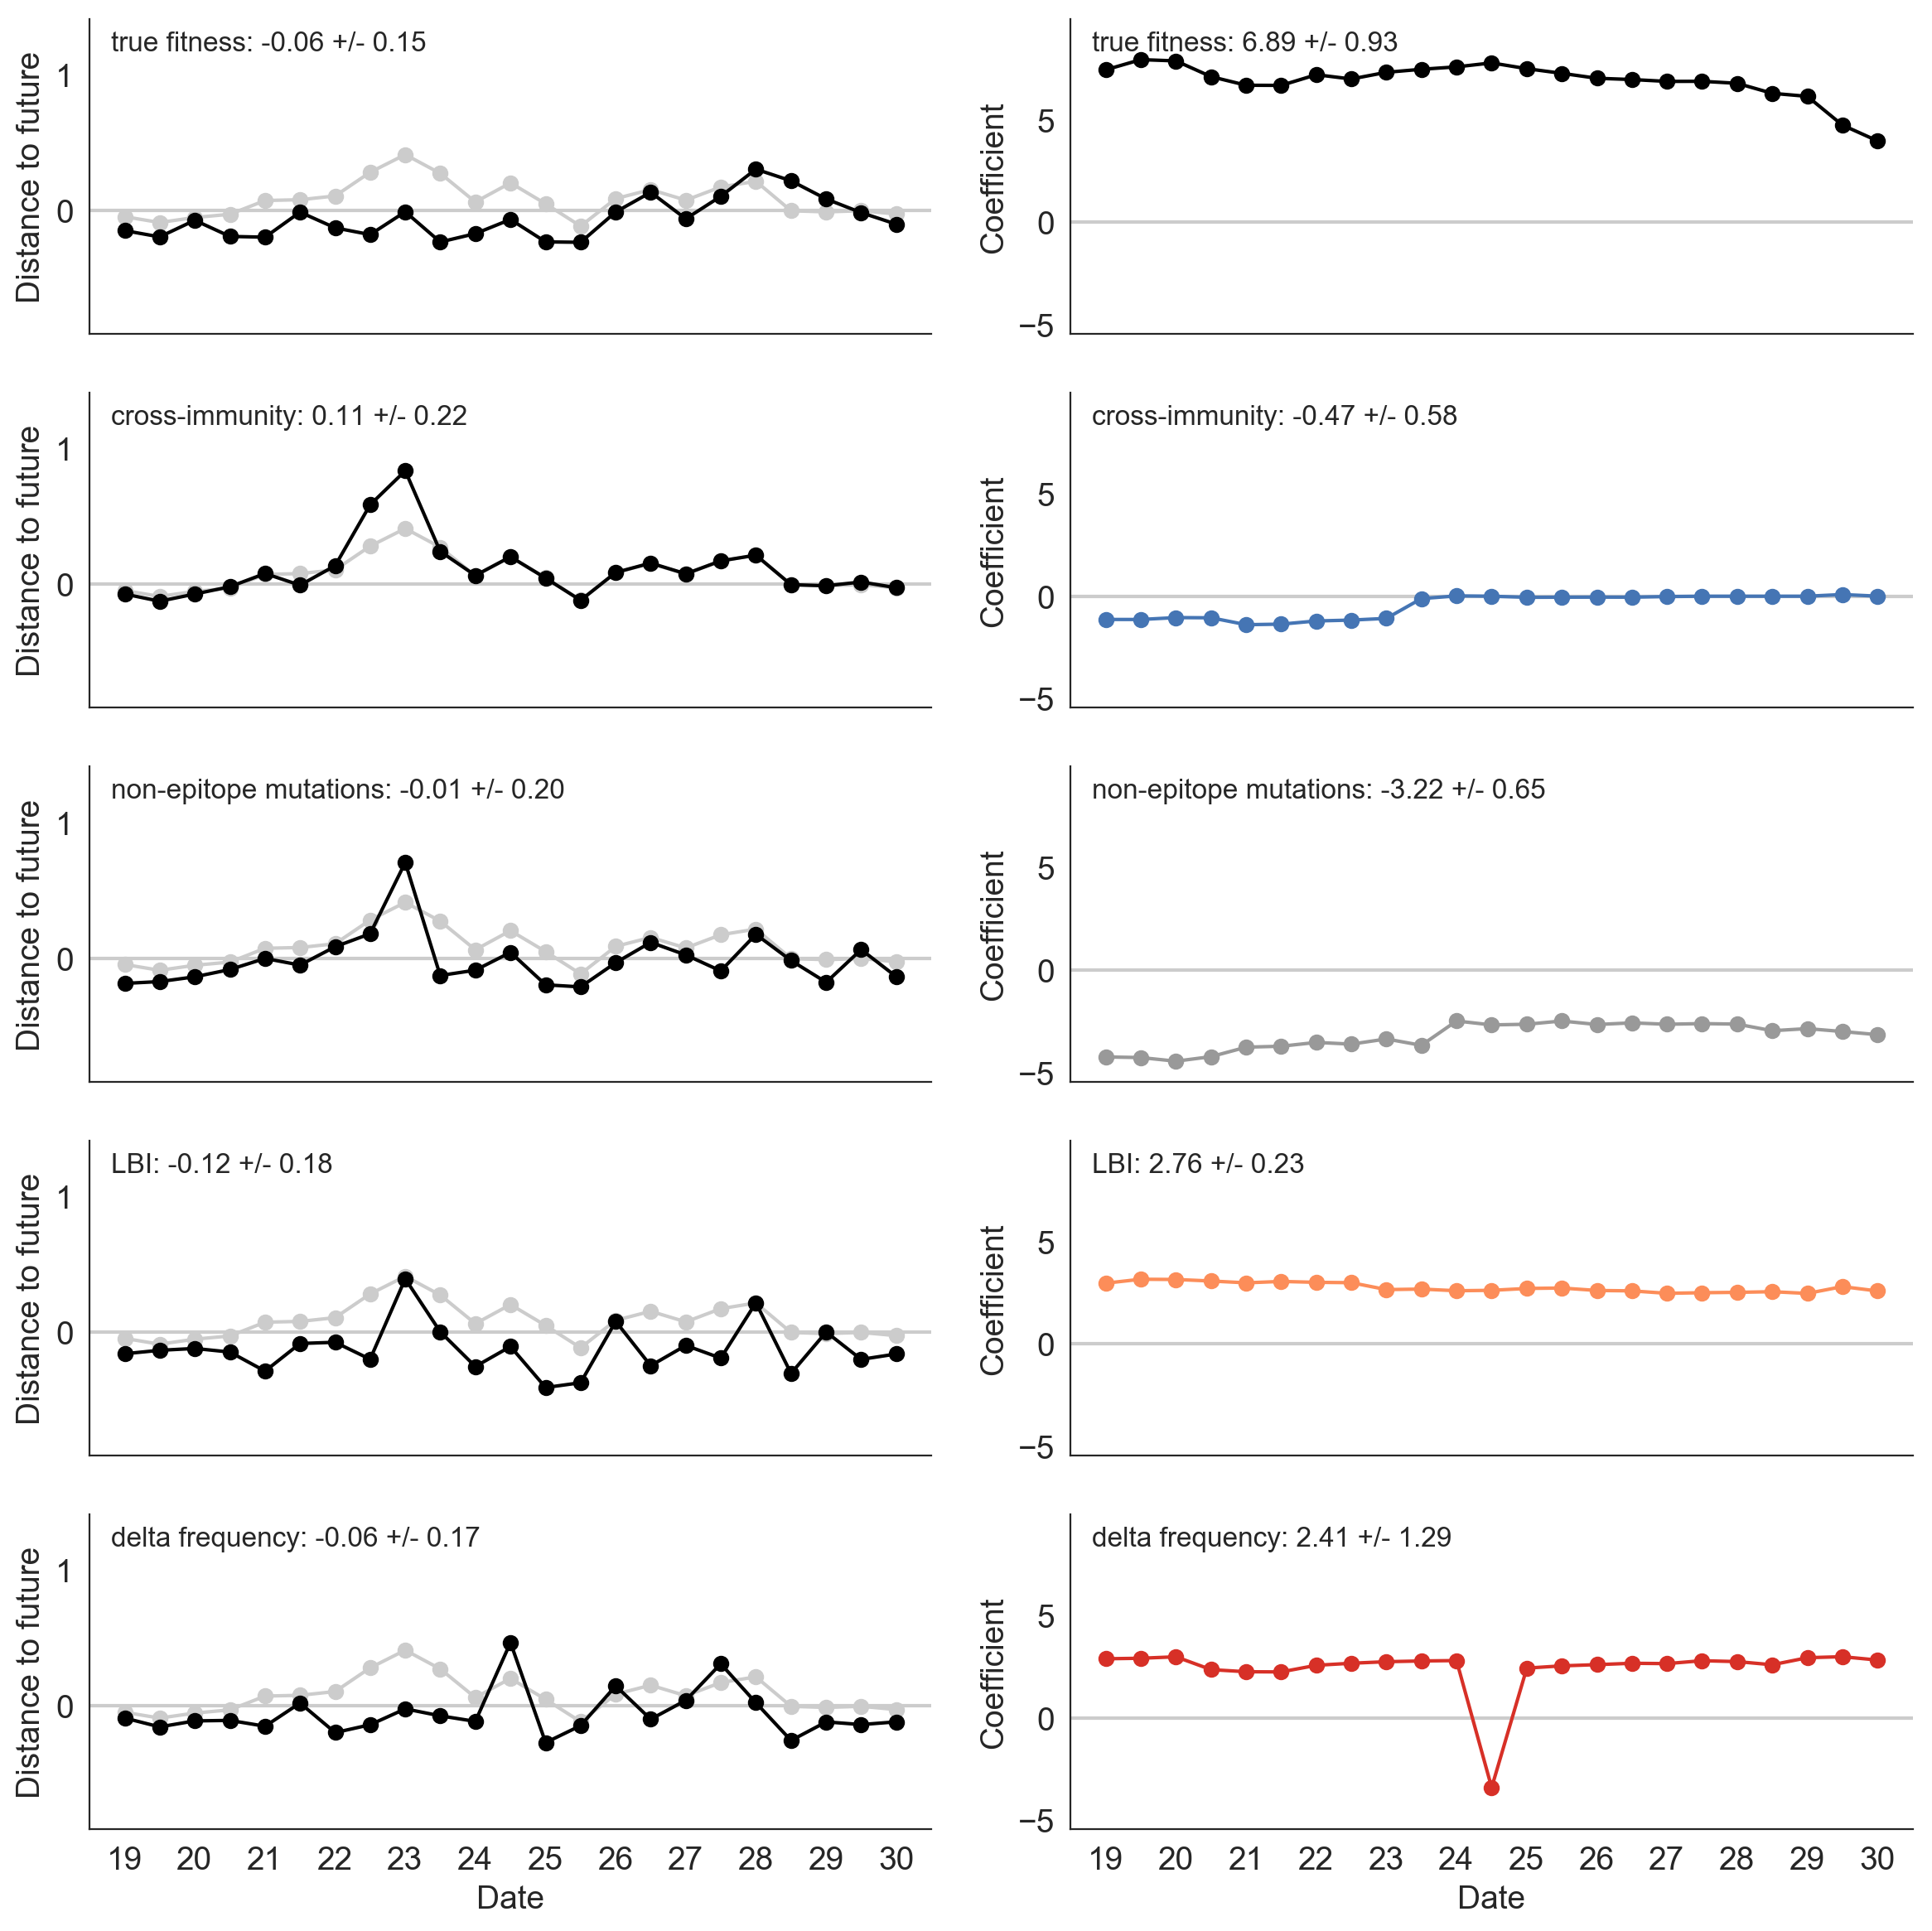

In [133]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(individual_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance to future")
    distance_ax.set_ylim(min_normal_error - 0.5, max_normal_error + 0.5)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], coefficient_df["coefficient"].mean(), coefficient_df["coefficient"].std()),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    coefficient_ax.plot(
        coefficient_df["validation_timepoint"],
        coefficient_df["coefficient"],
        "o-",
        color=color_by_predictor[predictor]
    )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%y-%m')
    
fig.autofmt_xdate(rotation=0)

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

# show x-axis tick lines

In [135]:
composite_predictor_names_order = ["lbi", "ep_x", "ne_star"] + [
    predictor
    for predictor in predictor_names_order
    if "-" in predictor
]

In [136]:
nrows_composite = len(composite_predictor_names_order)

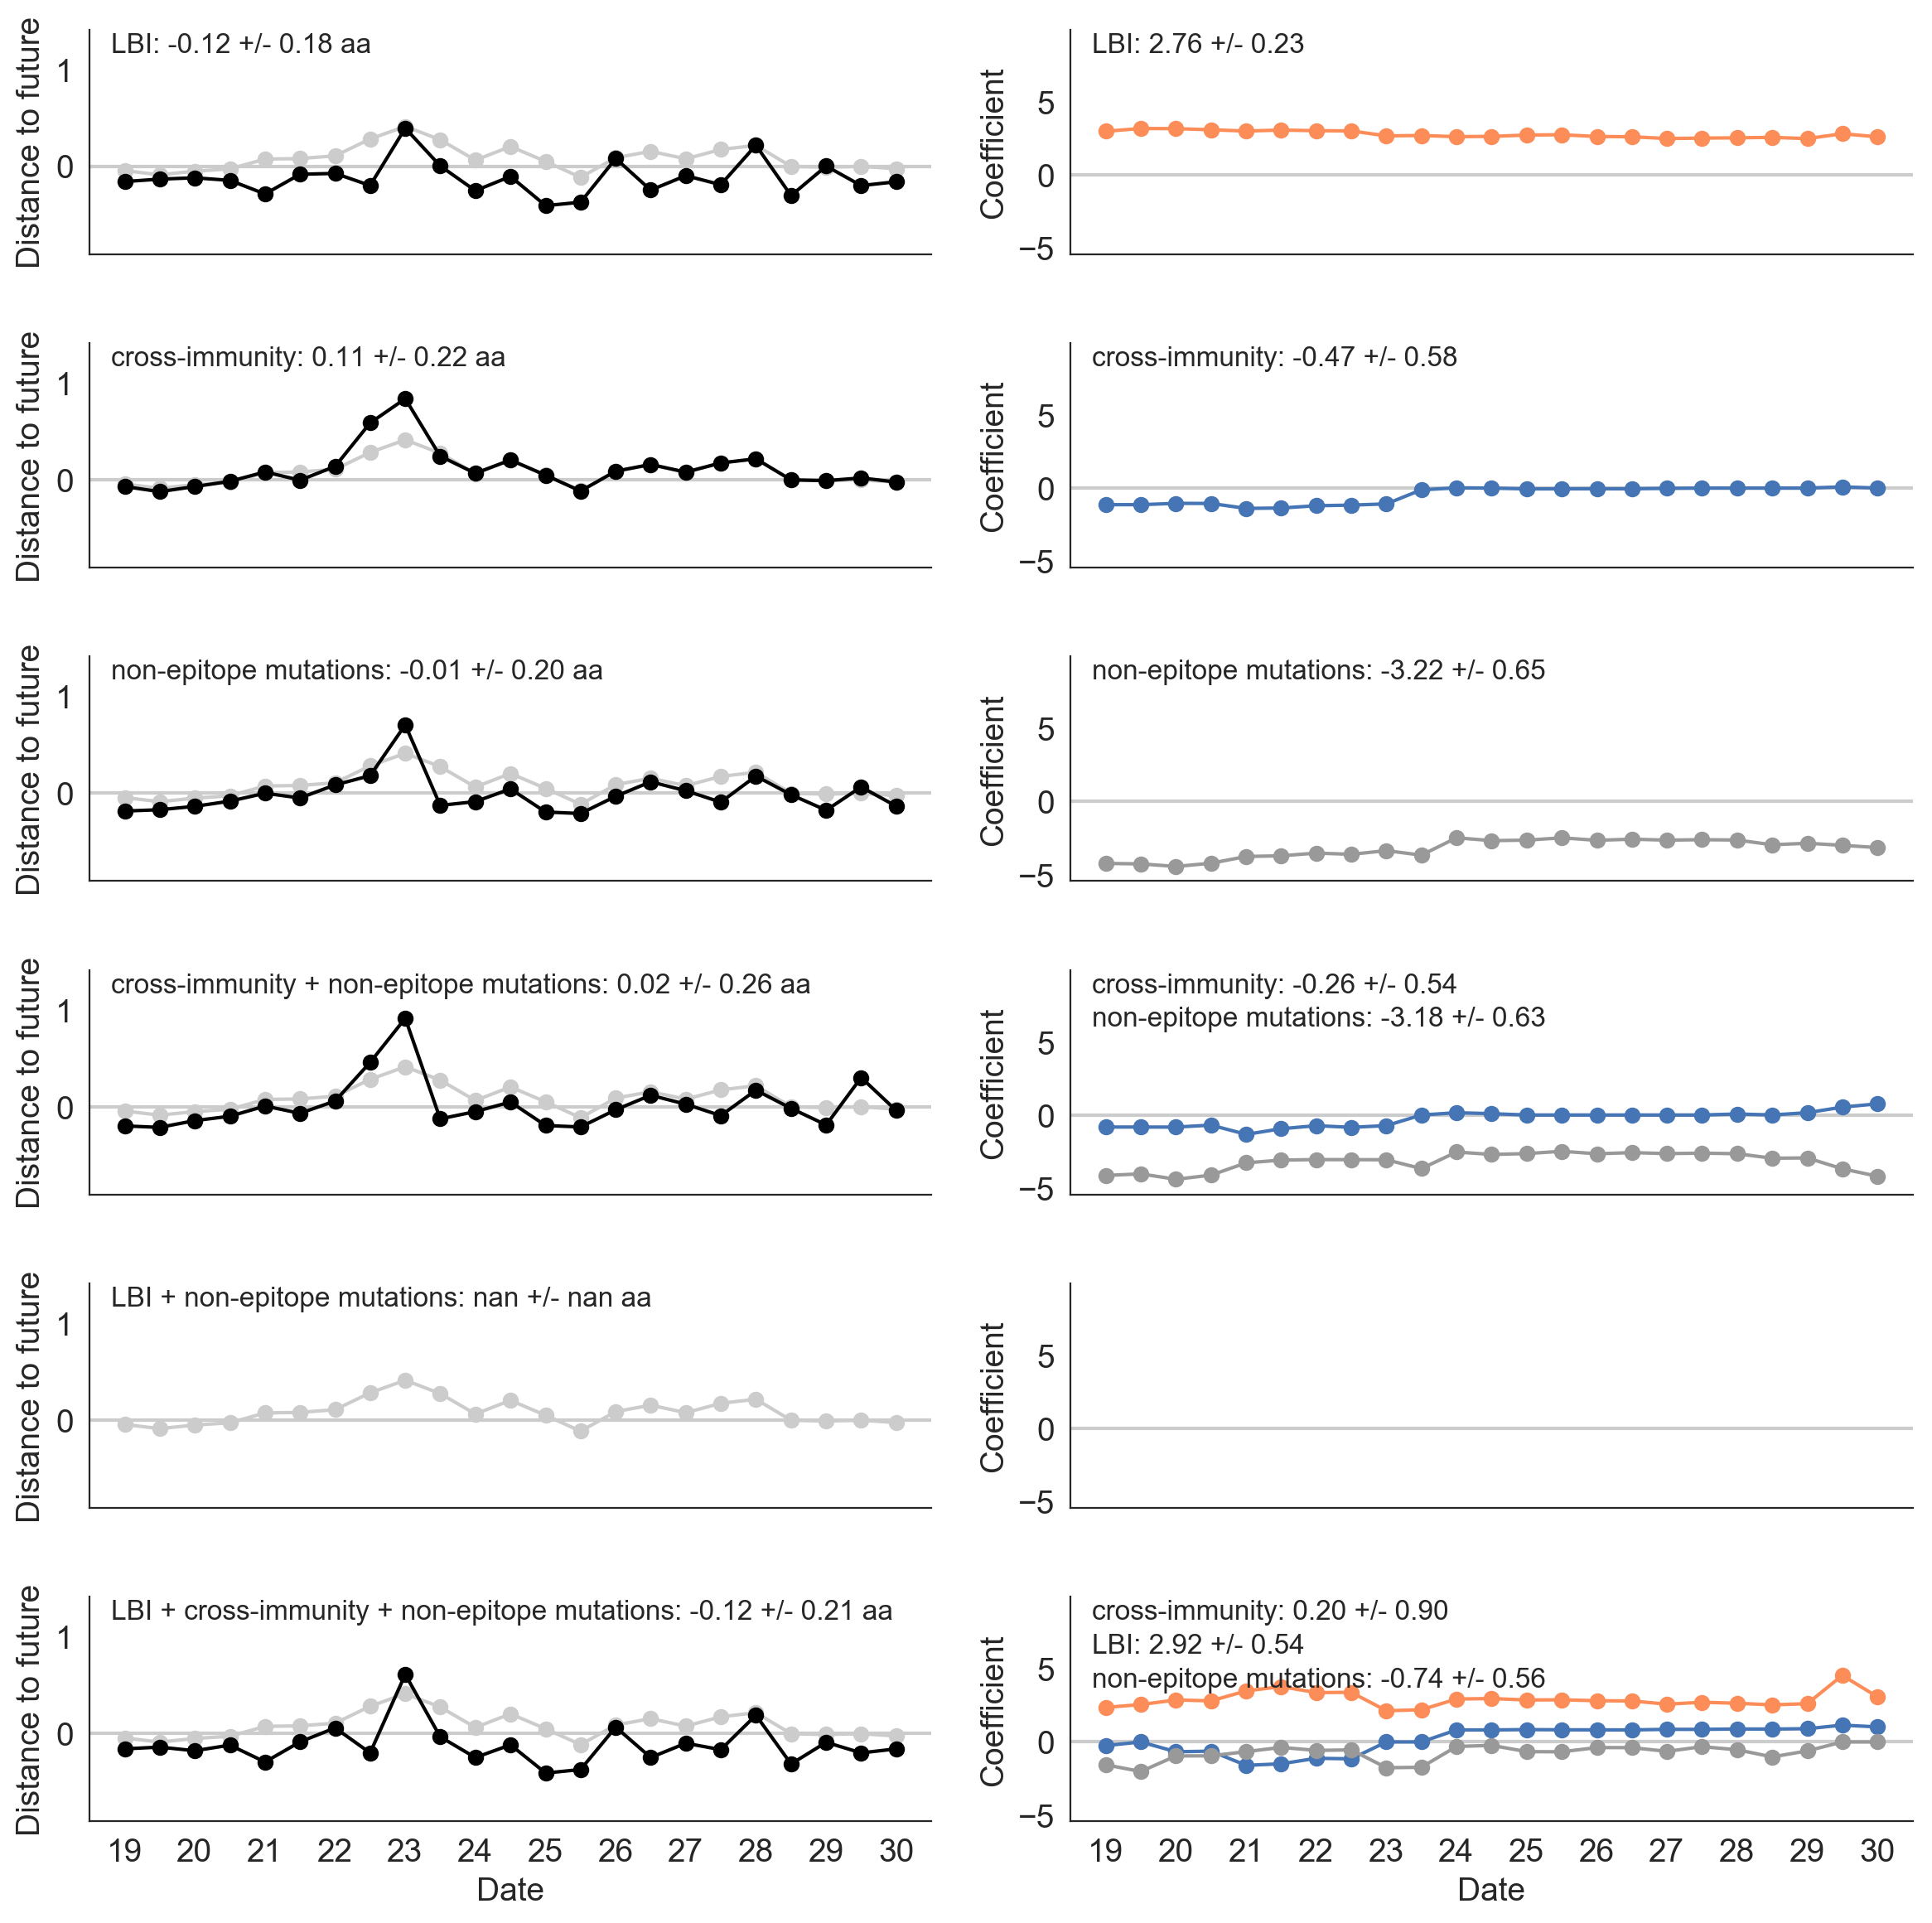

In [138]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows_composite,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(composite_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
    composite_predictors = predictor.split("-")
    composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance to future")
    distance_ax.set_ylim(min_normal_error - 0.5, max_normal_error + 0.5)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f aa" % (composite_predictors_name, error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

    offset = 0.9
    for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):
        coefficient_ax.text(
            0.025,
            offset,
            "%s: %.2f +/- %.2f" % (
                name_by_predictor[individual_predictor],
                individual_predictor_df["coefficient"].mean(),
                individual_predictor_df["coefficient"].std()
            ),
            fontdict={"fontsize": 12},
            transform=coefficient_ax.transAxes
        )
        offset = offset - 0.15
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
        coefficient_ax.plot(
            predictor_coefficient_df["validation_timepoint"],
            predictor_coefficient_df["coefficient"],
            "o-",
            color=color_by_predictor[predictor]
        )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%y-%m')
    
fig.autofmt_xdate(rotation=0)

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

# show x-axis tick lines